---
---

# **`Medicare Provider Fraudulent Detection` 🩺 💰 🕵️‍**

---
---

### **Importing_Libraries**

In [20]:
import os
import sys
import math
import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# **BENE Data - EDA**

In [22]:
train_bene_df = pd.read_csv("Dataset/Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv("Dataset/Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv("Dataset/Train_Outpatientdata-1542865627584.csv")

In [29]:
train_bene_df['Gender'] = train_bene_df['Gender'].apply(lambda val: 0 if val == 2 else 1)

In [31]:
train_bene_df['DOB'] = pd.to_datetime(train_bene_df['DOB'], format="%Y-%m-%d")

In [32]:
train_bene_df['Patient_Age_Year'] = train_bene_df['DOB'].dt.year
train_bene_df['Patient_Age_Month'] = train_bene_df['DOB'].dt.month

* **`Adding new feature`** <::::::::::::::::::::::::> **"`YEAR of birth of beneficiaries`"**

In [33]:
bene_age_year_df = pd.DataFrame(train_bene_df['Patient_Age_Year'].value_counts()).reset_index(drop=False)
bene_age_year_df.columns= ['year','num_of_beneficiaries']
bene_age_year_df = bene_age_year_df.sort_values(by='year')

* **`Adding new feature`** <::::::::::::::::::::::::> **"`MONTH of birth of beneficiaries`"**

In [35]:
bene_age_month_df = pd.DataFrame(train_bene_df['Patient_Age_Month'].value_counts()).reset_index(drop=False)
bene_age_month_df.columns= ['month','num_of_beneficiaries']
bene_age_month_df = bene_age_month_df.sort_values(by='month')

In [38]:
# 0 means ALIVE and 1 means DEAD
train_bene_df['Dead_or_Alive'] = train_bene_df['DOD'].apply(lambda val: 0 if val != val else 1)

In [41]:
train_bene_df['DOD'] = pd.to_datetime(train_bene_df['DOD'])

In [42]:
# Greatest Date of Death in the TRAIN set for beneficiaries
max_bene_DOD = max(train_bene_df['DOD'].unique()[1:])
max_bene_DOD

Timestamp('2009-12-01 00:00:00')

In [43]:
# For all NAN DODs filling the greatest Date of Death
train_bene_df['DOD'].fillna(value=max_bene_DOD, inplace=True)

* **`Adding new feature`** <::::::::::::::::::::::::> **"`Beneficiary AGE`"**
  * This represent the AGE of the beneficiary.


* **`REASONING`**
  * My intention behind adding this feature is to better analyse the CLAIM and Patient related data.

In [44]:
train_bene_df['AGE'] = np.round(((train_bene_df['DOD'] - train_bene_df['DOB']).dt.days)/365.0,1)

In [45]:
train_bene_df.drop(labels=['DOD'],axis=1,inplace=True)

In [49]:
def bene_age_brackets(val):
  if val >=1 and val <=40:
    return 'Young'
  elif val > 40 and val <=60:
    return 'Mid'
  elif val > 60 and val <= 80:
    return 'Old'
  else:
    return 'Very Old'

In [50]:
train_bene_df['AGE_groups'] = train_bene_df['AGE'].apply(lambda age: bene_age_brackets(age))

In [72]:
CC_ALZH_IP_R = pd.DataFrame(train_bene_df.groupby(['ChronicCond_Alzheimer'])['IPAnnualReimbursementAmt'].sum() / train_bene_df.groupby(['ChronicCond_Alzheimer'])['BeneID'].count())
CC_ALZH_IP_R.columns = ['AVG IP Reimbursement Amt']
CC_ALZH_IP_R

,AVG IP Reimbursement Amt
ChronicCond_Alzheimer,
1,5371.165863
2,2809.355777


In [73]:
CC_ALZH_OP_R = pd.DataFrame(train_bene_df.groupby(['ChronicCond_Alzheimer'])['OPAnnualReimbursementAmt'].sum() / train_bene_df.groupby(['ChronicCond_Alzheimer'])['BeneID'].count())
CC_ALZH_OP_R.columns = ['AVG OP Reimbursement Amt']
CC_ALZH_OP_R

,AVG OP Reimbursement Amt
ChronicCond_Alzheimer,
1,1623.463477
2,1136.437372


In [74]:
CC_ALZH_IP_D = pd.DataFrame(train_bene_df.groupby(['ChronicCond_Alzheimer'])['IPAnnualDeductibleAmt'].sum() / train_bene_df.groupby(['ChronicCond_Alzheimer'])['BeneID'].count())
CC_ALZH_IP_D.columns = ['AVG IP Co-payment Amt']
CC_ALZH_IP_D

,AVG IP Co-payment Amt
ChronicCond_Alzheimer,
1,612.715726
2,293.962909


In [75]:
CC_ALZH_OP_D = pd.DataFrame(train_bene_df.groupby(['ChronicCond_Alzheimer'])['OPAnnualDeductibleAmt'].sum() / train_bene_df.groupby(['ChronicCond_Alzheimer'])['BeneID'].count())
CC_ALZH_OP_D.columns = ['AVG OP Co-payment Amt']
CC_ALZH_OP_D

,AVG OP Co-payment Amt
ChronicCond_Alzheimer,
1,467.192044
2,333.212472


In [76]:
CC_ALZH_all_amts = pd.concat([CC_ALZH_IP_R, CC_ALZH_OP_R, CC_ALZH_IP_D, CC_ALZH_OP_D], axis=1)
CC_ALZH_all_amts

,AVG IP Reimbursement Amt,AVG OP Reimbursement Amt,AVG IP Co-payment Amt,AVG OP Co-payment Amt
ChronicCond_Alzheimer,,,,
1,5371.165863,1623.463477,612.715726,467.192044
2,2809.355777,1136.437372,293.962909,333.212472


In [190]:
train_bene_df.drop(["NoOfMonths_PartACov", "NoOfMonths_PartBCov"], axis=1, inplace=True)

In [191]:
train_bene_df.shape

(138556, 27)

In [192]:
train_bene_df.head()

,BeneID,DOB,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Patient_Age_Year,Patient_Age_Month,Dead_or_Alive,AGE,AGE_groups
0,BENE11001,1943-01-01,1,1,0,39,230,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,1943,1,0,67.0,Old
1,BENE11002,1936-09-01,0,1,0,39,280,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50,1936,9,0,73.3,Old
2,BENE11003,1936-08-01,1,1,0,52,590,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40,1936,8,0,73.4,Old
3,BENE11004,1922-07-01,1,1,0,39,270,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760,1922,7,0,87.5,Very Old
4,BENE11005,1935-09-01,1,1,0,24,680,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200,1935,9,0,74.3,Old


In [193]:
train_bene_df.to_csv("train_bene_1.csv")

# **IP & OP Data - EDA**

In [194]:
train_bene_df = pd.read_csv("Dataset/Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Outpatientdata-1542865627584.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../input/healthcare-provider-fraud-detection-analysis/Train_Beneficiarydata-1542865627584.csv'

## ***Records_counts_for_In-patient_&_Out-patient_Data***

- **In-patients**

In [ ]:
train_ip_df.shape

In [ ]:
train_ip_df.dtypes

In [ ]:
train_ip_df.head()

In [ ]:
print("### Number of records where patient gets admitted --> {} ###".format(train_ip_df.shape[0]))

- **Out-patients**

In [ ]:
train_op_df.shape

In [ ]:
train_op_df.dtypes

In [ ]:
train_op_df.head()

In [ ]:
print("### Number of records where patients didn't gets admitted --> {} ###".format(train_op_df.shape[0]))

- **Patient IDs who medicated with or without admission**

In [ ]:
ip_bene_unq = set(train_ip_df['BeneID'])
op_bene_unq = set(train_op_df['BeneID'])

In [ ]:
len(ip_bene_unq), len(op_bene_unq)

- **Number of patients who either are in-patients or out-patients**

In [ ]:
only_in_patients = ip_bene_unq.intersection(op_bene_unq)
len(only_in_patients)

In [ ]:
print("### Only admitted in-patients --> {} ###".format(len(only_in_patients)))

In [ ]:
only_out_patients = op_bene_unq.difference(ip_bene_unq)
len(only_out_patients)

In [ ]:
print("### Only out-patients --> {} ###".format(len(only_out_patients)))

In [ ]:
patients_counts = pd.DataFrame([len(only_in_patients), len(only_out_patients)]).T
patients_counts.columns = ['Only In-patients', 'Only Out-patients']
patients_counts

In [ ]:
tot_patients = len(only_in_patients) + len(only_out_patients)
tot_patients

In [ ]:
# Here, I'm displaying the number of only in-patients and out-patients
with plt.style.context('seaborn-poster'):
    fig = patients_counts.plot(kind='bar',colormap='rainbow')
    # Using the "patches" function we will get the location of the rectangle bars from the graph.
    ## Then by using those location(width & height) values we will add the annotations
    for p in fig.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        fig.annotate(f'{str(round((height*100)/tot_patients,2))+"%"}', (x + width/2, y + height*1.015), ha='center', fontsize=13.5)
    # Providing the labels and title to the graph
    plt.xticks(labels=["Patients Counts"], ticks=[0], rotation=10)
    plt.ylabel("Number or % share of patients\n", fontdict=label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("Number of only In or Out patients\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can decude that 80% of the patients gets medicared without even admission.

# ***Exploring the In-patients Data***

In [ ]:
train_ip_df

- **NULL records in the in-patients data**

In [ ]:
# Here, I'm displaying the number of only in-patients and out-patients
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,12))
    fig = sns.heatmap(pd.DataFrame(train_ip_df.isnull().sum()), annot=True, fmt=".7g", cmap='inferno', cbar=True)
    # Providing the labels and title to the graph
    plt.xticks(labels=[" "], ticks=[0])
    plt.xlabel("Null Counts", fontdict=label_font_dict)
    plt.ylabel("Features Names\n", fontdict=label_font_dict)
    plt.minorticks_on()
    plt.title("Number of Nulls in In-patients dataset\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can see that the majority of the ProcedureCodes are having NULLS. And, ClmDiagnosisCode_10 is very rare among Patients.

- **Added Flag for indicating whether beneficiary admitted or not?**

In [ ]:
train_ip_df["Admitted?"] = 1

- **Added Claim_Clearance_Days**

In [ ]:
train_ip_df['ClaimStartDt'] = pd.to_datetime(train_ip_df['ClaimStartDt'], format="%Y-%m-%d")
train_ip_df['ClaimEndDt'] = pd.to_datetime(train_ip_df['ClaimEndDt'], format="%Y-%m-%d")

In [ ]:
train_ip_df['Claim_Duration'] = (train_ip_df['ClaimEndDt'] - train_ip_df['ClaimStartDt']).dt.days

In [ ]:
train_ip_df['Claim_Duration'].describe()

In [ ]:
# Here, I'm displaying the number of only in-patients and out-patients
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(12,8))
    train_ip_df['Claim_Duration'].plot(kind='hist', colormap="viridis");
    # Providing the labels and title to the graph
    plt.xlabel("Claim Duration(in days)", fontdict=label_font_dict)
    plt.minorticks_on()
    plt.title("Distribution of Claim Duration Days\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can decude that the majority of the claims filed for less than 7 days.


- **Percentiles values**

In [ ]:
for val in [0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999,0.9999,0.99999,0.999999,1.0]:
    percentile = round(float(val*100),6)
    percentile_val = round(train_ip_df["Claim_Duration"].quantile(val),1)
    print("Percentile --> {} and its value is --> {}".format(percentile,percentile_val))

**`OBSERVATION`**
* From the results, we can say that 95% of the claims are filed for 17 days.

### **Q1. What is the relationship b/w Amount of Insurance Claim Reimbursed v/s Claim Clearance Days?**

In [ ]:
unq_claim_duration_days = train_ip_df['Claim_Duration'].unique()
unq_claim_duration_days

In [ ]:
tot_claims_filed_for_specific_days = pd.DataFrame(train_ip_df.groupby(['Claim_Duration'])['BeneID'].count())
tot_claims_filed_for_specific_days

In [ ]:
tot_insc_amount_for_claim_durations = pd.DataFrame(train_ip_df.groupby(['Claim_Duration'])['InscClaimAmtReimbursed'].sum())
tot_insc_amount_for_claim_durations

In [ ]:
claim_clearance_amts = pd.merge(left=tot_claims_filed_for_specific_days, right=tot_insc_amount_for_claim_durations,
                                how='inner',
                                left_on=tot_claims_filed_for_specific_days.index,
                                right_on=tot_insc_amount_for_claim_durations.index)

claim_clearance_amts.columns = ['Claim_durations_in_days', 'Total_claims', 'All_Claims_Total_Amount']
claim_clearance_amts.head()

In [ ]:
claim_clearance_amts['Avg_Claim_Insc_Amount'] = np.round(claim_clearance_amts['All_Claims_Total_Amount']/claim_clearance_amts['Total_claims'],2)

In [ ]:
claim_clearance_amts.head()

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(16,16))
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Total_claims', 
                  color='k', markers="^", linestyles="")
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Total_claims', 
                  color='coral', markers="", linestyles="-")
     
    # Providing the labels and title to the graph
    plt.xticks(rotation=90)
    plt.xlabel("\nClaims Durations(in days)", fontdict= label_font_dict)
    plt.ylabel("Total Claims\n", fontdict= label_font_dict)
    plt.yticks(np.arange(0,7500,200))
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title('\nTrend of "Total Filed Claims" for every duration(in days)', fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* The above graph tells us that the most number of claims are filed for 3 days. And, there are very less number of claims for duration greater than 15.
    * However, we can witness a litter spike for 35 days of duration for claims.

* And, there are around 600 claims for which the duration is 0 that means Claim Start Date and End Date is same.

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(16,7))
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Avg_Claim_Insc_Amount', 
                  color='blue', markers="^", linestyles="")
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Avg_Claim_Insc_Amount', 
                  color='coral', markers="", linestyles="-")
    # Providing the labels and title to the graph
    plt.xticks(rotation=90)
    plt.xlabel("\nVarious Claims duration (in days)", fontdict= label_font_dict)
    plt.ylabel(" ", fontdict= label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title('\nTrend of "Avg Re-imbursed Claim Amount"', fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* The above graph tells us that as the claim duration increases then the Avg Re-imbursed Amount also increases, however, as we have already seen that total number of claims are very less when duration is greater than 15 days.

* Another thing to look here is that if the duration is b/w [30-35] then the Average Re-imbursed amount is very high and reaches its maximum.

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(16,7))
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='All_Claims_Total_Amount', color='green')
    # Providing the labels and title to the graph
    plt.xticks(rotation=90)
    plt.xlabel("\nClaims Durations (in days)", fontdict= label_font_dict)
    plt.ylabel("Total Re-imbursed Claim Amount", fontdict= label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("\nTrend of `Total Re-imbursed Claim Amount` for each filed duration(in days)", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* The above graph tells us that the Total Re-imbursed Amount is the highest for 3 days claims

* And, for claims with durations from 12 to 34 the total re-imbursed amount is very less, however, for 35 days duration we can witness a clear spike that can be a potential sign of fraudulent.

### **Q2. What is the relationship b/w Claimed and Admitted Durations with Re-imbursed Amount?**

In [ ]:
train_ip_df['DischargeDt'] = pd.to_datetime(train_ip_df['DischargeDt'], format="%Y-%m-%d")
train_ip_df['AdmissionDt'] = pd.to_datetime(train_ip_df['AdmissionDt'], format="%Y-%m-%d")

In [ ]:
train_ip_df['Admitted_Days'] = train_ip_df['DischargeDt'] - train_ip_df['AdmissionDt']
train_ip_df['Admitted_Days'] = train_ip_df['Admitted_Days'].dt.days

In [ ]:
claims_with_diff_admitted_and_claimed_dur = train_ip_df[~(train_ip_df['Claim_Duration'] == train_ip_df['Admitted_Days'])]
claims_with_diff_admitted_and_claimed_dur

In [ ]:
claims_with_diff_admitted_and_claimed_dur['InscClaimAmtReimbursed'].sum()

**`OBSERVATION`**
* The above table tells us that there are 49 claims whose Claimed Duration and Admitted Duration are different.

* And, for these 49 claims the total re-imbursed amount is around 0.67 Million. So, doesn't look like an issue here as the admitted days can be greater than claimed duration based upon the plan bought by the beneficiary.

* **Lets check whether claimed duration is greater then admitted duration**

In [ ]:
claims_with_diff_admitted_and_claimed_dur[claims_with_diff_admitted_and_claimed_dur['Claim_Duration']  > \
                                          claims_with_diff_admitted_and_claimed_dur['Admitted_Days']]

In [ ]:
claims_with_diff_admitted_and_claimed_dur[claims_with_diff_admitted_and_claimed_dur['Claim_Duration']  > \
                                          claims_with_diff_admitted_and_claimed_dur['Admitted_Days']]['InscClaimAmtReimbursed'].sum()

**`OBSERVATION`**
* The above table tells us that 17 claims out of 49 have Claimed Duration greater than the Admitted Duration.

* And, for these 17 claims the total re-imbursed amount is around 0.27 Million. For now, I'll keep this feature but my initial look says that it won't be much of a use.

### **Q3. What is the relationship b/w DeductibleAmtPaid and Re-imbursed Amount?**

In [ ]:
no_of_claim_with_no_copay = train_ip_df[train_ip_df['DeductibleAmtPaid'].isna()].shape[0]
no_of_claim_with_no_copay

In [ ]:
no_of_claim_with_copay = train_ip_df[~train_ip_df['DeductibleAmtPaid'].isna()].shape[0]
no_of_claim_with_copay

In [ ]:
percent_of_no_copay_claims = round((no_of_claim_with_no_copay / (no_of_claim_with_copay + no_of_claim_with_no_copay)) * 100,1)
print("### Percentage of claims with no co-payment or deductible --> {}% ###".format(percent_of_no_copay_claims))

In [ ]:
re_imbursed_amt_for_no_copay = train_ip_df[train_ip_df['DeductibleAmtPaid'].isna()]['InscClaimAmtReimbursed'].sum()
re_imbursed_amt_for_no_copay

In [ ]:
re_imbursed_amt_with_some_copay = train_ip_df[~train_ip_df['DeductibleAmtPaid'].isna()]['InscClaimAmtReimbursed'].sum()
re_imbursed_amt_with_some_copay

In [ ]:
tot_sum_of_claims_with_copay = re_imbursed_amt_with_some_copay / (re_imbursed_amt_with_some_copay + re_imbursed_amt_for_no_copay)
tot_sum_of_claims_with_no_copay = re_imbursed_amt_for_no_copay / (re_imbursed_amt_with_some_copay + re_imbursed_amt_for_no_copay)

In [ ]:
percent_of_tot_sum_no_copay_claims_amt = round(tot_sum_of_claims_with_no_copay * 100,1)
print("### Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> {}% ###".\
      format(percent_of_tot_sum_no_copay_claims_amt))

**`OBSERVATION`**
* The above table tells us that there are a 2% of total claims for which there is no co-payment.
    * And, for these 2% (or 899) of total claims the total re-imbursed amount is 10.6 Million that is 2.6% of the total re-imbursed amount.

In [ ]:
# Here, updating the NULL values of DeductibleAmtPaid feature as 0
train_ip_df['DeductibleAmtPaid'].fillna(value=0.0, inplace=True)

### **Q4. What is the relationship of Providers with Total number of claims filed & Re-imbursed Amount?**

In [ ]:
# How many unique providers are there in the dataset?
print("We have {} unique number of Providers in the in-patient dataset.".format(train_ip_df['Provider'].nunique()))

In [ ]:
provider_tot_claims_filed = pd.DataFrame(train_ip_df.groupby(['Provider'])['ClaimID'].count())
provider_tot_reimbursed_amt = pd.DataFrame(train_ip_df.groupby(['Provider'])['InscClaimAmtReimbursed'].sum())

prv_tot_filed_claims_and_tot_reimb_amt = pd.merge(left=provider_tot_claims_filed, right=provider_tot_reimbursed_amt, how='inner',
                                                  left_on=provider_tot_claims_filed.index, right_on=provider_tot_reimbursed_amt.index)

prv_tot_filed_claims_and_tot_reimb_amt.columns = ['ProviderID', 'Tot_Claims_Filed', 'Tot_Re_Imbursed_Amt']
prv_tot_filed_claims_and_tot_reimb_amt.reset_index(drop=True,inplace=True)
prv_tot_filed_claims_and_tot_reimb_amt['Percentage_out_of_tot_reimb_amt'] = round((prv_tot_filed_claims_and_tot_reimb_amt['Tot_Re_Imbursed_Amt'] / train_ip_df['InscClaimAmtReimbursed'].sum()) * 100, 3)

provider_max_reimbursed_amt = pd.DataFrame(train_ip_df.groupby(['Provider'])['InscClaimAmtReimbursed'].max())
provider_max_reimbursed_amt.rename(columns={"InscClaimAmtReimbursed": "Max_Re_Imbursed_Amt"}, inplace=True)

prv_tot_filed_claims_tot_max_reimb_amt = pd.merge(left=prv_tot_filed_claims_and_tot_reimb_amt, 
                                                  right=provider_max_reimbursed_amt, how='inner',
                                                  left_on=prv_tot_filed_claims_and_tot_reimb_amt['ProviderID'], 
                                                  right_on=provider_max_reimbursed_amt.index)

prv_tot_filed_claims_tot_max_reimb_amt.drop(['key_0'], axis=1, inplace=True)
prv_tot_filed_claims_tot_max_reimb_amt['Diff_in_Tot_and_Max'] = prv_tot_filed_claims_tot_max_reimb_amt['Tot_Re_Imbursed_Amt'] - \
prv_tot_filed_claims_tot_max_reimb_amt['Max_Re_Imbursed_Amt']

prv_tot_filed_claims_tot_max_reimb_amt.head()

In [ ]:
prv_tot_filed_claims_tot_max_reimb_amt.sort_values(by=['Diff_in_Tot_and_Max','Max_Re_Imbursed_Amt','Percentage_out_of_tot_reimb_amt'],
                                                   axis=0, inplace=True,
                                                   ascending=[True, False, False])

In [ ]:
prv_tot_filed_claims_tot_max_reimb_amt.head(60)

**`OBSERVATION`**
* The above table showing us the Provider Ids who only filed 1 or 2 claims and got the entire amount re-imbursed.
    * This, can be a potential sign of fraudulent because many small-small hospitals in rural area who don't have much facilities or equipments made fraud for benefits. Similar recently happened : refer here https://www.justice.gov/opa/pr/two-individuals-convicted-14-billion-health-care-fraud-scheme-involving-rural-hospitals

In [ ]:
tot_re_imb_amt_for_prv_with_5orless_claims = prv_tot_filed_claims_tot_max_reimb_amt[prv_tot_filed_claims_tot_max_reimb_amt['Tot_Claims_Filed'] < 5] \
                                            ['Tot_Re_Imbursed_Amt'].sum()

pp_re_imb_amt_for_prv_with_5orless_claims = round((tot_re_imb_amt_for_prv_with_5orless_claims / train_ip_df['InscClaimAmtReimbursed'].sum()) * 100,2)
print("### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> {} (17 Million). ###\n\
### And, this is {}% of Total Re-imbursed Claim Amount (408 Million). ###".format(tot_re_imb_amt_for_prv_with_5orless_claims, 
                                                                    pp_re_imb_amt_for_prv_with_5orless_claims))

# ***Exploring the Out-patients Data***

In [ ]:
train_op_df.shape

- **NULL records in the in-patients data**

In [ ]:
# Here, I'm displaying the number of only out-patients
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,12))
    fig = sns.heatmap(pd.DataFrame(train_op_df.isnull().sum()), annot=True, fmt=".7g", cmap='inferno', cbar=True)
    # Providing the labels and title to the graph
    plt.xticks(labels=[" "], ticks=[0])
    plt.xlabel("Null Counts", fontdict=label_font_dict)
    plt.ylabel("Features Names\n", fontdict=label_font_dict)
    plt.minorticks_on()
    plt.title("Number of Nulls in Out-patients dataset\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can say that the majority of the ProcedureCodes are having NULLS. 

* ClmDiagnosisCode_9 & ClmDiagnosisCode_10 are very rare among Patients.

- **Added Flag for indicating whether beneficiary admitted or not?**

In [ ]:
train_op_df["Admitted?"] = 0

- **Added Claim_Clearance_Days**

In [ ]:
train_op_df['ClaimStartDt'] = pd.to_datetime(train_op_df['ClaimStartDt'], format="%Y-%m-%d")
train_op_df['ClaimEndDt'] = pd.to_datetime(train_op_df['ClaimEndDt'], format="%Y-%m-%d")

In [ ]:
train_op_df['Claim_Duration'] = (train_op_df['ClaimEndDt'] - train_op_df['ClaimStartDt']).dt.days

In [ ]:
train_op_df['Claim_Duration'].describe()

In [ ]:
# Here, I'm displaying the number of only out-patients
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(12,8))
    train_op_df['Claim_Duration'].plot(kind='hist', colormap="viridis");
    # Providing the labels and title to the graph
    plt.xlabel("Claim Duration(in days)", fontdict=label_font_dict)
    plt.minorticks_on()
    plt.title("Distribution of Claim Duration Days\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can decude that the majority of the claims filed for less than or equals to 2 days.


- **Percentiles values**

In [ ]:
for val in [0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999,0.9999,0.99999,0.999999,1.0]:
    percentile = round(float(val*100),6)
    percentile_val = round(train_op_df["Claim_Duration"].quantile(val),1)
    print("Percentile --> {} and its value is --> {}".format(percentile,percentile_val))

**`OBSERVATION`**
* From the results, we can say that 90% of the claims are filed for 2 days.

### **Q5. What is the relationship b/w Claim Duration and Re-imbursed Amount?**

In [ ]:
with plt.style.context("seaborn-poster"):
    sns.stripplot(x="Claim_Duration", y="InscClaimAmtReimbursed", data=train_op_df, palette="plasma")
    # Providing the labels and title to the graph
    plt.xlabel("Claim Durations (in days)", fontdict=label_font_dict)
    plt.ylabel("Claim Re-imbursed Amount\n", fontdict=label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("Various re-imbursed amounts for different claim durations\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can decude that the majority of the claims filed have re-imbursed amount less than 20,000. And, very few have more than 1,00,000.

In [ ]:
for val in [0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999,0.9999,0.99999,0.999999,1.0]:
    percentile = round(float(val*100),6)
    percentile_val = round(train_op_df["InscClaimAmtReimbursed"].quantile(val),1)
    print("Percentile --> {} and its value is --> {}".format(percentile,percentile_val))

* **99.9% of claims have Re-imbursed amount less than 3500.**

### **Q5.1 What is the relationship b/w Claim Duration and Co-Payment?**

In [ ]:
with plt.style.context("seaborn-poster"):
    sns.stripplot(x="Claim_Duration", y="DeductibleAmtPaid", data=train_op_df, palette="plasma")
    # Providing the labels and title to the graph
    plt.xlabel("Claim Durations (in days)", fontdict=label_font_dict)
    plt.ylabel("Co-payment Amount\n", fontdict=label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("Various co-payments paid for different claim durations\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can decude that the trend of co-payment is similar across the various durations, however, there are few co-payment which are very high or more than 800.

### **Q6. What is the relationship b/w Amount of Insurance Claim Reimbursed v/s Claim Clearance Days?**

In [ ]:
unq_claim_duration_days = train_op_df['Claim_Duration'].unique()
unq_claim_duration_days

In [ ]:
train_op_df.columns

In [ ]:
tot_claims_filed_for_specific_days = pd.DataFrame(train_op_df.groupby(['Claim_Duration'])['ClaimID'].count())
tot_claims_filed_for_specific_days

In [ ]:
tot_insc_amount_for_claim_durations = pd.DataFrame(train_op_df.groupby(['Claim_Duration'])['InscClaimAmtReimbursed'].sum())
tot_insc_amount_for_claim_durations

In [ ]:
claim_clearance_amts = pd.merge(left=tot_claims_filed_for_specific_days, right=tot_insc_amount_for_claim_durations,
                                how='inner',
                                left_on=tot_claims_filed_for_specific_days.index,
                                right_on=tot_insc_amount_for_claim_durations.index)

claim_clearance_amts.columns = ['Claim_durations_in_days', 'Total_claims', 'All_Claims_Total_Amount']
claim_clearance_amts.head()

In [ ]:
claim_clearance_amts['Avg_Claim_Insc_Amount'] = np.round(claim_clearance_amts['All_Claims_Total_Amount']/claim_clearance_amts['Total_claims'],2)

In [ ]:
claim_clearance_amts.head()

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(16,10))
    fig = sns.barplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Total_claims', palette='plasma')     
    # Using the "patches" function we will get the location of the rectangle bars from the graph.
    ## Then by using those location(width & height) values we will add the annotations
    for p in fig.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        fig.annotate(f'{str(round((height*100)/claim_clearance_amts["Total_claims"].sum(),2))+"%"}', (x + width/2, y + height*1.02), ha='center', fontsize=9, rotation=0)
    
    # Providing the labels and title to the graph
    plt.xticks(rotation=90)
    plt.xlabel("\nClaims Durations(in days)", fontdict= label_font_dict)
    plt.ylabel("Total Claims\n", fontdict= label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title('\nTrend of "Total Filed Claims" for every duration(in days)', fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* The above graph tells us that the most number of claims are filed for 0 days. And, there are very less number of claims for other durations.
    * However, we can witness a litter spike for 20 days of duration for claims.

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(14,7))
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Avg_Claim_Insc_Amount', 
                  color='blue', markers="^", linestyles="")
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Avg_Claim_Insc_Amount', 
                  color='coral', markers="", linestyles="-")
    # Providing the labels and title to the graph
    plt.xticks(rotation=90)
    plt.xlabel("\nVarious Claims duration (in days)", fontdict= label_font_dict)
    plt.ylabel(" ", fontdict= label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title('\nTrend of "Avg Re-imbursed Claim Amount"', fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* The above graph tells us that the Average Re-imbursed Amount is same throughout the various durations except for 21 and 23 days.

In [195]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(16,7))
    sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='All_Claims_Total_Amount', color='green')
    # Providing the labels and title to the graph
    plt.xticks(rotation=90)
    plt.xlabel("\nClaims Durations (in days)", fontdict= label_font_dict)
    plt.ylabel("Total Re-imbursed Claim Amount", fontdict= label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("\nTrend of `Total Re-imbursed Claim Amount` for each filed duration(in days)", fontdict=title_font_dict)
    plt.plot();

NameError: name 'claim_clearance_amts' is not defined

<Figure size 1600x700 with 0 Axes>

**`OBSERVATION`**
* The above graph tells us that the Total Re-imbursed Amount is the highest for 0 days claims.

* And, for claims with durations from 2 to 19 the total re-imbursed amount is very less or similar, however, for 20 days duration we can witness a clear spike that can be a potential sign of fraudulent.

### **Q7. What is the relationship b/w DeductibleAmtPaid and Re-imbursed Amount?**

In [196]:
no_of_claim_with_no_copay = train_op_df[train_op_df['DeductibleAmtPaid'] == 0].shape[0]
no_of_claim_with_no_copay

496701

In [197]:
no_of_claim_with_copay = train_op_df[train_op_df['DeductibleAmtPaid'] != 0].shape[0]
no_of_claim_with_copay

21036

In [198]:
percent_of_no_copay_claims = round((no_of_claim_with_no_copay / (no_of_claim_with_copay + no_of_claim_with_no_copay)) * 100,1)
print("### Percentage of claims with no co-payment or deductible --> {}% ###".format(percent_of_no_copay_claims))

### Percentage of claims with no co-payment or deductible --> 95.9% ###


In [199]:
re_imbursed_amt_for_no_copay = train_op_df[train_op_df['DeductibleAmtPaid'] == 0]['InscClaimAmtReimbursed'].sum()
re_imbursed_amt_for_no_copay

142391850

In [200]:
re_imbursed_amt_with_some_copay = train_op_df[train_op_df['DeductibleAmtPaid'] != 0]['InscClaimAmtReimbursed'].sum()
re_imbursed_amt_with_some_copay

5854270

In [201]:
tot_sum_of_claims_with_copay = re_imbursed_amt_with_some_copay / (re_imbursed_amt_with_some_copay + re_imbursed_amt_for_no_copay)
tot_sum_of_claims_with_no_copay = re_imbursed_amt_for_no_copay / (re_imbursed_amt_with_some_copay + re_imbursed_amt_for_no_copay)

In [202]:
percent_of_tot_sum_no_copay_claims_amt = round(tot_sum_of_claims_with_no_copay * 100,1)
print("### Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> {}% ###".\
      format(percent_of_tot_sum_no_copay_claims_amt))

### Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> 96.1% ###


**`OBSERVATION`**
* The above table tells us that there are 95.9% of total claims for which there is no co-payment.
    * And, for these 95.9% of total claims the total re-imbursed amount is 142.3 Million that is 96.1% of the total re-imbursed amount.

### **Q8. What is the relationship of Providers with Total number of claims filed & Re-imbursed Amount?**

In [203]:
# How many unique providers are there in the dataset?
print("We have {} unique number of Providers in the in-patient dataset.".format(train_op_df['Provider'].nunique()))

We have 5012 unique number of Providers in the in-patient dataset.


In [204]:
provider_tot_claims_filed = pd.DataFrame(train_op_df.groupby(['Provider'])['ClaimID'].count())
provider_tot_reimbursed_amt = pd.DataFrame(train_op_df.groupby(['Provider'])['InscClaimAmtReimbursed'].sum())

prv_tot_filed_claims_and_tot_reimb_amt = pd.merge(left=provider_tot_claims_filed, right=provider_tot_reimbursed_amt, how='inner',
                                                  left_on=provider_tot_claims_filed.index, right_on=provider_tot_reimbursed_amt.index)

prv_tot_filed_claims_and_tot_reimb_amt.columns = ['ProviderID', 'Tot_Claims_Filed', 'Tot_Re_Imbursed_Amt']
prv_tot_filed_claims_and_tot_reimb_amt.reset_index(drop=True,inplace=True)
prv_tot_filed_claims_and_tot_reimb_amt['Percentage_out_of_tot_reimb_amt'] = round((prv_tot_filed_claims_and_tot_reimb_amt['Tot_Re_Imbursed_Amt'] / train_op_df['InscClaimAmtReimbursed'].sum()) * 100, 3)

provider_max_reimbursed_amt = pd.DataFrame(train_op_df.groupby(['Provider'])['InscClaimAmtReimbursed'].max())
provider_max_reimbursed_amt.rename(columns={"InscClaimAmtReimbursed": "Max_Re_Imbursed_Amt"}, inplace=True)

prv_tot_filed_claims_tot_max_reimb_amt = pd.merge(left=prv_tot_filed_claims_and_tot_reimb_amt, 
                                                  right=provider_max_reimbursed_amt, how='inner',
                                                  left_on=prv_tot_filed_claims_and_tot_reimb_amt['ProviderID'], 
                                                  right_on=provider_max_reimbursed_amt.index)

prv_tot_filed_claims_tot_max_reimb_amt.drop(['key_0'], axis=1, inplace=True)
prv_tot_filed_claims_tot_max_reimb_amt['Diff_in_Tot_and_Max'] = prv_tot_filed_claims_tot_max_reimb_amt['Tot_Re_Imbursed_Amt'] - \
prv_tot_filed_claims_tot_max_reimb_amt['Max_Re_Imbursed_Amt']

prv_tot_filed_claims_tot_max_reimb_amt.head()

,ProviderID,Tot_Claims_Filed,Tot_Re_Imbursed_Amt,Percentage_out_of_tot_reimb_amt,Max_Re_Imbursed_Amt,Diff_in_Tot_and_Max
0,PRV51001,20,7640,0.005,1500,6140
1,PRV51003,70,32670,0.022,3300,29370
2,PRV51004,149,52170,0.035,3300,48870
3,PRV51005,1165,280910,0.189,4080,276830
4,PRV51007,69,14710,0.010,3300,11410


In [205]:
prv_tot_filed_claims_tot_max_reimb_amt.sort_values(by=['Diff_in_Tot_and_Max','Max_Re_Imbursed_Amt','Percentage_out_of_tot_reimb_amt'],
                                                   axis=0, inplace=True,
                                                   ascending=[True, False, False])

In [206]:
prv_tot_filed_claims_tot_max_reimb_amt.head(60)

,ProviderID,Tot_Claims_Filed,Tot_Re_Imbursed_Amt,Percentage_out_of_tot_reimb_amt,Max_Re_Imbursed_Amt,Diff_in_Tot_and_Max
82,PRV51119,1,95580,0.064,95580,0
2480,PRV54295,1,3300,0.002,3300,0
2485,PRV54302,1,3300,0.002,3300,0
3307,PRV55456,1,3300,0.002,3300,0
433,PRV51577,1,2100,0.001,2100,0
1473,PRV52954,1,2100,0.001,2100,0
4326,PRV56819,1,1900,0.001,1900,0
5010,PRV57762,1,1900,0.001,1900,0
521,PRV51689,1,1700,0.001,1700,0
3430,PRV55610,1,1700,0.001,1700,0


**`OBSERVATION`**
* The above table showing us the Provider Ids who only filed 1 or 2 claims and got the entire amount re-imbursed.
    * This, can be a potential sign of fraudulent because many small-small hospitals in rural area who don't have much facilities or equipments made fraud for benefits. Similar recently happened : refer here https://www.justice.gov/opa/pr/two-individuals-convicted-14-billion-health-care-fraud-scheme-involving-rural-hospitals

In [207]:
tot_re_imb_amt_for_prv_with_5orless_claims = prv_tot_filed_claims_tot_max_reimb_amt[prv_tot_filed_claims_tot_max_reimb_amt['Tot_Claims_Filed'] < 5] \
                                            ['Tot_Re_Imbursed_Amt'].sum()

pp_re_imb_amt_for_prv_with_5orless_claims = round((tot_re_imb_amt_for_prv_with_5orless_claims / train_op_df['InscClaimAmtReimbursed'].sum()) * 100,2)
print("### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> {} (0.52 Million). ###\n\
### And, this is {}% of Total Re-imbursed Claim Amount (148 Million). ###".format(tot_re_imb_amt_for_prv_with_5orless_claims, 
                                                                    pp_re_imb_amt_for_prv_with_5orless_claims))

### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> 522910 (0.52 Million). ###
### And, this is 0.35% of Total Re-imbursed Claim Amount (148 Million). ###


# **`IP & OP - EDA - SUMMARY`**

- Features to be added:
    - Claim Duration
    - Admitted Duration
    - Admitted or not?


- Relationships to be validated:
    - Providers <--> Physicians <--> Fraud or not?
    - Providers <--> Physicians <--> Diagnosis and Procedure Codes <--> Fraud or not?
    - Providers with very less number of claims submissions but higher Re-imbursed amount <--> Fraud or not?

# **Entire Data -- EDA**

In [508]:
train_bene_df = pd.read_csv("Dataset/Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv("Dataset/Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv("Dataset/Train_Outpatientdata-1542865627584.csv")
train_tgt_lbls_df = pd.read_csv("Dataset/Train-1542865627584.csv")

## ***Exploring_Target_Labels_Data***

In [509]:
train_tgt_lbls_df.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


* **Check the Fraud and Non-Fraud Counts**

In [510]:
print("### The unique number of providers are {}. ###".format(train_tgt_lbls_df.shape[0]))

### The unique number of providers are 5410. ###


### **Adding the `Admitted` or `Not Admitted` indicator in IP and OP Dataset**

* **Adding in IP Dataset**

In [511]:
train_ip_df["Admitted?"] = 1

In [512]:
train_ip_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,...,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Admitted?
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,...,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,...,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,...,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,...,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,...,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


* **Adding in OP Dataset**

In [513]:
train_op_df["Admitted?"] = 0

In [514]:
train_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Admitted?
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0


### **Merging the Datasets**

In [515]:
# Commom columns must be 28
common_cols = [col for col in train_ip_df.columns if col in train_op_df.columns]
len(common_cols)

28

In [516]:
# Merging the IP and OP dataset on the basis of common columns
train_ip_op_df = pd.merge(left=train_ip_df, right=train_op_df, left_on=common_cols, right_on=common_cols, how="outer")
train_ip_op_df.shape

(558211, 31)

In [517]:
train_ip_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,...,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Admitted?
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,...,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,...,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,...,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,...,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,...,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


### **Merging the IP_OP Dataset with BENE Data**

In [518]:
# Joining the IP_OP dataset with the BENE data
train_ip_op_bene_df = pd.merge(left=train_ip_op_df, right=train_bene_df, left_on='BeneID', right_on='BeneID',how='inner')
train_ip_op_bene_df.shape

(558211, 55)

### **Merging the IP_OP_BENE Dataset with PROVIDER level Tgt Labels Data**

In [519]:
# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
train_iobp_df = pd.merge(left=train_ip_op_bene_df, right=train_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')
train_iobp_df.shape

(558211, 56)

### **Entire Dataset**

In [520]:
train_iobp_df.shape

(558211, 56)

In [523]:
train_iobp_df.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,...,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,...,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,Yes
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,...,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,Yes
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,...,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,Yes
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,...,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,Yes


In [521]:
# Unique Providers
train_iobp_df["Provider"].nunique()

5410

In [522]:
# Unique Claim numbers
train_iobp_df["ClaimID"].nunique()

558211

### *`ASSUMPTION`* :: One provider may have been involved in more than one claim. So, does all the claims filed by a potentially fraud provider are all frauds?
    - This cannot holds True for all the providers because if one provider has filed say 50 claims then we can't say that all the claims for that provider are fraudulent. 
        - There may exists a pattern that out of 50 claims a provider files 1 or 2 fraudulent claims. 
    
#### **`Therefore, it is a big assumption to make that all the claims filed by a potentially fraud provider are fraudulent.`**

In [524]:
prvs_claims_df = pd.DataFrame(train_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=train_tgt_lbls_df, on='Provider', how='inner')
prvs_claims_tgt_lbls_df

,Provider,ClaimID,PotentialFraud
0,PRV51001,25,No
1,PRV51003,132,Yes
2,PRV51004,149,No
3,PRV51005,1165,Yes
4,PRV51007,72,No
...,...,...,...
5405,PRV57759,28,No
5406,PRV57760,22,No
5407,PRV57761,82,No
5408,PRV57762,1,No


**`OBSERVATION`**
* As shown in the above table, PRV51005 has filed 1165 claims so after joining the datasets all of these will be marked as Fraud.

- **Fraud Count at Claims level**

# **Feature Engineering + Impact Analysis**
**`Let's create some features`**

### **Adding `New Feature` :: `Is_Alive?`**

    - Is Alive? = No if DOD is NaN else Yes

In [525]:


train_iobp_df['DOB'] = pd.to_datetime(train_iobp_df['DOB'], format="%Y-%m-%d")
train_iobp_df['DOD'] = pd.to_datetime(train_iobp_df['DOD'], format="%Y-%m-%d")

In [526]:
train_iobp_df['Is_Alive?'] = train_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')

In [527]:
train_iobp_df['Is_Alive?'].value_counts()

Is_Alive?
No     554080
Yes      4131
Name: count, dtype: int64

### **Adding `New Feature` :: `Claim_Duration`**
    
    - Claim Duration = Claim End Date - Claim Start Date

In [528]:
train_iobp_df['ClaimStartDt'] = pd.to_datetime(train_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
train_iobp_df['ClaimEndDt'] = pd.to_datetime(train_iobp_df['ClaimEndDt'], format="%Y-%m-%d")

train_iobp_df['Claim_Duration'] = (train_iobp_df['ClaimEndDt'] - train_iobp_df['ClaimStartDt']).dt.days

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Claim Duration for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Claim Duration alone might not be useful in segregating the Fraud cases.

- **Relationship b/w `Claim_Duration` and `Potentially Fraud` for both the `Genders`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Claim Duration of males and females for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Claim Duration might not be useful in segregating the Fraud cases.

- **Relationship b/w `Claim_Duration` and `Potentially Fraud` for `Is_Alive?`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Claim Duration on patient life status for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Claim Duration might not be useful in segregating the Fraud cases.

- **Relationship b/w `Claim_Duration` and `Potentially Fraud` for all `Human Races`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Claim Duration of all human races for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Claim Duration might not be useful in segregating the Fraud cases.

- **Relationship b/w `Claim_Duration` and `Potentially Fraud` for `RenalDiseaseIndicator`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Claim Duration of patients with or w/o RKD for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Claim Duration might not be useful in segregating the Fraud cases.

### **Adding `New Feature` :: `Admitted_Duration`**

    - Admitted Duration = Discharge Date - Admission Date

In [531]:
train_iobp_df['AdmissionDt'] = pd.to_datetime(train_iobp_df['AdmissionDt'], format="%Y-%m-%d")
train_iobp_df['DischargeDt'] = pd.to_datetime(train_iobp_df['DischargeDt'], format="%Y-%m-%d")

train_iobp_df['Admitted_Duration'] = (train_iobp_df['DischargeDt'] - train_iobp_df['AdmissionDt']).dt.days

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Admit Duration for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Admit Duration alone might not be useful in segregating the Fraud cases.

- **Relationship b/w `Admit_Duration` and `Potentially Fraud` for both the `Genders`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Admit Duration of males and females for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Admit Duration might not be useful in segregating the Fraud cases.

- **Relationship b/w `Admitted_Duration` and `Potentially Fraud` for `Is_Alive?`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Admit Duration on patient life status for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Admit Duration might not be useful in segregating the Fraud cases.

- **Relationship b/w `Admit_Duration` and `Potentially Fraud` for all `Human Races`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Admit Duration of all human races for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Admit Duration might not be useful in segregating the Fraud cases.

- **Relationship b/w `Admitted_Duration` and `Potentially Fraud` for `RenalDiseaseIndicator`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Admit Duration of patients with or w/o RKD for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Admit Duration might not be useful in segregating the Fraud cases.

### **Adding `New Feature` :: `Bene_Age`**

    - Bene Age = DOD - DOB (if DOD is Null then replace it with MAX date in DOD)

In [532]:
# Filling the Null values as MAX Date of Death in the Dataset
train_iobp_df['DOD'].fillna(value=train_iobp_df['DOD'].max(), inplace=True)

In [533]:
train_iobp_df['Bene_Age'] = round(((train_iobp_df['DOD'] - train_iobp_df['DOB']).dt.days)/365,1)

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Beneficiary Age for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Beneficiary Age alone might not be useful in segregating the Fraud cases.

- **Relationship b/w `Bene_Age` and `Potentially Fraud` for both the `Genders`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Bene_Age of males and females for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Bene_Age might not be useful in segregating the Fraud cases.

- **Relationship b/w `Bene_Age` and `Potentially Fraud` for `Is_Alive?`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Bene_Age on patient life status for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Bene_Age might not be useful in segregating the Fraud cases.

- **Relationship b/w `Bene_Age` and `Potentially Fraud` for all `Human Races`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Bene_Age of all human races for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Bene_Age might not be useful in segregating the Fraud cases.

- **Relationship b/w `Bene_Age` and `Potentially Fraud` for `RenalDiseaseIndicator`**

#### **Why do we have `IP Annual Re-Imb Amount` as `0` for `Admitted Patients`?**

- So, we have 413 claims where Patients were admitted to the hospital but the allocated `IP Annual Re-Imb Amt` is 0.

- So, out 413 claims 60% of them means 249 are fraudulent whereas 164 are non-fraudulent.

**`OBSERVATION`**

- **Thus, we can say that if the IP Annual Amount is 0 and patient was admitted to the hospital then chances of being fraudulent are high.**

- **Relationship b/w `IPAnnualReimbursementAmt` and `Potentially Fraud` for both the `Genders`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual IP Re-Imb Amount of males and females for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual IP Re-Imb Amount might not be useful in segregating the Fraud cases.

- **Relationship b/w `IPAnnualReimbursementAmt` and `Potentially Fraud` for `Is_Alive?`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual IP Re-Imb Amount on patient life status for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual IP Re-Imb Amount might not be useful in segregating the Fraud cases.

- **Relationship b/w `IPAnnualReimbursementAmt` and `Potentially Fraud` for all `Human Races`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual IP Re-Imb Amount of all human races for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual IP Re-Imb Amount might not be useful in segregating the Fraud cases.

- **Relationship b/w `IPAnnualReimbursementAmt` and `Potentially Fraud` for `RenalDiseaseIndicator`**

**`OBSERVATION`**
* The above plot clearly shows us that there is a very slight difference in the distribution of Annual IP Re-Imb Amount of patients with or w/o RKD for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual IP Re-Imb Amount might not be useful in segregating the Fraud cases.

### **Does `OPAnnualReimbursementAmt` influences `Potentially Fraud`?**
   - **Relationship b/w `OPAnnualReimbursementAmt` and `Potentially Fraud`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual OP Re-Imb Amount for Potentially Fraud and Non-Fraud Providers.
    * And, it looks like a Pareto Distribution.

#### **Why do we have `OP Annual Re-Imb Amount` as `0` for `Admitted Patients`?**

- So, we have 1009 claims where Patients were not admitted to the hospital but the allocated `OP Annual Re-Imb Amt` is 0.

- So, out 1009 claims 38% of them means 392 are fraudulent whereas 62% or 617 are non-fraudulent.

**`OBSERVATION`**

- **Thus, we can say that if the OP Annual Amount is 0 and patient was not admitted to the hospital then chances of being fraudulent are less.**

- **Relationship b/w `OPAnnualReimbursementAmt` and `Potentially Fraud` for both the `Genders`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual OP Re-Imb Amount of males and females for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual OP Re-Imb Amount might not be useful in segregating the Fraud cases.

- **Relationship b/w `OPAnnualReimbursementAmt` and `Potentially Fraud` for `Is_Alive?`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual OP Re-Imb Amount on patient life status for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual OP Re-Imb Amount might not be useful in segregating the Fraud cases.

- **Relationship b/w `OPAnnualReimbursementAmt` and `Potentially Fraud` for all `Human Races`**

**`OBSERVATION`**
* The above plot clearly shows us that there is no difference in the distribution of Annual OP Re-Imb Amount of all human races for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual OP Re-Imb Amount might not be useful in segregating the Fraud cases.

- **Relationship b/w `OPAnnualReimbursementAmt` and `Potentially Fraud` for `RenalDiseaseIndicator`**

**`OBSERVATION`**
* The above plot clearly shows us that there is a very slight difference in the distribution of Annual OP Re-Imb Amount of patients with or w/o RKD for Potentially Fraud and Non-Fraud Providers.
    * Therefore, we can say that Annual OP Re-Imb Amount might not be useful in segregating the Fraud cases.

### **Adding `New Feature` :: `Total Number of false claims filed by a Provider`**

    - Logic :: COUNT(all claims submitted by a Provider) - COUNT(all non-fraud claims submitted by a Provider)

**`REASONING`**

- The idea behind adding this feature is to introduce a way by which we can see how many fraud or non fraud claims been submitted by a provider.

- _Generally what has been observed in medicare frauds is that many small hospitals from rural places had been intentionally used for filing the false claims by giving them bribes or in desire of kickbacks. Thus, for such providers total claims submitted will be less but majority of them will be false._

- ***But, the problem in the given dataset after joining(IP, OP, BENE with PRV TGT) is that***

- ***if a provider was FRAUD then all the claims associated to it will be marked as FRAUD which I believe is wrong and doesn't provide any useful information.***

### **Adding `New Feature` :: `Total Number of claims or cases seen by Attending Physician`**

In [534]:
# Total unique number of Attended Physicians
print("Unique number of Attending Physicians present in the dataset are --> {}".format(train_iobp_df['AttendingPhysician'].nunique()))

Unique number of Attending Physicians present in the dataset are --> 82063


In [535]:
train_iobp_df['Att_Phy_tot_claims'] = train_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Att_Phy_tot_claims'].describe()

count    556703.000000
mean        138.634829
std         293.669039
min           1.000000
25%           7.000000
50%          33.000000
75%         116.000000
max        2534.000000
Name: Att_Phy_tot_claims, dtype: float64

### **Adding `New Feature` :: `Total Number of claims or cases seen by Opearting Physician`**

In [536]:
# Total unique number of Operating Physicians
print("Unique number of Operating Physicians present in the dataset are --> {}".format(train_iobp_df['OperatingPhysician'].nunique()))

Unique number of Operating Physicians present in the dataset are --> 35315


In [537]:
train_iobp_df['Opr_Phy_tot_claims'] = train_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Opr_Phy_tot_claims'].describe()

count    114447.000000
mean         27.204811
std          52.687759
min           1.000000
25%           2.000000
50%           8.000000
75%          25.000000
max         424.000000
Name: Opr_Phy_tot_claims, dtype: float64

### **Adding `New Feature` :: `Total Number of claims or cases seen by Other Physician`**

In [538]:
# Total unique number of Other Physicians
print("Unique number of Other Physicians present in the dataset are --> {}".format(train_iobp_df['OtherPhysician'].nunique()))

Unique number of Other Physicians present in the dataset are --> 46457


In [539]:
train_iobp_df['Oth_Phy_tot_claims'] = train_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df['Oth_Phy_tot_claims'].describe()

count    199736.000000
mean         90.207914
std         208.017235
min           1.000000
25%           3.000000
50%          15.000000
75%          60.000000
max        1247.000000
Name: Oth_Phy_tot_claims, dtype: float64

**`OBSERVATION`**
* The above Box plots suggests that theses newly added features may be slightly useful in segregating the potentially fraud and non-fraudulent cases.
    * As we can see that the total false claims filed by physicians are slightly more than the non-false claims filed by them.

### **Adding `Combined Feature` :: `Att_Opr_Oth_Phy_Tot_Claims`**
    
   * It represents the total claims submitted by Attending, Operating and Other Physicians.
       
       * **`Reasoning`** :: The idea behind adding this feature is to see whether a total of physicians claims submission will help in influencing the potential frauds.


   * **`Logic`** :: Att_Phy_tot_claims + Opr_Phy_tot_claims + Oth_Phy_tot_claims

In [540]:
train_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)

In [541]:
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = train_iobp_df['Att_Phy_tot_claims'] + train_iobp_df['Opr_Phy_tot_claims'] + train_iobp_df['Oth_Phy_tot_claims']

In [542]:
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'].describe()

count    558211.000000
mean        176.115666
std         379.833208
min           0.000000
25%           9.000000
50%          41.000000
75%         144.000000
max        3372.000000
Name: Att_Opr_Oth_Phy_Tot_Claims, dtype: float64

### **Adding `3` `New Features` :: `Prv_Tot_Att_Phy`, `Prv_Tot_Opr_Phy` and `Prv_Tot_Oth_Phy`**
    
   * These features will represent the total Attending, Operating and Other Physicians for every provider.
       * **`Reasoning`** :: The idea behind adding this feature is to see if a provider has wroked with very less or very high number of physicians then does that increases or decreases the chances of potential fraud.

In [543]:
train_iobp_df["Prv_Tot_Att_Phy"] = train_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Opr_Phy"] = train_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Oth_Phy"] = train_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')

In [544]:
# Nulls in the above features
train_iobp_df.isna().sum().tail(3)

Prv_Tot_Att_Phy    0
Prv_Tot_Opr_Phy    0
Prv_Tot_Oth_Phy    0
dtype: int64

In [545]:
train_iobp_df["Prv_Tot_Att_Phy"].describe()

count    558211.000000
mean        820.206469
std        1271.272090
min           1.000000
25%         122.000000
50%         359.000000
75%        1013.000000
max        8207.000000
Name: Prv_Tot_Att_Phy, dtype: float64

* The average number of attending physicians for providers are 820.

In [546]:
train_iobp_df["Prv_Tot_Opr_Phy"].describe()

count    558211.000000
mean        155.030023
std         228.266693
min           0.000000
25%          25.000000
50%          73.000000
75%         185.000000
max        1441.000000
Name: Prv_Tot_Opr_Phy, dtype: float64

* The average number of operating physicians for providers are 155.

In [304]:
train_iobp_df["Prv_Tot_Oth_Phy"].describe()

count    558211.000000
mean        306.781194
std         497.246984
min           0.000000
25%          37.000000
50%         120.000000
75%         381.000000
max        3209.000000
Name: Prv_Tot_Oth_Phy, dtype: float64

* The average number of other physicians for providers are 306.

* **Relationship b/w PROVIDER and ATTENDING PHYSICIAN**

**`OBSERVATION`**
* The above KDE and Box plots are quite interesting as we can see that if `Prv_Tot_Att_Phy` is high then chances of fraud is quite high.

* **Relationship b/w PROVIDER and OPERATING PHYSICIAN**

**`OBSERVATION`**
* The above KDE and Box plots are quite interesting as we can see that if `Prv_Tot_Opr_Phy` is high then chances of fraud is quite high.

* **Relationship b/w PROVIDER and OTHER PHYSICIAN**

**`OBSERVATION`**
* The above KDE and Box plots are quite interesting as we can see that if `Prv_Tot_Oth_Phy` is high then chances of fraud is quite high.

### **Adding `Combined Feature` :: `Prv_Tot_Att_Opr_Oth_Phys`**
    
   * It represents the total of all kind of physicians that a provider has interacted with.
       
       * **`Reasoning`** :: The idea behind adding this feature is to see whether a fraudulent provider interacts with higher or lower numberof of various physicians.


   * **`Logic`** :: Prv_Tot_Att_Phy + Prv_Tot_Opr_Phy + Prv_Tot_Oth_Phy

In [547]:
train_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = train_iobp_df['Prv_Tot_Att_Phy'] + train_iobp_df['Prv_Tot_Opr_Phy'] + train_iobp_df['Prv_Tot_Oth_Phy']

**`OBSERVATION`**
* The above KDE and Box plots are quite interesting as we can see that if `Prv_Tot_Att_Opr_Oth_Phys` is high then chances of fraud is quite high.

### **Adding `New Feature` :: `Total Unique Claim Admit Codes used by a PROVIDER`**
   
   * **`Reasoning`** :: The idea behind adding this feature is to see how many unique number of `Claim Admit Diagnosis Codes` used by the Provider. 
       * As there may be a pattern that if a provider has used so many Admit Diagnosis Codes then it might increases or decreases the chances of fraud.

In [548]:
train_iobp_df['PRV_Tot_Admit_DCodes'] = train_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')

**`OBSERVATION`**
* The above KDE and Box plots are very interesting as we can see that if `PRV_Tot_Admit_DCodes` is high then chances of fraud also increases.

**`NOTE` :: `What didn't worked?`**
* I also looked to add the `unique number of Admit Diagnosis Codes` used by the `3 different class of physicians` but the variation was very minimal, thus not added those features.

### **Adding `New Feature` :: `Total Unique Number of Diagnosis Group Codes used by a PROVIDER`**
   
   * **`Reasoning`** :: The idea behind adding this feature is to see how many unique `Diagnosis Group Codes` used by the Provider.
       * As there may be a pattern that if a provider has used so many Diagnosis Group Codes then it might increases or decreases the chances of fraud.

In [549]:
train_iobp_df['PRV_Tot_DGrpCodes'] = train_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')

**`OBSERVATION`**
* The above KDE and Box plots suggest that if `PRV_Tot_Admit_DCodes` is high then it slightly increases the chances of fraud.


**`NOTE` :: `What didn't worked?`**
* I also looked to add the `unique number of Diagnosis Group Codes` used by the `3 different class of physicians` but the variation was very minimal, thus not added those features.


**`NOTE` :: `What didn't worked?`**
* I also looked to add `in how many claims a unique Diagnosis Group Code` is used but there was no variation at all, thus not added that feature. Kindly refer to the below image:

**`NOTE` :: `What didn't worked?`**
* I also looked to add `DOB -- Month`, `DOD -- Year` and `DOD -- Month` in order to see whether we can find some pattern of bogus DOB or DOD but there was no variation at all, thus not added that feature. Also, raw `DOB -- Year` also showed no variation. Kindly refer to the below image:

### **Adding `New Feature` :: `Total unique Date of Birth years of beneficiaries provided by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that if a provider has very high variability in the year of birth of patients then that might be one of the signs of medicare frauds.
       - Because generally private hospitals who treat poor patients make false claims on their names. For example, Nazia is 10 years old. But, according to a claim filed by Chhattisgarh-based Shaheed Hospital with the Rashtriya Swasthya Bima Yojna (RSBY), she has delivered a baby after a caesarean operation. Mukul (name changed) is only 7. But Agarwal Hospital, Raipur, has made a claim for removing cataract from his eyes.

Read more at:
https://economictimes.indiatimes.com/news/politics-and-nation/private-hospitals-perform-fake-surgeries-to-claim-thousands-in-insurance-cover/articleshow/16934229.cms?utm_source=contentofinterest&utm_medium=text&utm_campaign=cppst

In [551]:
train_iobp_df['DOB_Year'] = train_iobp_df['DOB'].dt.year

In [552]:
train_iobp_df['PRV_Tot_Unq_DOB_Years'] = train_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')

In [553]:
train_iobp_df['PRV_Tot_Unq_DOB_Years'].describe()

count    558211.000000
mean         50.615590
std          18.190988
min           1.000000
25%          38.000000
50%          54.000000
75%          67.000000
max          75.000000
Name: PRV_Tot_Unq_DOB_Years, dtype: float64

In [554]:
train_iobp_df[train_iobp_df['PRV_Tot_Unq_DOB_Years'] >=67]['PotentialFraud'].value_counts()

PotentialFraud
Yes    118873
No      22203
Name: count, dtype: int64

### **Adding `New Feature` :: `Sum of patients age treated by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the sum of patients age treated by a provider is very high or low then it might influence the fraud.

In [555]:
train_iobp_df['PRV_Bene_Age_Sum'] = train_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')

In [556]:
train_iobp_df['PRV_Bene_Age_Sum'].describe()

count    558211.000000
mean      60903.124044
std       95028.202759
min          34.300000
25%        9007.200000
50%       26310.800000
75%       74869.500000
max      617454.100000
Name: PRV_Bene_Age_Sum, dtype: float64

### **Adding `New Feature` :: `Sum of Insc Claim Re-Imb Amount for a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the sum of claim re-imb amount for a provider is very high or low then it might influence the fraud.

In [557]:
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = train_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')

In [558]:
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'].describe()

count    5.582110e+05
mean     4.877429e+05
std      7.367223e+05
min      0.000000e+00
25%      6.369000e+04
50%      2.036000e+05
75%      5.969000e+05
max      5.996050e+06
Name: PRV_Insc_Clm_ReImb_Amt, dtype: float64

### **Adding `New Feature` :: `Total number of RKD Patients seen by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the total number of RKD Patients seen by a Provider is very high or low then it might influence the fraud.

In [559]:
train_iobp_df['RenalDiseaseIndicator'] = train_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)

In [560]:
train_iobp_df['PRV_Tot_RKD_Patients'] = train_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')

In [561]:
train_iobp_df['PRV_Tot_RKD_Patients'].describe()

count    558211.000000
mean        157.902616
std         233.828365
min           0.000000
25%          24.000000
50%          73.000000
75%         192.000000
max        1447.000000
Name: PRV_Tot_RKD_Patients, dtype: float64

In [562]:
def bene_age_brackets(val):
    """
    Description : This function is created for allocating the age groups based on Beneficiary Age.
    """
    if val >=1 and val <=40:
        return 'Young'
    elif val > 40 and val <=60:
        return 'Mid'
    elif val > 60 and val <= 80:
        return 'Old'
    else:
        return 'Very Old'

In [563]:
train_iobp_df['AGE_groups'] = train_iobp_df['Bene_Age'].apply(lambda age: bene_age_brackets(age))

# **Feature Engg - SET 1**

In [567]:
train_bene_df = pd.read_csv("Dataset/Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv("Dataset/Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv("Dataset/Train_Outpatientdata-1542865627584.csv")
train_tgt_lbls_df = pd.read_csv("Dataset/Train-1542865627584.csv")

## ***Exploring_Target_Labels_Data***

In [568]:
train_tgt_lbls_df.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


* **Check the Fraud and Non-Fraud Counts**

In [398]:
print("### The unique number of providers are {}. ###".format(train_tgt_lbls_df.shape[0]))

### The unique number of providers are 5410. ###


### **Adding `New Feature - 1` :: `Admitted` or `Not Admitted` indicator in IP and OP Dataset**

* **Adding in IP Dataset**

In [400]:
train_ip_df["Admitted?"] = 1

In [401]:
train_ip_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,...,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Admitted?
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,...,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,...,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,...,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,...,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,...,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


* **Adding in OP Dataset**

In [402]:
train_op_df["Admitted?"] = 0

In [403]:
train_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Admitted?
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0


### **Merging the Datasets**

In [404]:
# Commom columns must be 28
common_cols = [col for col in train_ip_df.columns if col in train_op_df.columns]
len(common_cols)

28

In [405]:
# Merging the IP and OP dataset on the basis of common columns
train_ip_op_df = pd.merge(left=train_ip_df, right=train_op_df, left_on=common_cols, right_on=common_cols, how="outer")
train_ip_op_df.shape

(558211, 31)

In [406]:
train_ip_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,...,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Admitted?
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,...,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,...,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,...,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,...,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,...,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


### **Merging the IP_OP Dataset with BENE Data**

In [407]:
# Joining the IP_OP dataset with the BENE data
train_ip_op_bene_df = pd.merge(left=train_ip_op_df, right=train_bene_df, left_on='BeneID', right_on='BeneID',how='inner')
train_ip_op_bene_df.shape

(558211, 55)

### **Merging the IP_OP_BENE Dataset with PROVIDER level Tgt Labels Data**

In [408]:
# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
train_iobp_df = pd.merge(left=train_ip_op_bene_df, right=train_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')
train_iobp_df.shape

(558211, 56)

### **Entire Dataset**

In [409]:
train_iobp_df.shape

(558211, 56)

In [410]:
# Unique Providers
train_iobp_df["Provider"].nunique()

5410

In [411]:
# Unique Claim numbers
train_iobp_df["ClaimID"].nunique()

558211

In [412]:
# Joining with the PRV Tgt Labels
prvs_claims_df = pd.DataFrame(train_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=train_tgt_lbls_df, on='Provider', how='inner')
prvs_claims_tgt_lbls_df

,Provider,ClaimID,PotentialFraud
0,PRV51001,25,No
1,PRV51003,132,Yes
2,PRV51004,149,No
3,PRV51005,1165,Yes
4,PRV51007,72,No
...,...,...,...
5405,PRV57759,28,No
5406,PRV57760,22,No
5407,PRV57761,82,No
5408,PRV57762,1,No


- **Fraud Count at Claims level**

## **Feature Engineering**
**`Let's create some features`**

### **Adding `New Feature - 2` :: `Is_Alive?`**

    - Is Alive? = No if DOD is NaN else Yes

In [414]:
train_iobp_df['DOB'] = pd.to_datetime(train_iobp_df['DOB'], format="%Y-%m-%d")
train_iobp_df['DOD'] = pd.to_datetime(train_iobp_df['DOD'], format="%Y-%m-%d")

In [415]:
train_iobp_df['Is_Alive?'] = train_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')

In [416]:
train_iobp_df['Is_Alive?'].value_counts()

Is_Alive?
No     554080
Yes      4131
Name: count, dtype: int64

### **Adding `New Feature - 3` :: `Claim_Duration`**
    
    - Claim Duration = Claim End Date - Claim Start Date

In [417]:
train_iobp_df['ClaimStartDt'] = pd.to_datetime(train_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
train_iobp_df['ClaimEndDt'] = pd.to_datetime(train_iobp_df['ClaimEndDt'], format="%Y-%m-%d")

train_iobp_df['Claim_Duration'] = (train_iobp_df['ClaimEndDt'] - train_iobp_df['ClaimStartDt']).dt.days

### **Adding `New Feature - 4` :: `Admitted_Duration`**

    - Admitted Duration = Discharge Date - Admission Date

In [418]:
train_iobp_df['AdmissionDt'] = pd.to_datetime(train_iobp_df['AdmissionDt'], format="%Y-%m-%d")
train_iobp_df['DischargeDt'] = pd.to_datetime(train_iobp_df['DischargeDt'], format="%Y-%m-%d")

train_iobp_df['Admitted_Duration'] = (train_iobp_df['DischargeDt'] - train_iobp_df['AdmissionDt']).dt.days

### **Adding `New Feature - 5` :: `Bene_Age`**

    - Bene Age = DOD - DOB (if DOD is Null then replace it with MAX date in DOD)

In [419]:
# Filling the Null values as MAX Date of Death in the Dataset
train_iobp_df['DOD'].fillna(value=train_iobp_df['DOD'].max(), inplace=True)

In [420]:
train_iobp_df['Bene_Age'] = round(((train_iobp_df['DOD'] - train_iobp_df['DOB']).dt.days)/365,1)

### **Adding `New Feature - 6` :: `Att_Opr_Oth_Phy_Tot_Claims`**
    
   * It represents the total claims submitted by Attending, Operating and Other Physicians.
       
       * **`Reasoning`** :: The idea behind adding this feature is to see whether a total of physicians claims submission will help in influencing the potential frauds.


   * **`Logic`** :: Att_Phy_tot_claims + Opr_Phy_tot_claims + Oth_Phy_tot_claims

- **`Att_Phy_tot_claims`** :: **Total Number of claims or cases seen by Attending Physician**

In [421]:
# Total unique number of Attended Physicians
print("Unique number of Attending Physicians present in the dataset are --> {}".format(train_iobp_df['AttendingPhysician'].nunique()))

Unique number of Attending Physicians present in the dataset are --> 82063


In [422]:
train_iobp_df['Att_Phy_tot_claims'] = train_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Att_Phy_tot_claims'].describe()

count    556703.000000
mean        138.634829
std         293.669039
min           1.000000
25%           7.000000
50%          33.000000
75%         116.000000
max        2534.000000
Name: Att_Phy_tot_claims, dtype: float64

- **`Opr_Phy_tot_claims`** :: **Total Number of claims or cases seen by Opearting Physician**

In [423]:
# Total unique number of Operating Physicians
print("Unique number of Operating Physicians present in the dataset are --> {}".format(train_iobp_df['OperatingPhysician'].nunique()))

Unique number of Operating Physicians present in the dataset are --> 35315


In [424]:
train_iobp_df['Opr_Phy_tot_claims'] = train_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Opr_Phy_tot_claims'].describe()

count    114447.000000
mean         27.204811
std          52.687759
min           1.000000
25%           2.000000
50%           8.000000
75%          25.000000
max         424.000000
Name: Opr_Phy_tot_claims, dtype: float64

- **`Oth_Phy_tot_claims`** :: **Total Number of claims or cases seen by Other Physician**

In [425]:
# Total unique number of Other Physicians
print("Unique number of Other Physicians present in the dataset are --> {}".format(train_iobp_df['OtherPhysician'].nunique()))

Unique number of Other Physicians present in the dataset are --> 46457


In [426]:
train_iobp_df['Oth_Phy_tot_claims'] = train_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df['Oth_Phy_tot_claims'].describe()

count    199736.000000
mean         90.207914
std         208.017235
min           1.000000
25%           3.000000
50%          15.000000
75%          60.000000
max        1247.000000
Name: Oth_Phy_tot_claims, dtype: float64

In [427]:
# Creating the combined feature
train_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)

In [428]:
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = train_iobp_df['Att_Phy_tot_claims'] + train_iobp_df['Opr_Phy_tot_claims'] + train_iobp_df['Oth_Phy_tot_claims']

In [429]:
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'].describe()

count    558211.000000
mean        176.115666
std         379.833208
min           0.000000
25%           9.000000
50%          41.000000
75%         144.000000
max        3372.000000
Name: Att_Opr_Oth_Phy_Tot_Claims, dtype: float64

In [430]:
train_iobp_df.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)

### **Adding `New Feature - 7` :: `Prv_Tot_Att_Opr_Oth_Phys`**
    
   * It represents the total of all kind of physicians that a provider has interacted with.
       
       * **`Reasoning`** :: The idea behind adding this feature is to see whether a fraudulent provider interacts with higher or lower numberof of various physicians.


   * **`Logic`** :: Prv_Tot_Att_Phy + Prv_Tot_Opr_Phy + Prv_Tot_Oth_Phy

In [431]:
train_iobp_df["Prv_Tot_Att_Phy"] = train_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Opr_Phy"] = train_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Oth_Phy"] = train_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')

In [432]:
# Nulls in the above features
train_iobp_df.isna().sum().tail(3)

Prv_Tot_Att_Phy    0
Prv_Tot_Opr_Phy    0
Prv_Tot_Oth_Phy    0
dtype: int64

In [433]:
train_iobp_df["Prv_Tot_Att_Phy"].describe()

count    558211.000000
mean        820.206469
std        1271.272090
min           1.000000
25%         122.000000
50%         359.000000
75%        1013.000000
max        8207.000000
Name: Prv_Tot_Att_Phy, dtype: float64

* The average number of attending physicians for providers are 820.

In [434]:
train_iobp_df["Prv_Tot_Opr_Phy"].describe()

count    558211.000000
mean        155.030023
std         228.266693
min           0.000000
25%          25.000000
50%          73.000000
75%         185.000000
max        1441.000000
Name: Prv_Tot_Opr_Phy, dtype: float64

* The average number of operating physicians for providers are 155.

In [435]:
train_iobp_df["Prv_Tot_Oth_Phy"].describe()

count    558211.000000
mean        306.781194
std         497.246984
min           0.000000
25%          37.000000
50%         120.000000
75%         381.000000
max        3209.000000
Name: Prv_Tot_Oth_Phy, dtype: float64

* The average number of other physicians for providers are 306.

In [436]:
train_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = train_iobp_df['Prv_Tot_Att_Phy'] + train_iobp_df['Prv_Tot_Opr_Phy'] + train_iobp_df['Prv_Tot_Oth_Phy']

In [437]:
train_iobp_df["Prv_Tot_Att_Opr_Oth_Phys"].describe()

count    558211.000000
mean       1282.017685
std        1993.415913
min           1.000000
25%         192.000000
50%         560.000000
75%        1567.000000
max       12857.000000
Name: Prv_Tot_Att_Opr_Oth_Phys, dtype: float64

In [438]:
train_iobp_df.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)

### **Adding `New Feature - 8` :: `Total Unique Claim Admit Codes used by a PROVIDER`**
   
   * **`Reasoning`** :: The idea behind adding this feature is to see how many unique number of `Claim Admit Diagnosis Codes` used by the Provider. 
       * As there may be a pattern that if a provider has used so many Admit Diagnosis Codes then it might increases or decreases the chances of fraud.

In [439]:
train_iobp_df['PRV_Tot_Admit_DCodes'] = train_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')

In [440]:
train_iobp_df["PRV_Tot_Admit_DCodes"].describe()

count    558211.000000
mean        109.227258
std         112.083238
min           0.000000
25%          28.000000
50%          72.000000
75%         152.000000
max         582.000000
Name: PRV_Tot_Admit_DCodes, dtype: float64

### **Adding `New Feature - 9` :: `Total Unique Number of Diagnosis Group Codes used by a PROVIDER`**
   
   * **`Reasoning`** :: The idea behind adding this feature is to see how many unique `Diagnosis Group Codes` used by the Provider.
       * As there may be a pattern that if a provider has used so many Diagnosis Group Codes then it might increases or decreases the chances of fraud.

In [441]:
train_iobp_df['PRV_Tot_DGrpCodes'] = train_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')

In [442]:
train_iobp_df["PRV_Tot_DGrpCodes"].describe()

count    558211.000000
mean         22.234648
std          46.571715
min           0.000000
25%           0.000000
50%           0.000000
75%          21.000000
max         330.000000
Name: PRV_Tot_DGrpCodes, dtype: float64

### **Adding `New Feature - 10` :: `Total unique Date of Birth years of beneficiaries provided by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that if a provider has very high variability in the year of birth of patients then that might be one of the signs of medicare frauds.
       - Because generally private hospitals who treat poor patients make false claims on their names. For example, Nazia is 10 years old. But, according to a claim filed by Chhattisgarh-based Shaheed Hospital with the Rashtriya Swasthya Bima Yojna (RSBY), she has delivered a baby after a caesarean operation. Mukul (name changed) is only 7. But Agarwal Hospital, Raipur, has made a claim for removing cataract from his eyes.

Read more at:
https://economictimes.indiatimes.com/news/politics-and-nation/private-hospitals-perform-fake-surgeries-to-claim-thousands-in-insurance-cover/articleshow/16934229.cms?utm_source=contentofinterest&utm_medium=text&utm_campaign=cppst

In [443]:
train_iobp_df['DOB_Year'] = train_iobp_df['DOB'].dt.year

In [444]:
train_iobp_df['PRV_Tot_Unq_DOB_Years'] = train_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')

In [445]:
train_iobp_df['PRV_Tot_Unq_DOB_Years'].describe()

count    558211.000000
mean         50.615590
std          18.190988
min           1.000000
25%          38.000000
50%          54.000000
75%          67.000000
max          75.000000
Name: PRV_Tot_Unq_DOB_Years, dtype: float64

In [446]:
train_iobp_df.drop(['DOB_Year'], axis=1, inplace=True)

### **Adding `New Feature - 11` :: `Sum of patients age treated by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the sum of patients age treated by a provider is very high or low then it might influence the fraud.

In [447]:
train_iobp_df['PRV_Bene_Age_Sum'] = train_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')

In [448]:
train_iobp_df['PRV_Bene_Age_Sum'].describe()

count    558211.000000
mean      60903.124044
std       95028.202759
min          34.300000
25%        9007.200000
50%       26310.800000
75%       74869.500000
max      617454.100000
Name: PRV_Bene_Age_Sum, dtype: float64

### **Adding `New Feature - 12` :: `Sum of Insc Claim Re-Imb Amount for a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the sum of claim re-imb amount for a provider is very high or low then it might influence the fraud.

In [449]:
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = train_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')

In [450]:
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'].describe()

count    5.582110e+05
mean     4.877429e+05
std      7.367223e+05
min      0.000000e+00
25%      6.369000e+04
50%      2.036000e+05
75%      5.969000e+05
max      5.996050e+06
Name: PRV_Insc_Clm_ReImb_Amt, dtype: float64

### **Adding `New Feature - 13` :: `Total number of RKD Patients seen by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the total number of RKD Patients seen by a Provider is very high or low then it might influence the fraud.

In [451]:
train_iobp_df['RenalDiseaseIndicator'] = train_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)

In [452]:
train_iobp_df['PRV_Tot_RKD_Patients'] = train_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')

In [453]:
train_iobp_df['PRV_Tot_RKD_Patients'].describe()

count    558211.000000
mean        157.902616
std         233.828365
min           0.000000
25%          24.000000
50%          73.000000
75%         192.000000
max        1447.000000
Name: PRV_Tot_RKD_Patients, dtype: float64

In [454]:
# Dropping these 2 columns as there 99% of values are same
train_iobp_df.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], axis=1, inplace=True)

In [455]:
# Filling null values in Admitted_Duration with 0 (as it will represent the patients were admitted for 0 days)
train_iobp_df['Admitted_Duration'].fillna(value=0,inplace=True)

In [456]:
train_iobp_df.shape

(558211, 66)

### **Adding `Aggregated Features` :: For every possible level**
    - Provider
    - Beneficiary
    - Attending Physician
    - Operating Physician
    - Other Physician and etc..
   
   
   * **`Reasoning`** :: The idea behind adding the aggregated features at different levels is that fraud can be done by an individual or group of individuals or entities involved in the claim process.

In [457]:
# PRV Aggregate features
train_iobp_df["PRV_CoPayment"] = train_iobp_df.groupby('Provider')['DeductibleAmtPaid'].transform('sum')
train_iobp_df["PRV_IP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_IP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_Admit_Duration"] = train_iobp_df.groupby('Provider')['Admitted_Duration'].transform('sum')
train_iobp_df["PRV_Claim_Duration"] = train_iobp_df.groupby('Provider')['Claim_Duration'].transform('sum')

In [458]:
def create_agg_feats(grp_col, feat_name, operation='sum'):
    """
    Description :: This function is created for adding the aggregated features in the dataset for every level like:
        - Beneficiary
        - Attending Physician
        - Operating Physician
        - Other Physician and etc..
        
    Input Parameters :: It accepts below inputs:
        - grp_col : `str`
            - It represents the feature or level at which you want to perform the aggregation.
        
        - feat_name : `str`
            - It represents the feature whose aggregated aspect you want to capture.
        
        - operation : `str`
            - It represents the aggregation operation you want to perform.(By default it is SUM)
    """
    feat_1 = feat_name + "_Insc_ReImb_Amt"
    train_iobp_df[feat_1] = train_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)

    feat_2 = feat_name + "_CoPayment"
    train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)

    feat_3 = feat_name + "_IP_Annual_ReImb_Amt"
    train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)

    feat_4 = feat_name + "_IP_Annual_Ded_Amt"
    train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)

    feat_5 = feat_name + "_OP_Annual_ReImb_Amt"
    train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)

    feat_6 = feat_name + "_OP_Annual_Ded_Amt"
    train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)

    feat_7 = feat_name + "_Admit_Duration"
    train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)

    feat_8 = feat_name + "_Claim_Duration"
    train_iobp_df[feat_8] = train_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)

In [459]:
# BENE, PHYs, Diagnosis Admit and Group Codes columns
create_agg_feats(grp_col='BeneID', feat_name="BENE")
create_agg_feats(grp_col='AttendingPhysician', feat_name="ATT_PHY")
create_agg_feats(grp_col='OperatingPhysician', feat_name="OPT_PHY")
create_agg_feats(grp_col='OtherPhysician', feat_name="OTH_PHY")
create_agg_feats(grp_col='ClmAdmitDiagnosisCode', feat_name="Claim_Admit_Diag_Code")
create_agg_feats(grp_col='DiagnosisGroupCode', feat_name="Diag_GCode")

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:41: PerformanceWarning: DataFram

In [460]:
# Dropping these 3 columns as there 99% of values are same
train_iobp_df.drop(['ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis=1, inplace=True)

In [461]:
# Diagnosis Codes columns
create_agg_feats(grp_col='ClmDiagnosisCode_1', feat_name="Claim_DiagCode1")
create_agg_feats(grp_col='ClmDiagnosisCode_2', feat_name="Claim_DiagCode2")
create_agg_feats(grp_col='ClmDiagnosisCode_3', feat_name="Claim_DiagCode3")
create_agg_feats(grp_col='ClmDiagnosisCode_4', feat_name="Claim_DiagCode4")
create_agg_feats(grp_col='ClmDiagnosisCode_5', feat_name="Claim_DiagCode5")
create_agg_feats(grp_col='ClmDiagnosisCode_6', feat_name="Claim_DiagCode6")
create_agg_feats(grp_col='ClmDiagnosisCode_7', feat_name="Claim_DiagCode7")
create_agg_feats(grp_col='ClmDiagnosisCode_8', feat_name="Claim_DiagCode8")
create_agg_feats(grp_col='ClmDiagnosisCode_9', feat_name="Claim_DiagCode9")
create_agg_feats(grp_col='ClmDiagnosisCode_10', feat_name="Claim_DiagCode10")

# Medical Procedure Codes columns
create_agg_feats(grp_col='ClmProcedureCode_1', feat_name="Claim_ProcCode1")
create_agg_feats(grp_col='ClmProcedureCode_2', feat_name="Claim_ProcCode2")
create_agg_feats(grp_col='ClmProcedureCode_3', feat_name="Claim_ProcCode3")

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_1] = train_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:26: PerformanceWarning: DataFra

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:38: PerformanceWarning: D

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:32: PerformanceWarning: D

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_8] = train_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:20: PerformanceWarning: DataFrame is hi

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3303470680.py:32: PerformanceWarning: D

In [462]:
train_iobp_df.shape

(558211, 222)

### **Adding `Aggregated Features` :: Based on various combinations of different levels in order to introduce their interactions in the dataset.**
    - PROVIDER <--> BENE <--> PHYSICIANS
    - PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES and etc..

   * **`Reasoning`** :: The idea behind adding the aggregated features based on the combinations of various features is that many parties or entities might work together to make a medicare fraud. Thus, we need to capture interactions among them to better classify the fraudsters.

In [463]:
# PROVIDER <--> other features :: To get claim counts
train_iobp_df["ClmCount_Provider"]=train_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID"]=train_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_AttendingPhysician"]=train_iobp_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OtherPhysician"]=train_iobp_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OperatingPhysician"]=train_iobp_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmAdmitDiagnosisCode"]=train_iobp_df.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_DiagnosisGroupCode"]=train_iobp_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_3'])['ClaimID'].transform('count')

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider"]=train_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID"]=train_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:4: Performance

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_DiagnosisGroupCode"]=train_iobp_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')
C:\Users\Ahzam

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].tra

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_1'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"]=train_iobp_df.group

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_1'])['ClaimID'].transform('count')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\3993359952.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"]=train_iobp_df.group

In [464]:
train_iobp_df.shape

(558211, 327)

In [465]:
# Removing unwanted columns
remove_unwanted_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                      'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                      'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOB', 'DOD', 'State', 'County']

train_iobp_df.drop(columns=remove_unwanted_columns, axis=1, inplace=True)

In [466]:
train_iobp_df.shape

(558211, 299)

In [467]:
# Filling Nulls in Deductible Amt Paid by Patient
train_iobp_df['DeductibleAmtPaid'].fillna(value=0, inplace=True)

In [468]:
# Binary encoding the categorical features --> 0 means No and 1 means Yes
train_iobp_df['Gender'] = train_iobp_df['Gender'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['PotentialFraud'] = train_iobp_df['PotentialFraud'].apply(lambda val: 0 if val == "No" else 1)
train_iobp_df['Is_Alive?'] = train_iobp_df['Is_Alive?'].apply(lambda val: 0 if val == "No" else 1)

train_iobp_df['ChronicCond_Alzheimer'] = train_iobp_df['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Heartfailure'] = train_iobp_df['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_KidneyDisease'] = train_iobp_df['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Cancer'] = train_iobp_df['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_ObstrPulmonary'] = train_iobp_df['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Depression'] = train_iobp_df['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Diabetes'] = train_iobp_df['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_IschemicHeart'] = train_iobp_df['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Osteoporasis'] = train_iobp_df['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_rheumatoidarthritis'] = train_iobp_df['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_stroke'] = train_iobp_df['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

In [469]:
# Encoding the Categorical features
train_iobp_df = pd.get_dummies(train_iobp_df,columns=['Gender', 'Race', 'Admitted?', 'Is_Alive?'], drop_first=True)

In [470]:
pd.set_option('display.max_rows',310)

In [471]:
# Checking Nulls in the features
pd.DataFrame(train_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [472]:
# Filling Nulls in the aggregated features
train_iobp_df.fillna(value=0, inplace=True)

In [473]:
# Checking Nulls in the features
pd.DataFrame(train_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [474]:
# Checking the Datatypes of the features
train_iobp_df.dtypes

Provider                                                            object
InscClaimAmtReimbursed                                               int64
DeductibleAmtPaid                                                  float64
RenalDiseaseIndicator                                                int64
ChronicCond_Alzheimer                                                int64
ChronicCond_Heartfailure                                             int64
ChronicCond_KidneyDisease                                            int64
ChronicCond_Cancer                                                   int64
ChronicCond_ObstrPulmonary                                           int64
ChronicCond_Depression                                               int64
ChronicCond_Diabetes                                                 int64
ChronicCond_IschemicHeart                                            int64
ChronicCond_Osteoporasis                                             int64
ChronicCond_rheumatoidart

## **Entire Data `Aggregation` :: At provider level**

   * **`Reasoning`** :: The main objective is to predict the `Medicare Provider Fraud`. Thus, here we are grouping the entire dataset at the level of PROVIDER and taking SUM of all the columns to create n-dimensional representation of each provider.

In [475]:
train_iobp_df = train_iobp_df.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')

C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\2962834618.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df = train_iobp_df.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
C:\Users\Ahzam.Imam\AppData\Local\Temp\ipykernel_1824\2962834618.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df = train_iobp_df.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')


In [476]:
train_iobp_df.shape

(5410, 301)

# **`Data Seggregation`**

## **Creating separate sets of independent features and target column.**

   * **`Reasoning`** :: These sets will be used for training the ML Models.

In [477]:
X = train_iobp_df.drop(axis=1, columns=['Provider','PotentialFraud'])
y = train_iobp_df['PotentialFraud']

In [478]:
X.shape, type(X), y.shape, type(y)

((5410, 299), pandas.core.frame.DataFrame, (5410,), pandas.core.series.Series)

In [479]:
X.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,...,ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2,ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_3,ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_2,ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3,Gender_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive?_1
0,104640,5340.0,8,15,19,17,5,10,9,21,23,6,8,6,440150,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,9,4,0,0,5,0
1,605670,66286.0,29,56,80,64,10,41,54,100,112,33,38,12,999000,...,31.0,7.0,0.0,28.0,7.0,0.0,3.0,1.0,0.0,54,24,0,1,62,1
2,52170,310.0,23,64,88,50,16,41,63,105,108,49,46,17,648430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,24,5,0,0,1
3,280910,3700.0,259,426,680,507,165,295,485,799,895,344,331,124,4221950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511,262,10,0,0,4
4,33710,3264.0,11,26,40,22,12,16,29,49,51,21,22,12,219600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,14,0,0,3,1


In [480]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: PotentialFraud, dtype: int64

## **`Train Test Split` :: Creating TRAIN and VALIDATION sets.**

   * **`Reasoning`** :: These sets will be used for measurng the performance of ML Models.

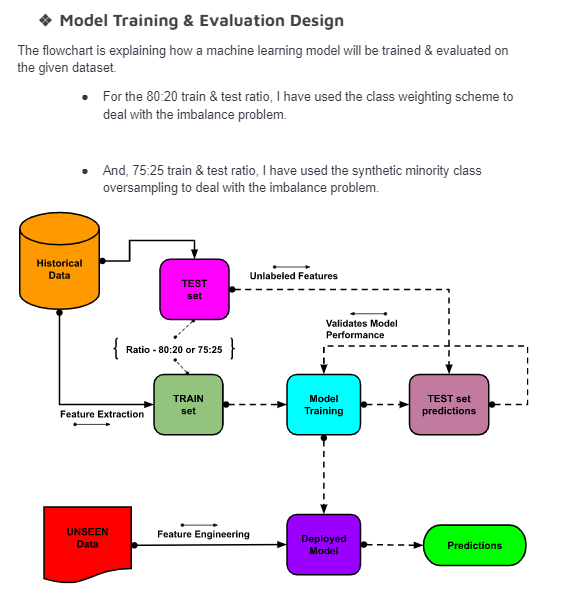

In [520]:
from IPython.display import Image
Image("../input/medicare-prv-fraud-files/Model_Training_and_Validation_Strategy.png")

In [481]:
from sklearn.model_selection import train_test_split as tts

In [482]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, stratify=y, random_state=39)

In [483]:
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4328, 299), (1082, 299), (4328,), (1082,))

In [484]:
# Checking count of tgt labels in y_train
y_train.value_counts()

PotentialFraud
0    3923
1     405
Name: count, dtype: int64

In [485]:
# Checking count of tgt labels in y_test
y_test.value_counts()

PotentialFraud
0    981
1    101
Name: count, dtype: int64

# **`Standardizing TRAIN & TEST sets`** 
## **Bringing every feature into the same scale.**

In [486]:
from sklearn.preprocessing import RobustScaler

In [487]:
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)

# **`Baseline Model Training`**

### **`Using Class Weighting Scheme`**

#### **`1. Logistic Regression`**

In [488]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [489]:
# Training the model with all features and hyper-parameterized values
log_reg_1 = LogisticRegression(C=0.0316228, penalty='l1',
                               fit_intercept=True, solver='liblinear', tol=0.0001, max_iter=500, 
                               class_weight='balanced',
                               verbose=0, 
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_1.fit(X_train_std, y_train)

LogisticRegression(C=0.0316228, class_weight='balanced', intercept_scaling=1.0,
                   max_iter=500, penalty='l1', random_state=49,
                   solver='liblinear')

In [505]:
def pred_prob(clf, data): 
    """
    Description :: This function is created for storing the predicted probabability using the trained model.
    
    Input :: It accepts below input parameters :
      - clf : Trained model classifier
      - data : Dataset for which we want to generate the predictions
    """
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    """
    Description :: This function is created for calculating the AUC score on train and test data. And, plotting the ROC curve.
    
    Input :: It accepts below input parameters :
      - train_fpr : Train False +ve rate
      - train_tpr : Train True +ve rate
      - test_fpr : Test False +ve rate
      - test_tpr : Test True +ve rate
    """
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    with plt.style.context('seaborn-poster'):
      plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc), color='blue')
      plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc), color='red')
      plt.legend()
      plt.xlabel("False Positive Rate(FPR)", fontdict=label_font_dict)
      plt.ylabel("True Positive Rate(TPR)", fontdict=label_font_dict)
      plt.title("Area Under Curve", fontdict=title_font_dict)
      plt.grid(b=True, which='major', color='lightgrey', linestyle='--')
      plt.minorticks_on()
      plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    """
    Description :: This function is created for finding the best threshold value.
    """
    t = threshold[np.argmax(tpr * (1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    """
    Description :: This function is created for generating the predictions based on the best threshold value.
    """
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    """
    Description :: This function is created for plotting the confusion matrix of TRAIN and TEST sets.
    """
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='viridis')
        ax[0].set_title('Train Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[0].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[0].set_ylabel("Actual Label", fontdict=label_font_dict)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='summer')
        ax[1].set_title('Test Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[1].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[1].set_ylabel("Actual Label", fontdict=label_font_dict)
    
    plt.show()
    
    return train_prediction, test_prediction

In [506]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    """
    Description :: This function is created for performing the evaluation of the trained model.
    """
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    
    # calculate tpr, fpr using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("### Train AUC = {}".format(train_auc))
    test_auc = auc(test_fpr, test_tpr)
    print("### Test AUC = {}".format(test_auc))
    
    # plotting the ROC curve
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    # Best threshold value
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    # Plotting the confusion matrices
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    # Generating the F1-scores
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, train_f1_score, test_f1_score, best_t

### Train AUC = 0.947124743912916
### Test AUC = 0.9518575710782087


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

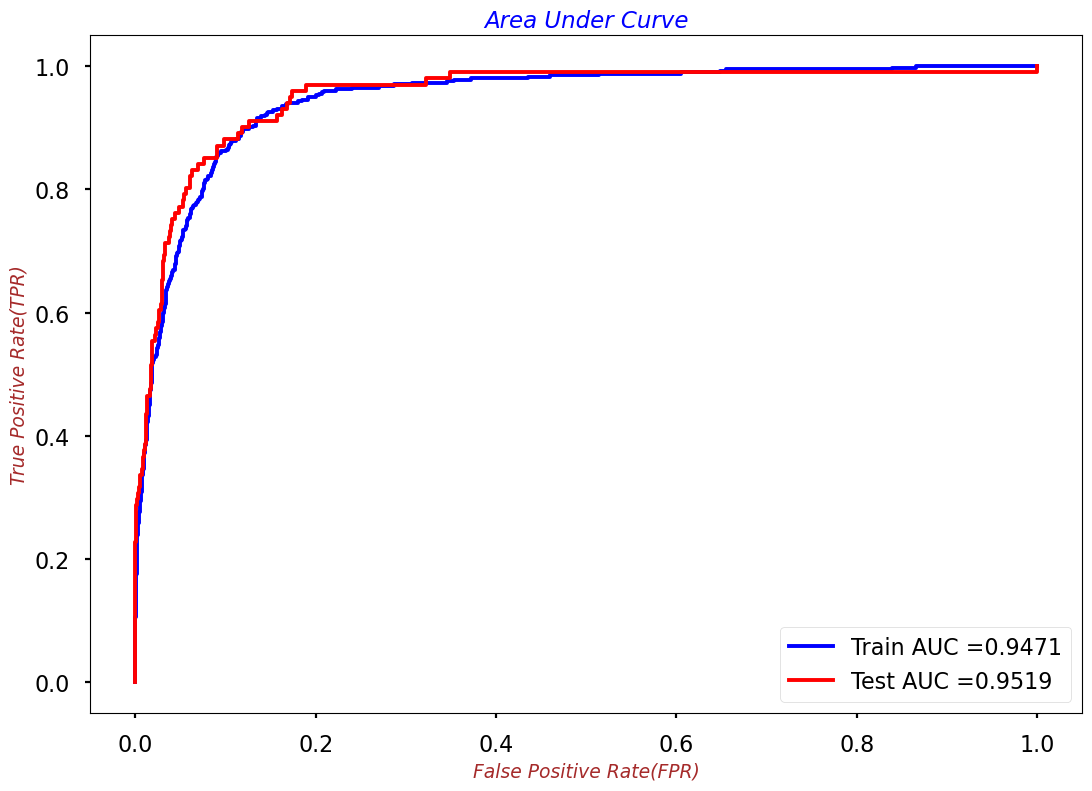

In [507]:
# Validate Logistic Regression model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(log_reg_1, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [ ]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': log_reg_1.coef_[0]})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

In [ ]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

In [ ]:
top_15_neg_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Features'].iloc[0:15]
top_15_neg_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Importance_Model_1'].iloc[0:15]

In [ ]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

In [ ]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_neg_feats, x=top_15_neg_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Negative Features\n", fontdict=title_font_dict)

#### **`2. Decision Tree`**

In [493]:
from sklearn.tree import DecisionTreeClassifier

In [496]:
# Training the model with all features and hyper-parameterized values
dec_tree_2 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='log2',
                                   min_samples_leaf=150,
                                   min_samples_split=150,
                                   class_weight='balanced',
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_2.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       max_features='log2', min_samples_leaf=150,
                       min_samples_split=150, random_state=49)

### Train AUC = 0.9264832595361951
### Test AUC = 0.9259948930672883


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

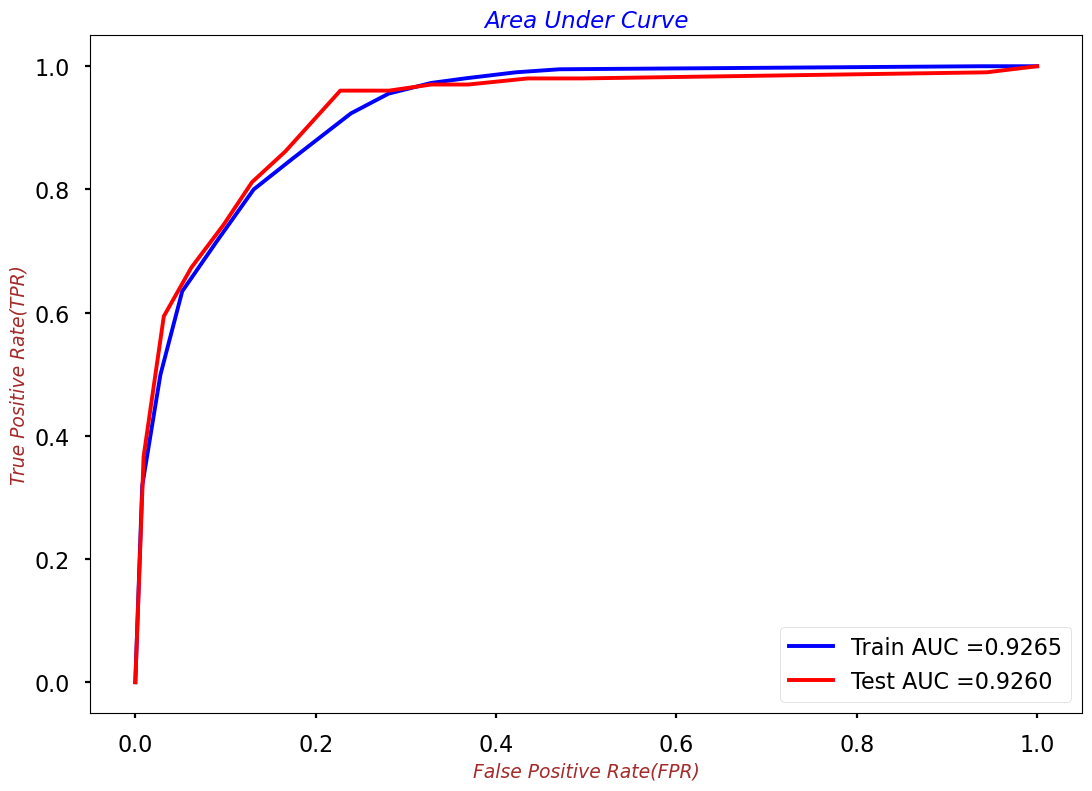

In [501]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(dec_tree_2, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [498]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': dec_tree_2.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,DeductibleAmtPaid,0.040583
1,OPT_PHY_Admit_Duration,0.003299
2,OTH_PHY_Claim_Duration,0.000785
3,Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt,0.700819
4,Claim_Admit_Diag_Code_IP_Annual_Ded_Amt,0.002466


In [542]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

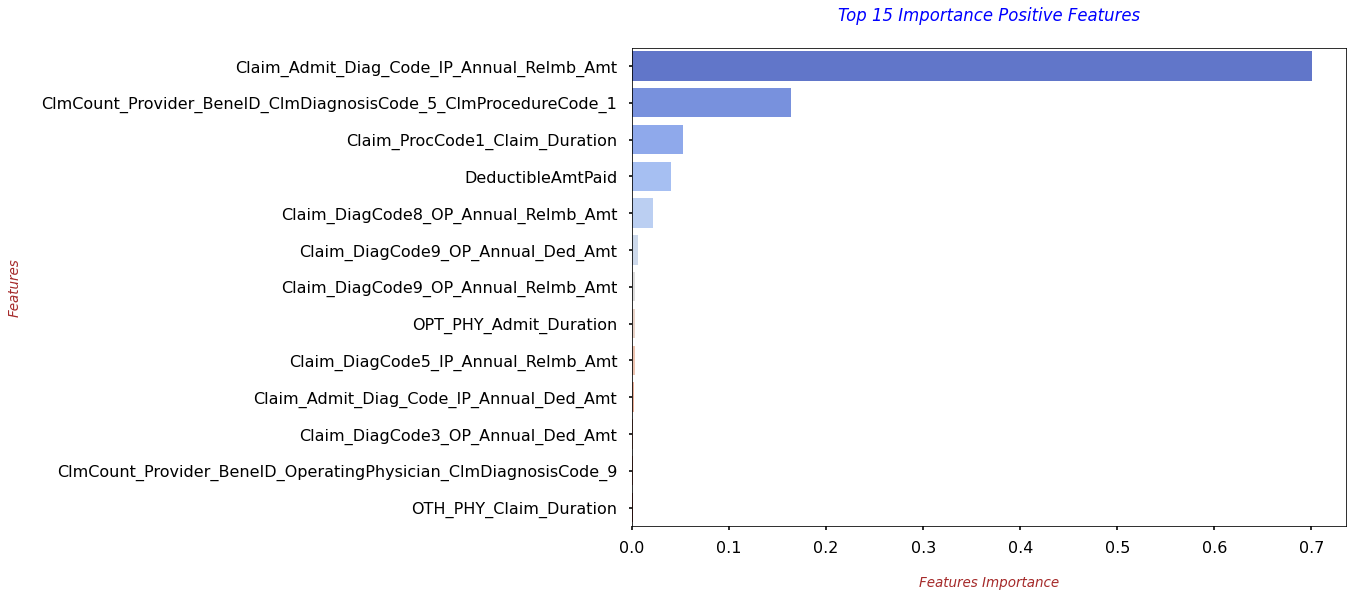

In [543]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

#### **`3. Random Forest Classifier`**

In [502]:
from sklearn.ensemble import RandomForestClassifier

In [504]:
# Training the model with all features and hyper-parameterized values
rfc_3 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=50,
                                   min_samples_split=50,
                                   class_weight='balanced',
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_3.fit(X_train_std, y_train)

InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

### Train AUC = 0.9457812898292124
### Test AUC = 0.9517970145638417


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


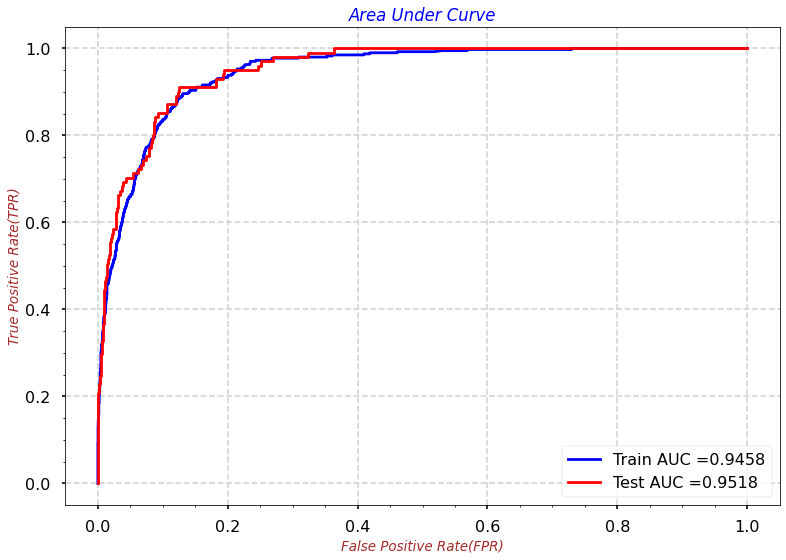

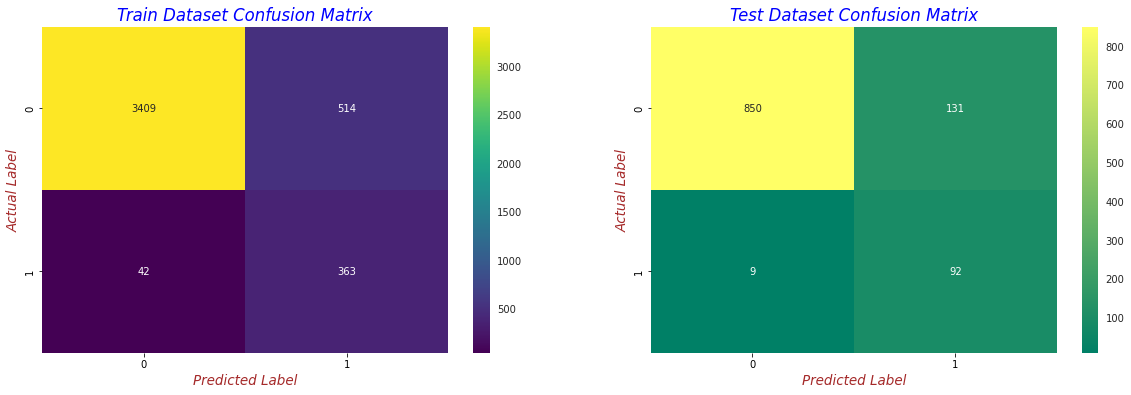



### Best Threshold = 0.5390
### Model AUC is : 0.9518
### Model Train F1 Score is : 0.5663
### Model Test F1 Score is : 0.5679


In [546]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_3, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [547]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_3.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.012603
1,DeductibleAmtPaid,0.028761
2,RenalDiseaseIndicator,0.000322
3,ChronicCond_ObstrPulmonary,0.000937
4,ChronicCond_Diabetes,0.000268


In [548]:
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]

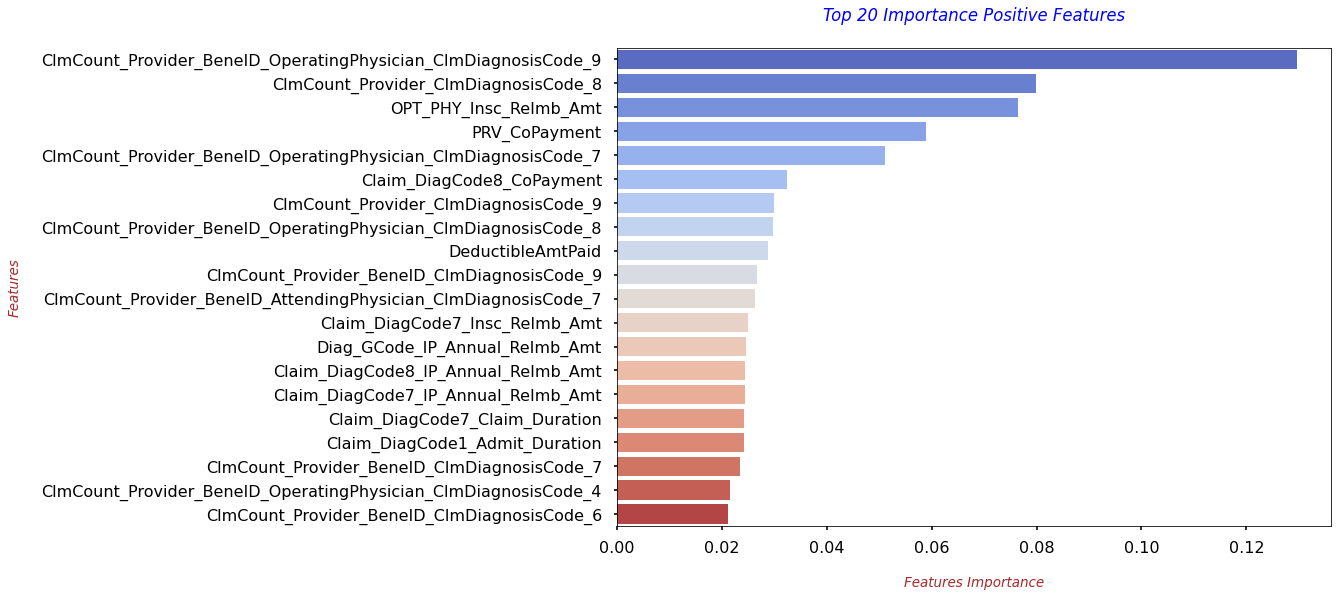

In [549]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_20_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 20 Importance Positive Features\n", fontdict=title_font_dict)

### **`Using Minority Synthetic Oversampling`**

#### **`Train Test Split` :: Creating TRAIN and VALIDATION sets.**

   * **`Reasoning`** :: These sets will be used for measurng the performance of ML Models.

In [550]:
from sklearn.model_selection import train_test_split as tts

In [551]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, stratify=y, random_state=39)

In [552]:
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4057, 299), (1353, 299), (4057,), (1353,))

In [553]:
# Checking count of tgt labels in y_train
y_train.value_counts()

0    3678
1     379
Name: PotentialFraud, dtype: int64

In [554]:
# Checking count of tgt labels in y_test
y_test.value_counts()

0    1226
1     127
Name: PotentialFraud, dtype: int64

#### **`Standardizing the TRAIN & TEST sets` :: Bringing every feature into the same scale.**

In [555]:
from sklearn.preprocessing import RobustScaler

In [556]:
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)

In [557]:
from collections import Counter

In [558]:
# BEFORE Oversampling :: Checking the percentage share of fraud and non-fraud records in the TRAIN set
counter = Counter(y_train)
counter

Counter({0: 3678, 1: 379})

In [559]:
fraud_percentage = (counter[1]*100 / (counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100 / (counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.34% and Non-Fraud Percentage = 90.66%


In [560]:
# Performing minority oversampling
from imblearn.over_sampling import ADASYN

In [561]:
oversample = ADASYN(sampling_strategy=0.35, n_neighbors=12)
X_train_ovsamp, y_train_ovsamp = oversample.fit_resample(X_train_std, y_train)

X_train_ovsamp.shape, y_train_ovsamp.shape

((4983, 299), (4983,))

In [562]:
counter = Counter(y_train_ovsamp)
counter

Counter({0: 3678, 1: 1305})

In [563]:
fraud_percentage = (counter[1]*100 / (counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100 / (counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 26.19% and Non-Fraud Percentage = 73.81%


#### **`4. Logistic Regression`**

In [564]:
# Training the model with all features and hyper-parameterized values
log_reg_4 = LogisticRegression(C=0.0316228, penalty='l1',
                               fit_intercept=True, 
                               solver='liblinear', 
                               tol=0.0001, 
                               max_iter=500, 
                               verbose=0, 
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_4.fit(X_train_ovsamp, y_train_ovsamp)

LogisticRegression(C=0.0316228, intercept_scaling=1.0, max_iter=500,
                   penalty='l1', random_state=49, solver='liblinear')

### Train AUC = 0.9395194373087157
### Test AUC = 0.9418183453006385


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


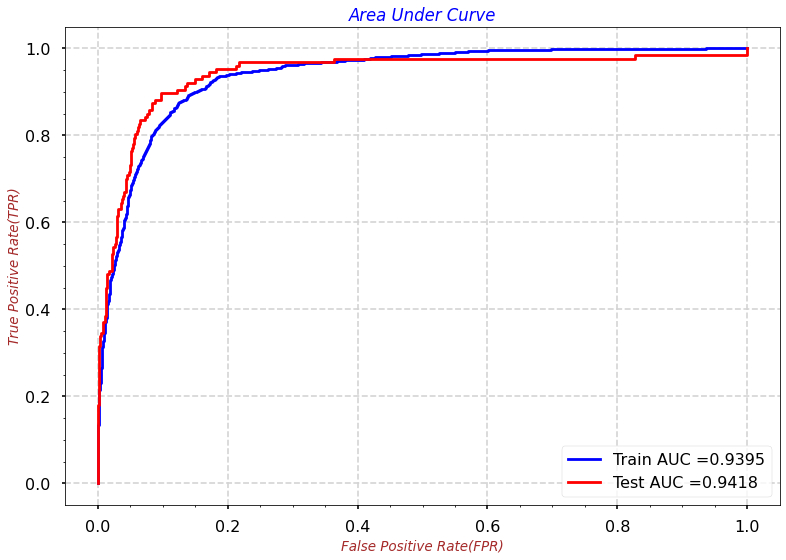

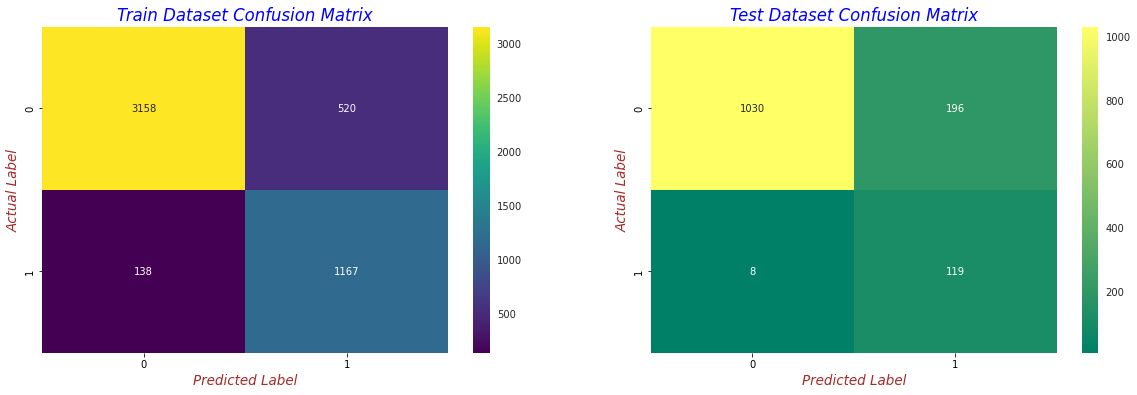



### Best Threshold = 0.1898
### Model AUC is : 0.9418
### Model Train F1 Score is : 0.7801
### Model Test F1 Score is : 0.5385


In [565]:
# Validate Logistic Regression model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(log_reg_4, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [566]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': log_reg_4.coef_[0]})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.722834
1,ChronicCond_stroke,0.047096
2,Admitted_Duration,0.489483
3,PRV_Tot_DGrpCodes,-0.006593
4,PRV_Tot_Unq_DOB_Years,-0.298081


In [567]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

In [568]:
top_15_neg_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Features'].iloc[0:15]
top_15_neg_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Importance_Model_1'].iloc[0:15]

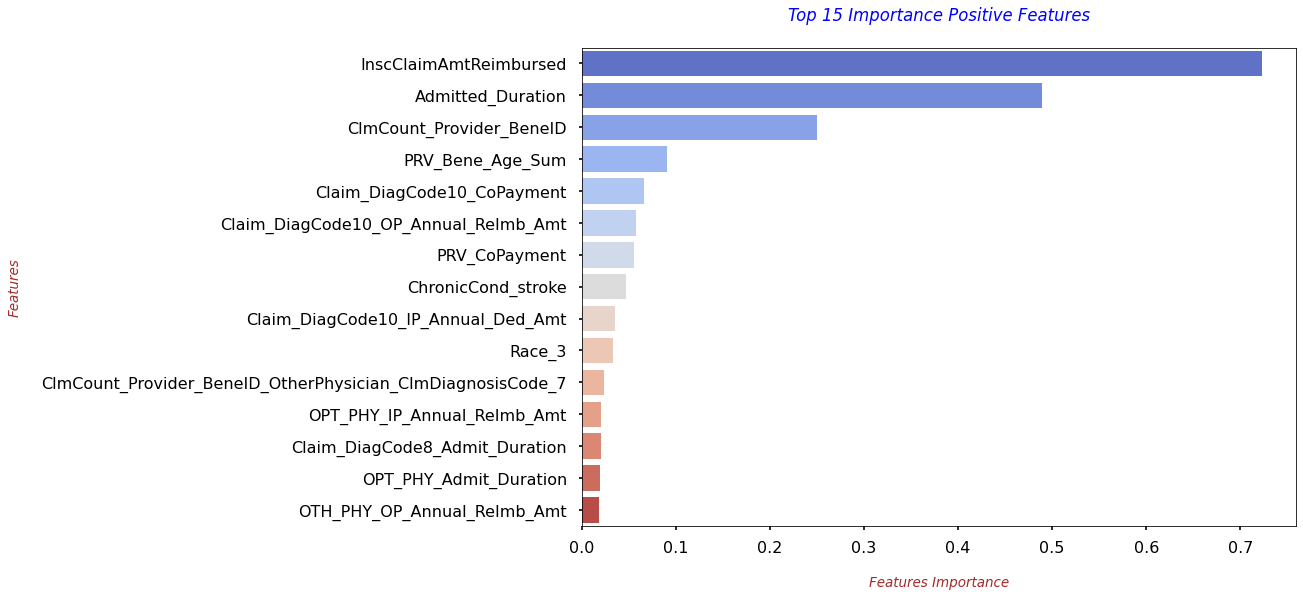

In [569]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

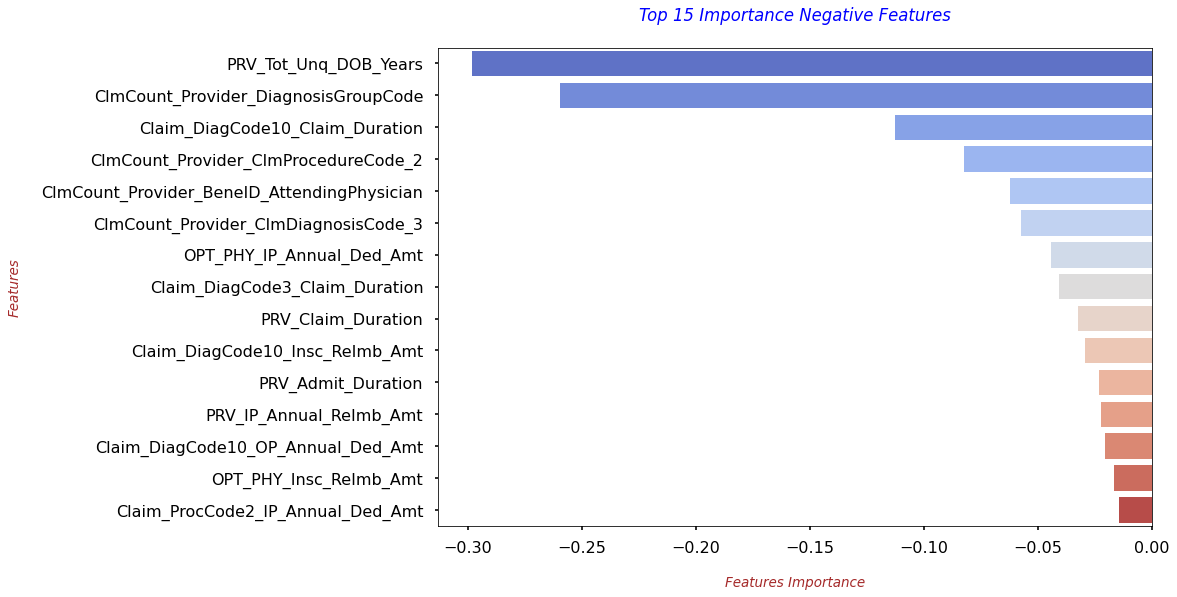

In [570]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_neg_feats, x=top_15_neg_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Negative Features\n", fontdict=title_font_dict)

#### **`5. Decision Tree`**

In [571]:
from sklearn.tree import DecisionTreeClassifier

In [572]:
# Training the model with all features and hyper-parameterized values
dec_tree_5 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='log2',
                                   min_samples_leaf=150,
                                   min_samples_split=150,
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_5.fit(X_train_ovsamp, y_train_ovsamp)

DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_leaf=150,
                       min_samples_split=150, random_state=49)

### Train AUC = 0.9235104035801567
### Test AUC = 0.9372422961811666


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


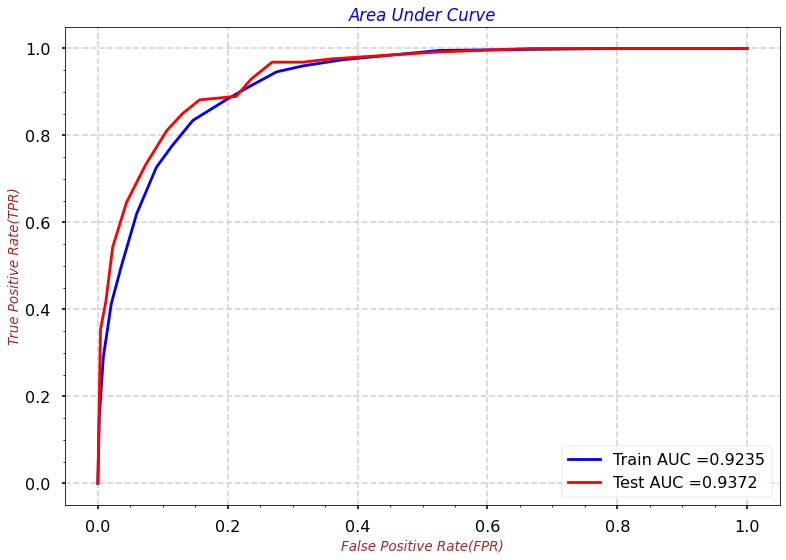

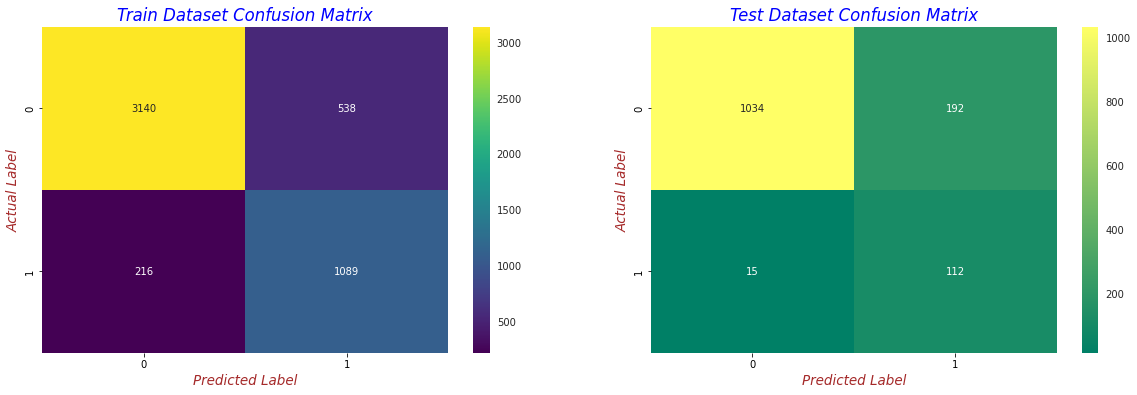



### Best Threshold = 0.3929
### Model AUC is : 0.9372
### Model Train F1 Score is : 0.7428
### Model Test F1 Score is : 0.5197


In [573]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(dec_tree_5, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [574]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': dec_tree_5.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,DeductibleAmtPaid,0.053100
1,IPAnnualDeductibleAmt,0.000019
2,OPT_PHY_OP_Annual_Ded_Amt,0.004203
3,OTH_PHY_OP_Annual_ReImb_Amt,0.000965
4,Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt,0.639877


In [575]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

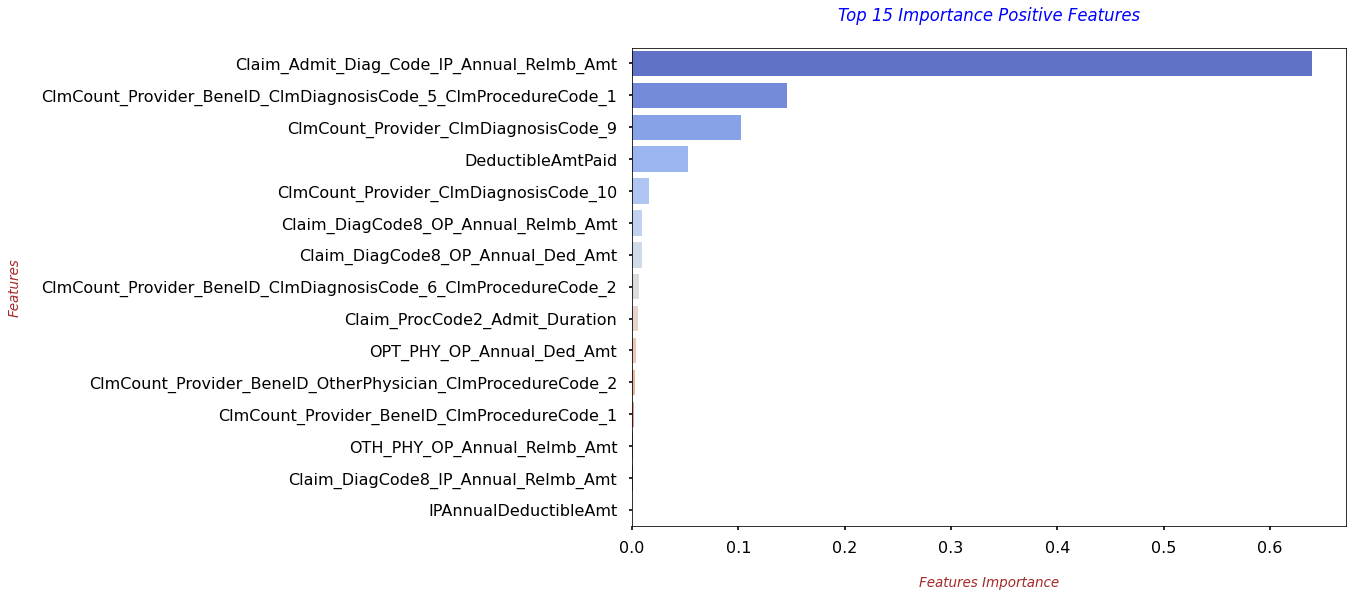

In [576]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

#### **`6. Random Forest Classifier`**

In [577]:
from sklearn.ensemble import RandomForestClassifier

In [578]:
# Training the model with all features and hyper-parameterized values
rfc_6 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=50,
                                   min_samples_split=50,
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_6.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=49)

### Train AUC = 0.9236866612914314
### Test AUC = 0.9487289822866759


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


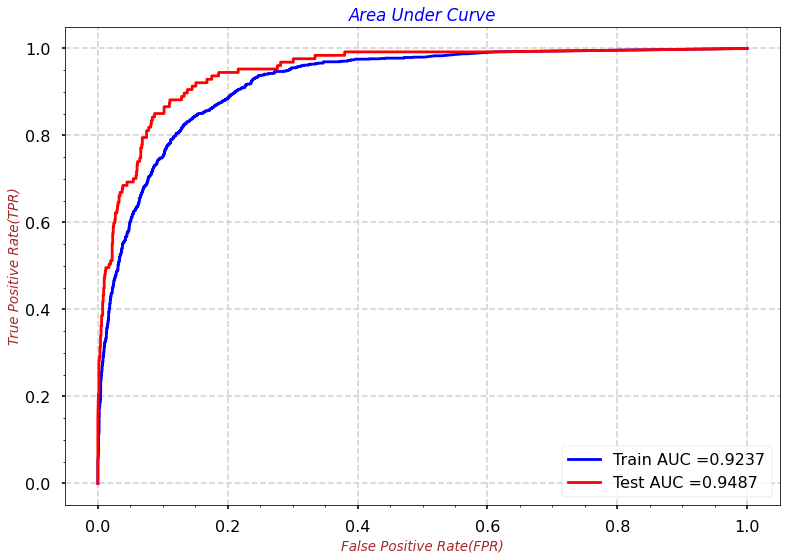

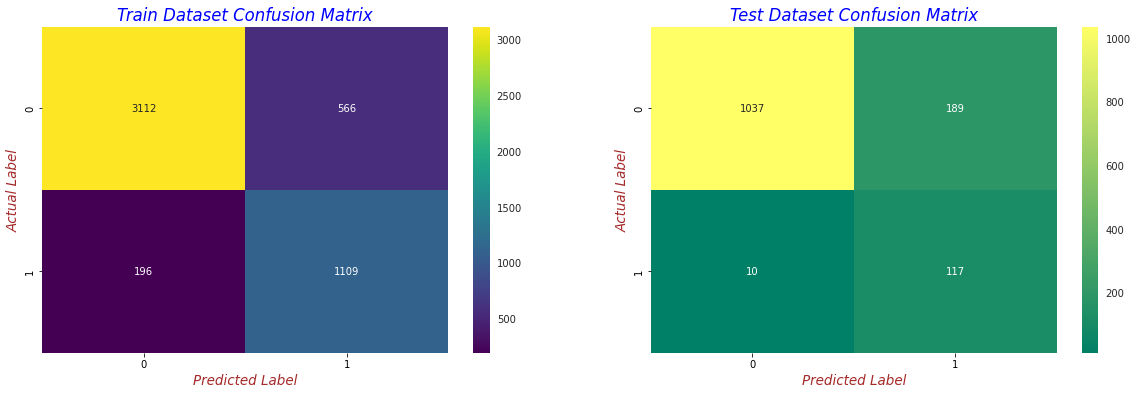



### Best Threshold = 0.1089
### Model AUC is : 0.9487
### Model Train F1 Score is : 0.7443
### Model Test F1 Score is : 0.5404


In [579]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_6, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [580]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_6.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.032471
1,DeductibleAmtPaid,0.005630
2,RenalDiseaseIndicator,0.000265
3,ChronicCond_Alzheimer,0.000079
4,IPAnnualReimbursementAmt,0.003554


In [581]:
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]

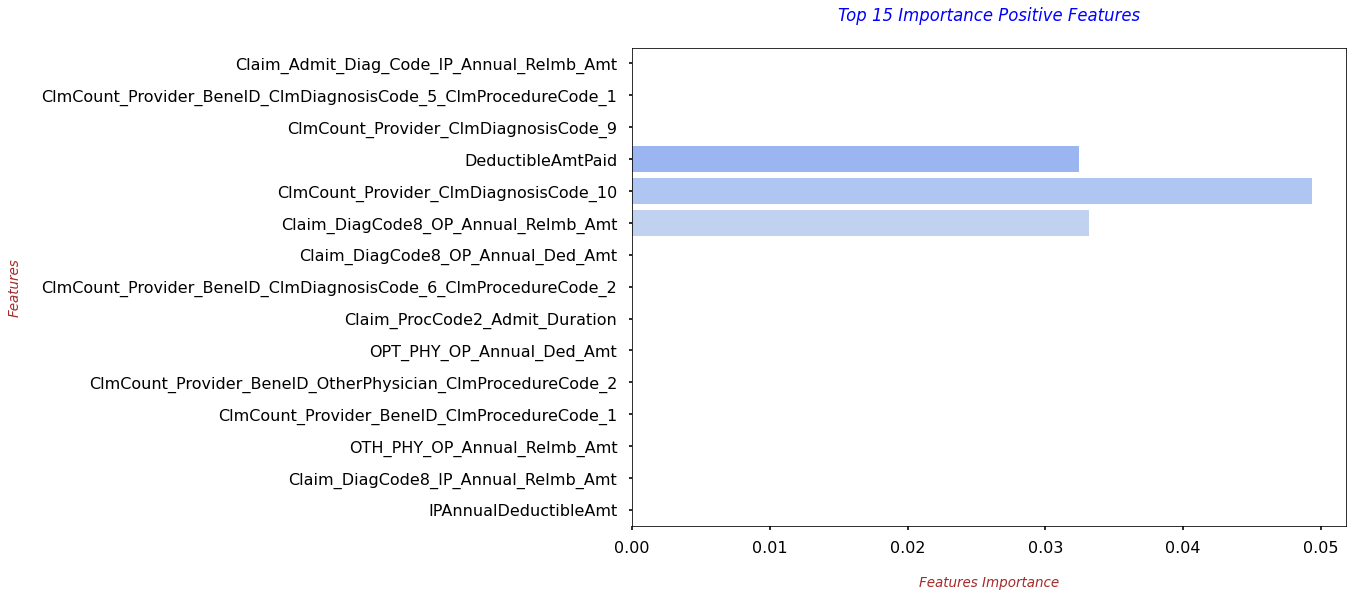

In [582]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

# **`Models - SET 1 - RESULTS`**
- Best performing model highlighted in light yellow in the below table.

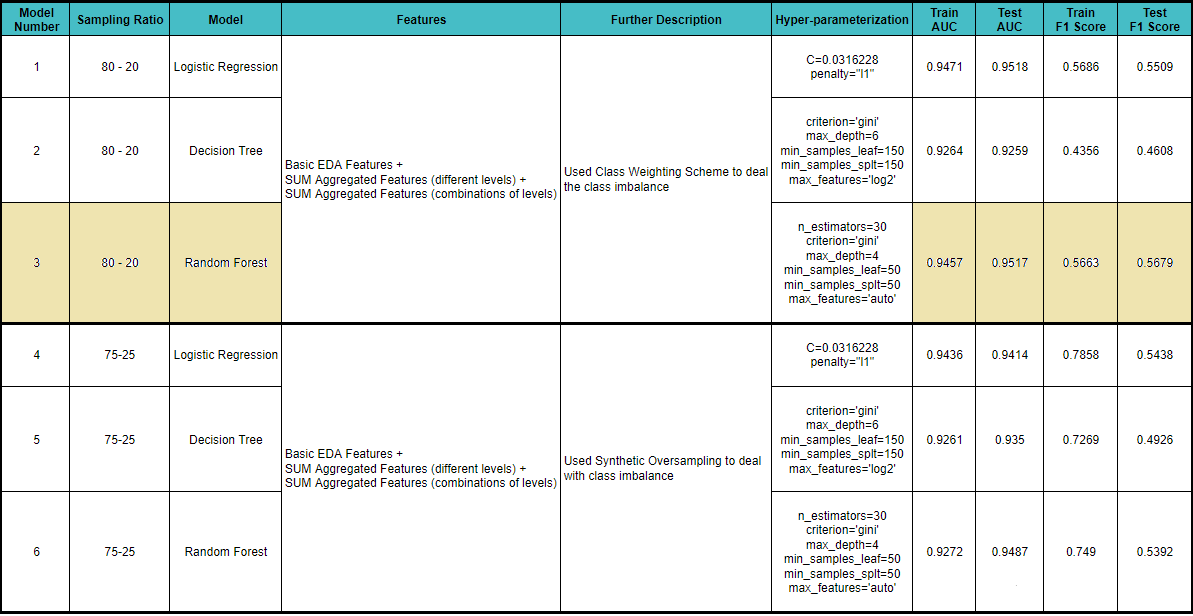

In [583]:
from IPython.display import Image
Image("../input/medicare-prv-fraud-files/Models_Set_1_Results.png")

## **`Models - SET 1 - OBSERVATIONS`**

- **Adding Aggregated features at below mentioned levels certainly helped in achieving the good performance scores.**
    - Provider
    - Beneficiary
    - Attending Physician
    - Operating Physician
    - Other Physician and etc..
    
    
- **Adding below mentioned Aggregated features in order to capture the interactions b/w the different parties involved in the CLAIM process certainly helped in achieving the good performance scores.**  
    - PROVIDER <--> BENE <--> PHYSICIANS
    - PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES and etc..
    

- **Doing the synthetic oversampling of the minority class doesn't provide gain in the model's performance whehreas we can see a slight drop in the performace.** 

# **Feature Engg - SET 2**

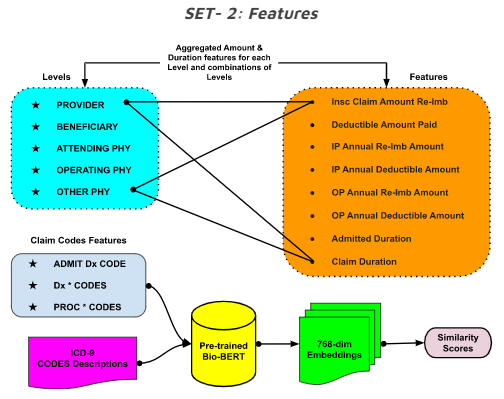

In [584]:
from IPython.display import Image
Image("../input/medicare-prv-fraud-files/Feat_Engg_SET2.png")

In [585]:
train_bene_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Outpatientdata-1542865627584.csv")
train_tgt_lbls_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train-1542865627584.csv")

In [586]:
test_bene_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Test_Beneficiarydata-1542969243754.csv")
test_ip_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Test_Inpatientdata-1542969243754.csv")
test_op_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Test_Outpatientdata-1542969243754.csv")
test_tgt_lbls_df = pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Test-1542969243754.csv")

## ***Exploring_Target_Labels_Data***

In [587]:
train_tgt_lbls_df.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [588]:
test_tgt_lbls_df.head()

,Provider
0,PRV51002
1,PRV51006
2,PRV51009
3,PRV51010
4,PRV51018


* **Check the Fraud and Non-Fraud Counts**

In [589]:
print("### The unique number of train providers are {}. ###".format(train_tgt_lbls_df.shape[0]))

### The unique number of train providers are 5410. ###


In [590]:
print("### The unique number of test providers are {}. ###".format(test_tgt_lbls_df.shape[0]))

### The unique number of test providers are 1353. ###


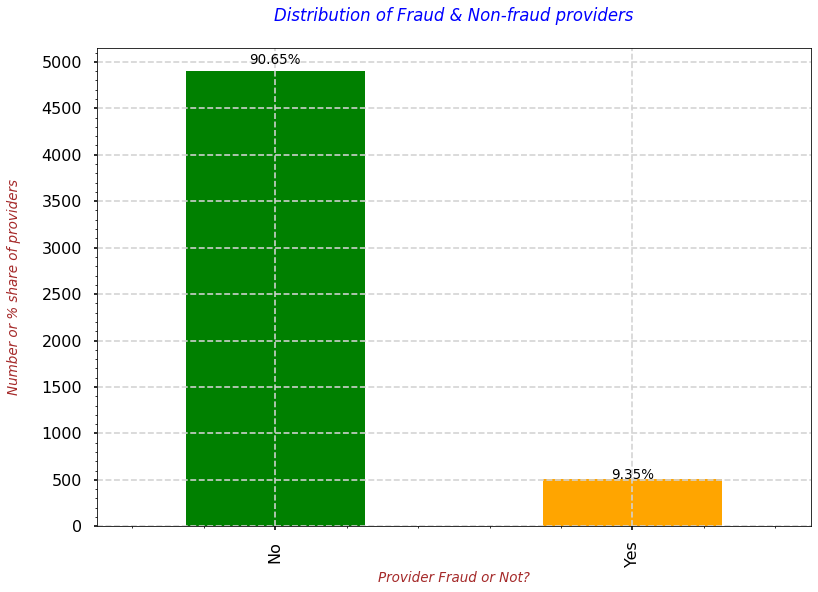

In [591]:
with plt.style.context('seaborn-poster'):
    fig = train_tgt_lbls_df["PotentialFraud"].value_counts().plot(kind='bar', color=['green','orange'])
    # Using the "patches" function we will get the location of the rectangle bars from the graph.
    ## Then by using those location(width & height) values we will add the annotations
    for p in fig.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        fig.annotate(f'{str(round((height*100)/train_tgt_lbls_df.shape[0],2))+"%"}', (x + width/2, y + height*1.015), ha='center', fontsize=13.5)
    # Providing the labels and title to the graph
    plt.xlabel("Provider Fraud or Not?", fontdict=label_font_dict)
    plt.ylabel("Number or % share of providers\n", fontdict=label_font_dict)
    plt.yticks(np.arange(0,5100,500))
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("Distribution of Fraud & Non-fraud providers\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* From the above plot, we can say that 90% of the providers are not frausters and only 9% of them are involved in frauds.

- **Removing some entirely NULL Procedure Codes Features**

- TRAIN Set

In [592]:
train_ip_df.shape, train_op_df.shape

((40474, 30), (517737, 27))

In [593]:
(train_ip_df['ClmProcedureCode_4'].isna().sum() / train_ip_df.shape[0])*100,\
(train_ip_df['ClmProcedureCode_5'].isna().sum() / train_ip_df.shape[0])*100,\
(train_ip_df['ClmProcedureCode_6'].isna().sum() / train_ip_df.shape[0])*100

(99.71339625438553, 99.97776350249543, 100.0)

In [594]:
(train_op_df['ClmProcedureCode_4'].isna().sum() / train_op_df.shape[0])*100,\
(train_op_df['ClmProcedureCode_5'].isna().sum() / train_op_df.shape[0])*100,\
(train_op_df['ClmProcedureCode_6'].isna().sum() / train_op_df.shape[0])*100

(99.99961370348267, 100.0, 100.0)

- Unseen Set

In [595]:
test_ip_df.shape, test_op_df.shape

((9551, 30), (125841, 27))

In [596]:
(test_ip_df['ClmProcedureCode_4'].isna().sum() / test_ip_df.shape[0])*100,\
(test_ip_df['ClmProcedureCode_5'].isna().sum() / test_ip_df.shape[0])*100,\
(test_ip_df['ClmProcedureCode_6'].isna().sum() / test_ip_df.shape[0])*100

(99.69636687257879, 99.97905978431578, 100.0)

In [597]:
(test_op_df['ClmProcedureCode_4'].isna().sum() / test_op_df.shape[0])*100,\
(test_op_df['ClmProcedureCode_5'].isna().sum() / test_op_df.shape[0])*100,\
(test_op_df['ClmProcedureCode_6'].isna().sum() / test_op_df.shape[0])*100

(100.0, 100.0, 100.0)

- **Removing the above columns**

In [598]:
train_ip_df.drop(['ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6'],axis=1,inplace=True)
train_op_df.drop(['ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6'],axis=1,inplace=True)

In [599]:
test_ip_df.drop(['ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6'],axis=1,inplace=True)
test_op_df.drop(['ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6'],axis=1,inplace=True)

In [600]:
# Converting the PROC CODES into STRING format
train_ip_df['ClmProcedureCode_1'] = train_ip_df['ClmProcedureCode_1'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
train_ip_df['ClmProcedureCode_2'] = train_ip_df['ClmProcedureCode_2'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
train_ip_df['ClmProcedureCode_3'] = train_ip_df['ClmProcedureCode_3'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)

train_op_df['ClmProcedureCode_1'] = train_op_df['ClmProcedureCode_1'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
train_op_df['ClmProcedureCode_2'] = train_op_df['ClmProcedureCode_2'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
train_op_df['ClmProcedureCode_3'] = train_op_df['ClmProcedureCode_3'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)

In [601]:
# Converting the PROC CODES into STRING format
test_ip_df['ClmProcedureCode_1'] = test_ip_df['ClmProcedureCode_1'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
test_ip_df['ClmProcedureCode_2'] = test_ip_df['ClmProcedureCode_2'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
test_ip_df['ClmProcedureCode_3'] = test_ip_df['ClmProcedureCode_3'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)

test_op_df['ClmProcedureCode_1'] = test_op_df['ClmProcedureCode_1'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
test_op_df['ClmProcedureCode_2'] = test_op_df['ClmProcedureCode_2'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)
test_op_df['ClmProcedureCode_3'] = test_op_df['ClmProcedureCode_3'].apply(lambda val: str(val).split(".")[0] if val == val else np.NaN)

### **Adding `New Feature - 1` :: `Admitted` or `Not Admitted` indicator in IP and OP Dataset**

* **Adding in IP Dataset**

In [602]:
train_ip_df["Admitted?"] = 1

In [603]:
test_ip_df["Admitted?"] = 1

In [604]:
train_ip_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,Admitted?
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893,NaN,NaN,1


In [605]:
test_ip_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,Admitted?
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,5789,1068.0,2009-09-16,332,5780,5533,496,V420,40390,2851,5990,570,41071,4280,4443,5849,NaN,1
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,5939,1068.0,2009-01-08,661,1889,41071,5990,5601,4588,5845,4549,29570,34831,NaN,5551,NaN,NaN,1
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,4019,1068.0,2009-12-13,241,4010,78791,60000,41401,V1254,4372,78650,7813,4254,NaN,NaN,NaN,NaN,1
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,8208,1068.0,2009-07-06,564,8208,4168,920,5990,40391,2859,4254,41400,5849,41401,8152,3320,NaN,1
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,4279,1068.0,2009-01-31,880,29654,V142,78702,30503,V140,V4582,V6109,7242,NaN,NaN,NaN,NaN,NaN,1


* **Adding in OP Dataset**

In [606]:
train_op_df["Admitted?"] = 0

In [607]:
test_op_df["Admitted?"] = 0

In [608]:
train_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Admitted?
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0


In [609]:
test_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Admitted?
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,V5861,2724,3182,V5869,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,E9174,4019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,2449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5939,0
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


### **Merging the Datasets**

In [610]:
# Commom columns must be 28
common_cols_tr = [col for col in train_ip_df.columns if col in train_op_df.columns]
len(common_cols_tr)

25

In [611]:
# Merging the IP and OP dataset on the basis of common columns
train_ip_op_df = pd.merge(left=train_ip_df, right=train_op_df, left_on=common_cols_tr, right_on=common_cols_tr, how="outer")
train_ip_op_df.shape

(558211, 28)

In [612]:
# Merging the IP and OP dataset on the basis of common columns
test_ip_op_df = pd.merge(left=test_ip_df, right=test_op_df, left_on=common_cols_tr, right_on=common_cols_tr, how="outer")
test_ip_op_df.shape

(135392, 28)

In [613]:
train_ip_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,Admitted?
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893,NaN,NaN,1


In [614]:
test_ip_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,Admitted?
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,5789,1068.0,2009-09-16,332,5780,5533,496,V420,40390,2851,5990,570,41071,4280,4443,5849,NaN,1
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,5939,1068.0,2009-01-08,661,1889,41071,5990,5601,4588,5845,4549,29570,34831,NaN,5551,NaN,NaN,1
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,4019,1068.0,2009-12-13,241,4010,78791,60000,41401,V1254,4372,78650,7813,4254,NaN,NaN,NaN,NaN,1
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,8208,1068.0,2009-07-06,564,8208,4168,920,5990,40391,2859,4254,41400,5849,41401,8152,3320,NaN,1
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,4279,1068.0,2009-01-31,880,29654,V142,78702,30503,V140,V4582,V6109,7242,NaN,NaN,NaN,NaN,NaN,1


### **Merging the IP_OP Dataset with BENE Data**

In [615]:
# Joining the IP_OP dataset with the BENE data
train_ip_op_bene_df = pd.merge(left=train_ip_op_df, right=train_bene_df, left_on='BeneID', right_on='BeneID',how='inner')
train_ip_op_bene_df.shape

(558211, 52)

In [616]:
# Joining the IP_OP dataset with the BENE data
test_ip_op_bene_df = pd.merge(left=test_ip_op_df, right=test_bene_df, left_on='BeneID', right_on='BeneID',how='inner')
test_ip_op_bene_df.shape

(135392, 52)

### **Merging the IP_OP_BENE Dataset with PROVIDER level Tgt Labels Data**

In [617]:
# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
train_iobp_df = pd.merge(left=train_ip_op_bene_df, right=train_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')
train_iobp_df.shape

(558211, 53)

In [618]:
# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
test_iobp_df = pd.merge(left=test_ip_op_bene_df, right=test_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')
test_iobp_df.shape

(135392, 52)

### **Entire Dataset**

In [619]:
train_iobp_df.shape

(558211, 53)

In [620]:
test_iobp_df.shape

(135392, 52)

In [621]:
# Unique Providers
train_iobp_df["Provider"].nunique()

5410

In [622]:
# Unique Providers
test_iobp_df["Provider"].nunique()

1353

In [623]:
# Unique Claim numbers
train_iobp_df["ClaimID"].nunique()

558211

In [624]:
# Unique Claim numbers
test_iobp_df["ClaimID"].nunique()

135392

In [625]:
# Joining with the PRV Tgt Labels
prvs_claims_df = pd.DataFrame(train_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=train_tgt_lbls_df, on='Provider', how='inner')
prvs_claims_tgt_lbls_df

,Provider,ClaimID,PotentialFraud
0,PRV51001,25,No
1,PRV51003,132,Yes
2,PRV51004,149,No
3,PRV51005,1165,Yes
4,PRV51007,72,No
...,...,...,...
5405,PRV57759,28,No
5406,PRV57760,22,No
5407,PRV57761,82,No
5408,PRV57762,1,No


In [626]:
# Joining with the PRV Tgt Labels
prvs_claims_df = pd.DataFrame(test_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=test_tgt_lbls_df, on='Provider', how='inner')
prvs_claims_tgt_lbls_df

,Provider,ClaimID
0,PRV51002,205
1,PRV51006,102
2,PRV51009,39
3,PRV51010,38
4,PRV51018,190
...,...,...
1348,PRV57713,11
1349,PRV57726,8
1350,PRV57745,2
1351,PRV57749,49


- **Fraud Count at Claims level**

     PotentialFraud
No           345415
Yes          212796 



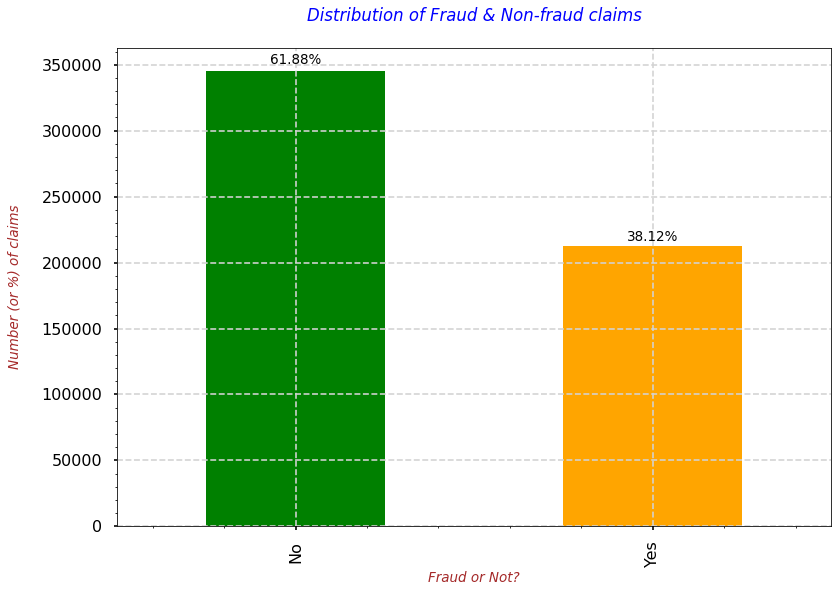

In [627]:
print(pd.DataFrame(train_iobp_df['PotentialFraud'].value_counts()), "\n")

with plt.style.context('seaborn-poster'):
    fig = train_iobp_df['PotentialFraud'].value_counts().plot(kind='bar', color=['green','orange'])
    # Using the "patches" function we will get the location of the rectangle bars from the graph.
    ## Then by using those location(width & height) values we will add the annotations
    for p in fig.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        fig.annotate(f'{str(round((height*100)/train_iobp_df.shape[0],2))+"%"}', (x + width/2, y + height*1.015), ha='center', fontsize=13.5)
    # Providing the labels and title to the graph
    plt.xlabel("Fraud or Not?", fontdict=label_font_dict)
    plt.ylabel("Number (or %) of claims\n", fontdict=label_font_dict)
    plt.grid(which='major', linestyle="--", color='lightgrey')
    plt.minorticks_on()
    plt.title("Distribution of Fraud & Non-fraud claims\n", fontdict=title_font_dict)
    plt.plot();

**`OBSERVATION`**
* The above plot shows us that, 62% of claims are Non-Fraud and 32% of them are Fraudulent. 
    * By looking at the percentages we may say that there is a class-imbalance problem but after looking at the number of records it doesn't seem to be a severe class-imbalance problem. 
        * So, I'll try some class balancing techniques only after training a baseline model w/o any synthetic or class weighting techniques.

# **`VECTOR Embeddings`**

- Generating the vector embeddings of ::
    - `CLAIM Admit Diagnosis Codes`
    - `Diagnosis Codes`
    - `Procedure Codes`


- For now, I'm not including the `Dx Related Group Code` for generating the similarity score b/w these features.

In [628]:
import pickle 

# Loading the embeddings of CAD, DIAG and PROC codes
## Sentence embeddings are generated from the pre-trained Bio-BERT on PubMed and PMC datasets
### Dx and Proc Codes are downloaded from ICD-9 portal Effective from 2014
#### Refer Notebook --> CS_1_Codes_Desc_Embeddings.ipynb
with open('../input/medicare-prv-fraud-files/cad_diag_codes_embeddings.pkl', 'rb') as f:
    loaded_cad_dict = pickle.load(f)

with open('../input/medicare-prv-fraud-files/proc_codes_embeddings.pkl', 'rb') as f:
    loaded_proc_dict = pickle.load(f)

In [629]:
zeros_vec = np.zeros(shape=(1,768),dtype='float')

In [630]:
# Fetching the embeddings of every CAD and Dx CODE
train_iobp_df['Clm_Admit_Dx_embeddings'] = train_iobp_df['ClmAdmitDiagnosisCode'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_1_embeddings'] = train_iobp_df['ClmDiagnosisCode_1'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_2_embeddings'] = train_iobp_df['ClmDiagnosisCode_2'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_3_embeddings'] = train_iobp_df['ClmDiagnosisCode_3'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_4_embeddings'] = train_iobp_df['ClmDiagnosisCode_4'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_5_embeddings'] = train_iobp_df['ClmDiagnosisCode_5'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_6_embeddings'] = train_iobp_df['ClmDiagnosisCode_6'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_7_embeddings'] = train_iobp_df['ClmDiagnosisCode_7'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_8_embeddings'] = train_iobp_df['ClmDiagnosisCode_8'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_9_embeddings'] = train_iobp_df['ClmDiagnosisCode_9'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_Dx_10_embeddings'] = train_iobp_df['ClmDiagnosisCode_10'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))

In [631]:
# Fetching the embeddings of every CAD and Dx CODE
test_iobp_df['Clm_Admit_Dx_embeddings'] = test_iobp_df['ClmAdmitDiagnosisCode'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_1_embeddings'] = test_iobp_df['ClmDiagnosisCode_1'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_2_embeddings'] = test_iobp_df['ClmDiagnosisCode_2'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_3_embeddings'] = test_iobp_df['ClmDiagnosisCode_3'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_4_embeddings'] = test_iobp_df['ClmDiagnosisCode_4'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_5_embeddings'] = test_iobp_df['ClmDiagnosisCode_5'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_6_embeddings'] = test_iobp_df['ClmDiagnosisCode_6'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_7_embeddings'] = test_iobp_df['ClmDiagnosisCode_7'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_8_embeddings'] = test_iobp_df['ClmDiagnosisCode_8'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_9_embeddings'] = test_iobp_df['ClmDiagnosisCode_9'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_Dx_10_embeddings'] = test_iobp_df['ClmDiagnosisCode_10'].apply(lambda code: loaded_cad_dict.get(code,zeros_vec[0]))

In [632]:
# Adding the embeddings of all the Dx Codes for every claim
train_iobp_df['Clm_All_Dx_embeddings'] = train_iobp_df[['Clm_Dx_1_embeddings','Clm_Dx_2_embeddings','Clm_Dx_3_embeddings','Clm_Dx_4_embeddings','Clm_Dx_5_embeddings','Clm_Dx_6_embeddings','Clm_Dx_7_embeddings','Clm_Dx_8_embeddings','Clm_Dx_9_embeddings','Clm_Dx_10_embeddings']]\
.apply(lambda row : row['Clm_Dx_1_embeddings'] + row['Clm_Dx_2_embeddings'] + row['Clm_Dx_3_embeddings'] + row['Clm_Dx_4_embeddings'] + row['Clm_Dx_5_embeddings'] + row['Clm_Dx_6_embeddings'] + row['Clm_Dx_7_embeddings'] + row['Clm_Dx_8_embeddings'] + row['Clm_Dx_9_embeddings'] + row['Clm_Dx_10_embeddings'], axis=1)

In [633]:
# Final embeddings of all the Dx Codes for every claim
train_iobp_df['Clm_All_Dx_embeddings']

0         [0.9678052412346005, 1.6423875028267503, -1.30...
1         [1.30414180457592, 1.4621049482375383, -1.3063...
2         [0.8069967683404684, 1.3780399085953832, -1.21...
3         [1.0197997465729713, 1.4949923837557435, -0.58...
4         [1.2688028439879417, 0.9786814162507653, -0.30...
                                ...                        
558206    [0.6410285793244839, 0.139002975076437, -0.414...
558207    [0.29387184977531433, 0.032951388508081436, -0...
558208    [0.1727948859333992, 0.6853120625019073, -0.45...
558209    [0.1868998408317566, 0.3849315941333771, -0.16...
558210    [0.09751432272605598, 0.26662084460258484, -0....
Name: Clm_All_Dx_embeddings, Length: 558211, dtype: object

In [634]:
# Adding the embeddings of all the Dx Codes for every claim
test_iobp_df['Clm_All_Dx_embeddings'] = test_iobp_df[['Clm_Dx_1_embeddings','Clm_Dx_2_embeddings','Clm_Dx_3_embeddings','Clm_Dx_4_embeddings','Clm_Dx_5_embeddings','Clm_Dx_6_embeddings','Clm_Dx_7_embeddings','Clm_Dx_8_embeddings','Clm_Dx_9_embeddings','Clm_Dx_10_embeddings']]\
.apply(lambda row : row['Clm_Dx_1_embeddings'] + row['Clm_Dx_2_embeddings'] + row['Clm_Dx_3_embeddings'] + row['Clm_Dx_4_embeddings'] + row['Clm_Dx_5_embeddings'] + row['Clm_Dx_6_embeddings'] + row['Clm_Dx_7_embeddings'] + row['Clm_Dx_8_embeddings'] + row['Clm_Dx_9_embeddings'] + row['Clm_Dx_10_embeddings'], axis=1)

In [635]:
# Final embeddings of all the Dx Codes for every claim
test_iobp_df['Clm_All_Dx_embeddings']

0         [0.6438316721469164, 2.163996056653559, -1.585...
1         [1.3458348102867603, 1.3714876929298043, -0.68...
2         [1.3597857274580747, 1.0866809133440256, -1.02...
3         [1.209467918612063, 1.0890447879210114, -0.271...
4         [0.5807230211794376, 1.6170704737305641, -0.99...
                                ...                        
135387    [1.4863854311406612, 1.1393327005207539, -1.06...
135388    [0.22494754195213318, 0.05418386682868004, -0....
135389    [0.5574011146090925, 0.5943227931857109, -0.45...
135390    [0.2821866199374199, 0.5696764439344406, -0.54...
135391    [0.4634277820587158, 0.5886942557990551, -0.74...
Name: Clm_All_Dx_embeddings, Length: 135392, dtype: object

In [636]:
# Fetching the embeddings of every PROC Code
train_iobp_df['Clm_PROC_1_embeddings'] = train_iobp_df['ClmProcedureCode_1'].apply(lambda code: loaded_proc_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_PROC_2_embeddings'] = train_iobp_df['ClmProcedureCode_2'].apply(lambda code: loaded_proc_dict.get(code,zeros_vec[0]))
train_iobp_df['Clm_PROC_3_embeddings'] = train_iobp_df['ClmProcedureCode_3'].apply(lambda code: loaded_proc_dict.get(code,zeros_vec[0]))

In [637]:
# Fetching the embeddings of every PROC Code
test_iobp_df['Clm_PROC_1_embeddings'] = test_iobp_df['ClmProcedureCode_1'].apply(lambda code: loaded_proc_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_PROC_2_embeddings'] = test_iobp_df['ClmProcedureCode_2'].apply(lambda code: loaded_proc_dict.get(code,zeros_vec[0]))
test_iobp_df['Clm_PROC_3_embeddings'] = test_iobp_df['ClmProcedureCode_3'].apply(lambda code: loaded_proc_dict.get(code,zeros_vec[0]))

In [638]:
# Adding the embeddings of all the PROC Codes for every claim
train_iobp_df['Clm_All_PROC_embeddings'] = train_iobp_df[['Clm_PROC_1_embeddings','Clm_PROC_2_embeddings','Clm_PROC_3_embeddings']]\
.apply(lambda row : row['Clm_PROC_1_embeddings'] + row['Clm_PROC_2_embeddings'] + row['Clm_PROC_3_embeddings'], axis=1)

In [639]:
# Final embeddings of all the PROC Codes for every claim
train_iobp_df['Clm_All_PROC_embeddings']

0         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2         [0.3849864900112152, 0.1121806651353836, -0.51...
3         [0.2294469177722931, 0.3657669425010681, -0.20...
4         [-0.06431667506694794, 0.015989957377314568, -...
                                ...                        
558206    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
558207    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
558208    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
558209    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
558210    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Clm_All_PROC_embeddings, Length: 558211, dtype: object

In [640]:
# Adding the embeddings of all the PROC Codes for every claim
test_iobp_df['Clm_All_PROC_embeddings'] = test_iobp_df[['Clm_PROC_1_embeddings','Clm_PROC_2_embeddings','Clm_PROC_3_embeddings']]\
.apply(lambda row : row['Clm_PROC_1_embeddings'] + row['Clm_PROC_2_embeddings'] + row['Clm_PROC_3_embeddings'], axis=1)

In [641]:
# Final embeddings of all the PROC Codes for every claim
test_iobp_df['Clm_All_PROC_embeddings']

0         [0.23038002103567123, 0.10825760662555695, -0....
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2         [-0.030945993959903717, 0.476326584815979, 0.2...
3         [-0.04374227300286293, 0.37726446986198425, -0...
4         [0.11961781233549118, 0.18316590785980225, -0....
                                ...                        
135387    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
135388    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
135389    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
135390    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
135391    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Clm_All_PROC_embeddings, Length: 135392, dtype: object

In [642]:
from scipy.spatial import distance

In [643]:
# Generating the similarity scores features
## Similarity b/w CAD and Dx Codes
## Similarity b/w CAD and Proc Codes
## Similarity b/w Dx and Proc Codes
train_iobp_df['Clm_Admit_Diag_Dx_Similarity'] = train_iobp_df[['Clm_Admit_Dx_embeddings','Clm_All_Dx_embeddings']].apply(lambda row: 1 - distance.cosine(row['Clm_Admit_Dx_embeddings'], row['Clm_All_Dx_embeddings']), axis=1)
train_iobp_df['Clm_Admit_Diag_Proc_Similarity'] = train_iobp_df[['Clm_Admit_Dx_embeddings','Clm_All_PROC_embeddings']].apply(lambda row: 1 - distance.cosine(row['Clm_Admit_Dx_embeddings'], row['Clm_All_PROC_embeddings']), axis=1)
train_iobp_df['Clm_Dx_Proc_Similarity'] = train_iobp_df[['Clm_All_Dx_embeddings','Clm_All_PROC_embeddings']].apply(lambda row: 1 - distance.cosine(row['Clm_All_Dx_embeddings'], row['Clm_All_PROC_embeddings']), axis=1)

/opt/conda/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [644]:
train_iobp_df['Clm_Admit_Diag_Dx_Similarity'].fillna(value=0,inplace=True)
train_iobp_df['Clm_Admit_Diag_Proc_Similarity'].fillna(value=0,inplace=True)
train_iobp_df['Clm_Dx_Proc_Similarity'].fillna(value=0,inplace=True)

In [645]:
train_iobp_df['Clm_CAD_Dx_Proc_Similarity'] = train_iobp_df['Clm_Admit_Diag_Dx_Similarity'] + train_iobp_df['Clm_Admit_Diag_Proc_Similarity'] + train_iobp_df['Clm_Dx_Proc_Similarity']

In [646]:
# Generating the similarity scores features
## Similarity b/w CAD and Dx Codes
## Similarity b/w CAD and Proc Codes
## Similarity b/w Dx and Proc Codes
test_iobp_df['Clm_Admit_Diag_Dx_Similarity'] = test_iobp_df[['Clm_Admit_Dx_embeddings','Clm_All_Dx_embeddings']].apply(lambda row: 1 - distance.cosine(row['Clm_Admit_Dx_embeddings'], row['Clm_All_Dx_embeddings']), axis=1)
test_iobp_df['Clm_Admit_Diag_Proc_Similarity'] = test_iobp_df[['Clm_Admit_Dx_embeddings','Clm_All_PROC_embeddings']].apply(lambda row: 1 - distance.cosine(row['Clm_Admit_Dx_embeddings'], row['Clm_All_PROC_embeddings']), axis=1)
test_iobp_df['Clm_Dx_Proc_Similarity'] = test_iobp_df[['Clm_All_Dx_embeddings','Clm_All_PROC_embeddings']].apply(lambda row: 1 - distance.cosine(row['Clm_All_Dx_embeddings'], row['Clm_All_PROC_embeddings']), axis=1)

In [647]:
test_iobp_df['Clm_Admit_Diag_Dx_Similarity'].fillna(value=0,inplace=True)
test_iobp_df['Clm_Admit_Diag_Proc_Similarity'].fillna(value=0,inplace=True)
test_iobp_df['Clm_Dx_Proc_Similarity'].fillna(value=0,inplace=True)

In [648]:
test_iobp_df['Clm_CAD_Dx_Proc_Similarity'] = test_iobp_df['Clm_Admit_Diag_Dx_Similarity'] + test_iobp_df['Clm_Admit_Diag_Proc_Similarity'] + test_iobp_df['Clm_Dx_Proc_Similarity']

In [649]:
# Dropping the individual CAD, Dx and PROC embeddings features
train_iobp_df.drop(['Clm_Admit_Dx_embeddings',
'Clm_Dx_1_embeddings',
'Clm_Dx_2_embeddings',
'Clm_Dx_3_embeddings',
'Clm_Dx_4_embeddings',
'Clm_Dx_5_embeddings',
'Clm_Dx_6_embeddings',
'Clm_Dx_7_embeddings',
'Clm_Dx_8_embeddings',
'Clm_Dx_9_embeddings',
'Clm_Dx_10_embeddings',
'Clm_PROC_1_embeddings',
'Clm_PROC_2_embeddings',
'Clm_PROC_3_embeddings'],axis=1,inplace=True)

test_iobp_df.drop(['Clm_Admit_Dx_embeddings',
'Clm_Dx_1_embeddings',
'Clm_Dx_2_embeddings',
'Clm_Dx_3_embeddings',
'Clm_Dx_4_embeddings',
'Clm_Dx_5_embeddings',
'Clm_Dx_6_embeddings',
'Clm_Dx_7_embeddings',
'Clm_Dx_8_embeddings',
'Clm_Dx_9_embeddings',
'Clm_Dx_10_embeddings',
'Clm_PROC_1_embeddings',
'Clm_PROC_2_embeddings',
'Clm_PROC_3_embeddings'],axis=1,inplace=True)

## **Feature Engineering**
**`Let's create some features`**

### **Adding `New Feature - 2` :: `Is_Alive?`**

    - Is Alive? = No if DOD is NaN else Yes

In [650]:
train_iobp_df['DOB'] = pd.to_datetime(train_iobp_df['DOB'], format="%Y-%m-%d")
train_iobp_df['DOD'] = pd.to_datetime(train_iobp_df['DOD'], format="%Y-%m-%d")

In [651]:
test_iobp_df['DOB'] = pd.to_datetime(test_iobp_df['DOB'], format="%Y-%m-%d")
test_iobp_df['DOD'] = pd.to_datetime(test_iobp_df['DOD'], format="%Y-%m-%d")

In [652]:
train_iobp_df['Is_Alive?'] = train_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')

In [653]:
test_iobp_df['Is_Alive?'] = test_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')

In [654]:
train_iobp_df['Is_Alive?'].value_counts()

No     554080
Yes      4131
Name: Is_Alive?, dtype: int64

In [655]:
test_iobp_df['Is_Alive?'].value_counts()

No     134352
Yes      1040
Name: Is_Alive?, dtype: int64

### **Adding `New Feature - 3` :: `Claim_Duration`**
    
    - Claim Duration = Claim End Date - Claim Start Date

In [656]:
train_iobp_df['ClaimStartDt'] = pd.to_datetime(train_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
train_iobp_df['ClaimEndDt'] = pd.to_datetime(train_iobp_df['ClaimEndDt'], format="%Y-%m-%d")

train_iobp_df['Claim_Duration'] = (train_iobp_df['ClaimEndDt'] - train_iobp_df['ClaimStartDt']).dt.days

In [657]:
test_iobp_df['ClaimStartDt'] = pd.to_datetime(test_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
test_iobp_df['ClaimEndDt'] = pd.to_datetime(test_iobp_df['ClaimEndDt'], format="%Y-%m-%d")

test_iobp_df['Claim_Duration'] = (test_iobp_df['ClaimEndDt'] - test_iobp_df['ClaimStartDt']).dt.days

### **Adding `New Feature - 4` :: `Admitted_Duration`**

    - Admitted Duration = Discharge Date - Admission Date

In [658]:
train_iobp_df['AdmissionDt'] = pd.to_datetime(train_iobp_df['AdmissionDt'], format="%Y-%m-%d")
train_iobp_df['DischargeDt'] = pd.to_datetime(train_iobp_df['DischargeDt'], format="%Y-%m-%d")

train_iobp_df['Admitted_Duration'] = (train_iobp_df['DischargeDt'] - train_iobp_df['AdmissionDt']).dt.days

In [659]:
test_iobp_df['AdmissionDt'] = pd.to_datetime(test_iobp_df['AdmissionDt'], format="%Y-%m-%d")
test_iobp_df['DischargeDt'] = pd.to_datetime(test_iobp_df['DischargeDt'], format="%Y-%m-%d")

test_iobp_df['Admitted_Duration'] = (test_iobp_df['DischargeDt'] - test_iobp_df['AdmissionDt']).dt.days

### **Adding `New Feature - 5` :: `Bene_Age`**

    - Bene Age = DOD - DOB (if DOD is Null then replace it with MAX date in DOD)

In [660]:
# Filling the Null values as MAX Date of Death in the Dataset
train_iobp_df['DOD'].fillna(value=train_iobp_df['DOD'].max(), inplace=True)

In [661]:
# Filling the Null values as MAX Date of Death in the Dataset
test_iobp_df['DOD'].fillna(value=train_iobp_df['DOD'].max(), inplace=True)

In [662]:
train_iobp_df['Bene_Age'] = round(((train_iobp_df['DOD'] - train_iobp_df['DOB']).dt.days)/365,1)

In [663]:
test_iobp_df['Bene_Age'] = round(((test_iobp_df['DOD'] - test_iobp_df['DOB']).dt.days)/365,1)

### **Adding `New Feature - 6` :: `Att_Opr_Oth_Phy_Tot_Claims`**
    
   * It represents the total claims submitted by Attending, Operating and Other Physicians.
       
       * **`Reasoning`** :: The idea behind adding this feature is to see whether a total of physicians claims submission will help in influencing the potential frauds.


   * **`Logic`** :: Att_Phy_tot_claims + Opr_Phy_tot_claims + Oth_Phy_tot_claims

- **`Att_Phy_tot_claims`** :: **Total Number of claims or cases seen by Attending Physician**

In [664]:
# Total unique number of Attended Physicians
print("Unique number of Attending Physicians present in the dataset are --> {}".format(train_iobp_df['AttendingPhysician'].nunique()))

Unique number of Attending Physicians present in the dataset are --> 82063


In [665]:
# Total unique number of Attended Physicians
print("Unique number of Attending Physicians present in the dataset are --> {}".format(test_iobp_df['AttendingPhysician'].nunique()))

Unique number of Attending Physicians present in the dataset are --> 21555


In [666]:
train_iobp_df['Att_Phy_tot_claims'] = train_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Att_Phy_tot_claims'].describe()

count    556703.000000
mean        138.634829
std         293.669039
min           1.000000
25%           7.000000
50%          33.000000
75%         116.000000
max        2534.000000
Name: Att_Phy_tot_claims, dtype: float64

In [667]:
test_iobp_df['Att_Phy_tot_claims'] = test_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
test_iobp_df['Att_Phy_tot_claims'].describe()

count    135045.000000
mean         98.502669
std         171.003866
min           1.000000
25%           6.000000
50%          26.000000
75%          97.000000
max         939.000000
Name: Att_Phy_tot_claims, dtype: float64

- **`Opr_Phy_tot_claims`** :: **Total Number of claims or cases seen by Opearting Physician**

In [668]:
# Total unique number of Operating Physicians
print("Unique number of Operating Physicians present in the dataset are --> {}".format(train_iobp_df['OperatingPhysician'].nunique()))

Unique number of Operating Physicians present in the dataset are --> 35315


In [669]:
# Total unique number of Operating Physicians
print("Unique number of Operating Physicians present in the dataset are --> {}".format(test_iobp_df['OperatingPhysician'].nunique()))

Unique number of Operating Physicians present in the dataset are --> 8970


In [670]:
train_iobp_df['Opr_Phy_tot_claims'] = train_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Opr_Phy_tot_claims'].describe()

count    114447.000000
mean         27.204811
std          52.687759
min           1.000000
25%           2.000000
50%           8.000000
75%          25.000000
max         424.000000
Name: Opr_Phy_tot_claims, dtype: float64

In [671]:
test_iobp_df['Opr_Phy_tot_claims'] = test_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
test_iobp_df['Opr_Phy_tot_claims'].describe()

count    27193.000000
mean        22.654838
std         37.219802
min          1.000000
25%          2.000000
50%          6.000000
75%         24.000000
max        170.000000
Name: Opr_Phy_tot_claims, dtype: float64

- **`Oth_Phy_tot_claims`** :: **Total Number of claims or cases seen by Other Physician**

In [672]:
# Total unique number of Other Physicians
print("Unique number of Other Physicians present in the dataset are --> {}".format(train_iobp_df['OtherPhysician'].nunique()))

Unique number of Other Physicians present in the dataset are --> 46457


In [673]:
# Total unique number of Other Physicians
print("Unique number of Other Physicians present in the dataset are --> {}".format(test_iobp_df['OtherPhysician'].nunique()))

Unique number of Other Physicians present in the dataset are --> 12096


In [674]:
train_iobp_df['Oth_Phy_tot_claims'] = train_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df['Oth_Phy_tot_claims'].describe()

count    199736.000000
mean         90.207914
std         208.017235
min           1.000000
25%           3.000000
50%          15.000000
75%          60.000000
max        1247.000000
Name: Oth_Phy_tot_claims, dtype: float64

In [675]:
test_iobp_df['Oth_Phy_tot_claims'] = test_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')
test_iobp_df['Oth_Phy_tot_claims'].describe()

count    48632.000000
mean        72.746052
std        195.492974
min          1.000000
25%          3.000000
50%         12.000000
75%         46.000000
max       1205.000000
Name: Oth_Phy_tot_claims, dtype: float64

In [676]:
# Creating the combined feature
train_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)

In [677]:
# Creating the combined feature
test_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
test_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
test_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)

In [678]:
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = train_iobp_df['Att_Phy_tot_claims'] + train_iobp_df['Opr_Phy_tot_claims'] + train_iobp_df['Oth_Phy_tot_claims']

In [679]:
test_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = test_iobp_df['Att_Phy_tot_claims'] + test_iobp_df['Opr_Phy_tot_claims'] + test_iobp_df['Oth_Phy_tot_claims']

In [680]:
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'].describe()

count    558211.000000
mean        176.115666
std         379.833208
min           0.000000
25%           9.000000
50%          41.000000
75%         144.000000
max        3372.000000
Name: Att_Opr_Oth_Phy_Tot_Claims, dtype: float64

In [681]:
test_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'].describe()

count    135392.000000
mean        128.930306
std         250.232903
min           0.000000
25%           8.000000
50%          32.000000
75%         127.000000
max        2096.000000
Name: Att_Opr_Oth_Phy_Tot_Claims, dtype: float64

In [682]:
train_iobp_df.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)

In [683]:
test_iobp_df.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)

### **Adding `New Feature - 7` :: `Prv_Tot_Att_Opr_Oth_Phys`**
    
   * It represents the total of all kind of physicians that a provider has interacted with.
       
       * **`Reasoning`** :: The idea behind adding this feature is to see whether a fraudulent provider interacts with higher or lower numberof of various physicians.


   * **`Logic`** :: Prv_Tot_Att_Phy + Prv_Tot_Opr_Phy + Prv_Tot_Oth_Phy

In [684]:
train_iobp_df["Prv_Tot_Att_Phy"] = train_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Opr_Phy"] = train_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Oth_Phy"] = train_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')

In [685]:
test_iobp_df["Prv_Tot_Att_Phy"] = test_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
test_iobp_df["Prv_Tot_Opr_Phy"] = test_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
test_iobp_df["Prv_Tot_Oth_Phy"] = test_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')

In [686]:
# Nulls in the above features
train_iobp_df.isna().sum().tail(3)

Prv_Tot_Att_Phy    0
Prv_Tot_Opr_Phy    0
Prv_Tot_Oth_Phy    0
dtype: int64

In [687]:
# Nulls in the above features
test_iobp_df.isna().sum().tail(3)

Prv_Tot_Att_Phy    0
Prv_Tot_Opr_Phy    0
Prv_Tot_Oth_Phy    0
dtype: int64

In [688]:
train_iobp_df["Prv_Tot_Att_Phy"].describe()

count    558211.000000
mean        820.206469
std        1271.272090
min           1.000000
25%         122.000000
50%         359.000000
75%        1013.000000
max        8207.000000
Name: Prv_Tot_Att_Phy, dtype: float64

In [689]:
test_iobp_df["Prv_Tot_Att_Phy"].describe()

count    135392.000000
mean        735.963351
std         869.004843
min           1.000000
25%         110.000000
50%         350.000000
75%         931.000000
max        3241.000000
Name: Prv_Tot_Att_Phy, dtype: float64

* The average number of attending physicians for providers are 820.

In [690]:
train_iobp_df["Prv_Tot_Opr_Phy"].describe()

count    558211.000000
mean        155.030023
std         228.266693
min           0.000000
25%          25.000000
50%          73.000000
75%         185.000000
max        1441.000000
Name: Prv_Tot_Opr_Phy, dtype: float64

In [691]:
test_iobp_df["Prv_Tot_Opr_Phy"].describe()

count    135392.000000
mean        138.226010
std         162.340525
min           0.000000
25%          22.000000
50%          78.000000
75%         194.000000
max         638.000000
Name: Prv_Tot_Opr_Phy, dtype: float64

* The average number of operating physicians for providers are 155.

In [692]:
train_iobp_df["Prv_Tot_Oth_Phy"].describe()

count    558211.000000
mean        306.781194
std         497.246984
min           0.000000
25%          37.000000
50%         120.000000
75%         381.000000
max        3209.000000
Name: Prv_Tot_Oth_Phy, dtype: float64

In [693]:
test_iobp_df["Prv_Tot_Oth_Phy"].describe()

count    135392.000000
mean        265.884713
std         326.364341
min           0.000000
25%          35.000000
50%         116.000000
75%         353.000000
max        1234.000000
Name: Prv_Tot_Oth_Phy, dtype: float64

* The average number of other physicians for providers are 306.

In [694]:
train_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = train_iobp_df['Prv_Tot_Att_Phy'] + train_iobp_df['Prv_Tot_Opr_Phy'] + train_iobp_df['Prv_Tot_Oth_Phy']

In [695]:
test_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = test_iobp_df['Prv_Tot_Att_Phy'] + test_iobp_df['Prv_Tot_Opr_Phy'] + test_iobp_df['Prv_Tot_Oth_Phy']

In [696]:
train_iobp_df["Prv_Tot_Att_Opr_Oth_Phys"].describe()

count    558211.000000
mean       1282.017685
std        1993.415913
min           1.000000
25%         192.000000
50%         560.000000
75%        1567.000000
max       12857.000000
Name: Prv_Tot_Att_Opr_Oth_Phys, dtype: float64

In [697]:
test_iobp_df["Prv_Tot_Att_Opr_Oth_Phys"].describe()

count    135392.000000
mean       1140.074074
std        1349.178773
min           1.000000
25%         171.000000
50%         556.000000
75%        1464.000000
max        5113.000000
Name: Prv_Tot_Att_Opr_Oth_Phys, dtype: float64

In [698]:
train_iobp_df.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)

In [699]:
test_iobp_df.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)

### **Adding `New Feature - 8` :: `Total Unique Claim Admit Codes used by a PROVIDER`**
   
   * **`Reasoning`** :: The idea behind adding this feature is to see how many unique number of `Claim Admit Diagnosis Codes` used by the Provider. 
       * As there may be a pattern that if a provider has used so many Admit Diagnosis Codes then it might increases or decreases the chances of fraud.

In [700]:
train_iobp_df['PRV_Tot_Admit_DCodes'] = train_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')

In [701]:
test_iobp_df['PRV_Tot_Admit_DCodes'] = test_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')

In [702]:
train_iobp_df["PRV_Tot_Admit_DCodes"].describe()

count    558211.000000
mean        109.227258
std         112.083238
min           0.000000
25%          28.000000
50%          72.000000
75%         152.000000
max         582.000000
Name: PRV_Tot_Admit_DCodes, dtype: float64

In [703]:
test_iobp_df["PRV_Tot_Admit_DCodes"].describe()

count    135392.000000
mean        105.203963
std          99.895910
min           0.000000
25%          26.000000
50%          72.000000
75%         161.000000
max         393.000000
Name: PRV_Tot_Admit_DCodes, dtype: float64

### **Adding `New Feature - 9` :: `Total Unique Number of Diagnosis Group Codes used by a PROVIDER`**
   
   * **`Reasoning`** :: The idea behind adding this feature is to see how many unique `Diagnosis Group Codes` used by the Provider.
       * As there may be a pattern that if a provider has used so many Diagnosis Group Codes then it might increases or decreases the chances of fraud.

In [704]:
train_iobp_df['PRV_Tot_DGrpCodes'] = train_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')

In [705]:
test_iobp_df['PRV_Tot_DGrpCodes'] = test_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')

In [706]:
train_iobp_df["PRV_Tot_DGrpCodes"].describe()

count    558211.000000
mean         22.234648
std          46.571715
min           0.000000
25%           0.000000
50%           0.000000
75%          21.000000
max         330.000000
Name: PRV_Tot_DGrpCodes, dtype: float64

In [707]:
test_iobp_df["PRV_Tot_DGrpCodes"].describe()

count    135392.000000
mean         23.009513
std          52.721288
min           0.000000
25%           0.000000
50%           0.000000
75%          15.000000
max         350.000000
Name: PRV_Tot_DGrpCodes, dtype: float64

### **Adding `New Feature - 10` :: `Total unique Date of Birth years of beneficiaries provided by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that if a provider has very high variability in the year of birth of patients then that might be one of the signs of medicare frauds.
       - Because generally private hospitals who treat poor patients make false claims on their names. For example, Nazia is 10 years old. But, according to a claim filed by Chhattisgarh-based Shaheed Hospital with the Rashtriya Swasthya Bima Yojna (RSBY), she has delivered a baby after a caesarean operation. Mukul (name changed) is only 7. But Agarwal Hospital, Raipur, has made a claim for removing cataract from his eyes.

Read more at:
https://economictimes.indiatimes.com/news/politics-and-nation/private-hospitals-perform-fake-surgeries-to-claim-thousands-in-insurance-cover/articleshow/16934229.cms?utm_source=contentofinterest&utm_medium=text&utm_campaign=cppst

In [708]:
train_iobp_df['DOB_Year'] = train_iobp_df['DOB'].dt.year

In [709]:
test_iobp_df['DOB_Year'] = test_iobp_df['DOB'].dt.year

In [710]:
train_iobp_df['PRV_Tot_Unq_DOB_Years'] = train_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')

In [711]:
test_iobp_df['PRV_Tot_Unq_DOB_Years'] = test_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')

In [712]:
train_iobp_df['PRV_Tot_Unq_DOB_Years'].describe()

count    558211.000000
mean         50.615590
std          18.190988
min           1.000000
25%          38.000000
50%          54.000000
75%          67.000000
max          75.000000
Name: PRV_Tot_Unq_DOB_Years, dtype: float64

In [713]:
test_iobp_df['PRV_Tot_Unq_DOB_Years'].describe()

count    135392.000000
mean         50.104460
std          18.194873
min           1.000000
25%          37.000000
50%          53.000000
75%          66.000000
max          75.000000
Name: PRV_Tot_Unq_DOB_Years, dtype: float64

In [714]:
train_iobp_df.drop(['DOB_Year'], axis=1, inplace=True)

In [715]:
test_iobp_df.drop(['DOB_Year'], axis=1, inplace=True)

### **Adding `New Feature - 11` :: `Sum of patients age treated by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the sum of patients age treated by a provider is very high or low then it might influence the fraud.

In [716]:
train_iobp_df['PRV_Bene_Age_Sum'] = train_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')

In [717]:
test_iobp_df['PRV_Bene_Age_Sum'] = test_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')

In [718]:
train_iobp_df['PRV_Bene_Age_Sum'].describe()

count    558211.000000
mean      60903.124044
std       95028.202759
min          34.300000
25%        9007.200000
50%       26310.800000
75%       74869.500000
max      617454.100000
Name: PRV_Bene_Age_Sum, dtype: float64

In [719]:
test_iobp_df['PRV_Bene_Age_Sum'].describe()

count    135392.000000
mean      54578.078857
std       64476.329969
min          32.900000
25%        8210.800000
50%       25966.100000
75%       69508.800000
max      239485.800000
Name: PRV_Bene_Age_Sum, dtype: float64

### **Adding `New Feature - 12` :: `Sum of Insc Claim Re-Imb Amount for a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the sum of claim re-imb amount for a provider is very high or low then it might influence the fraud.

In [720]:
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = train_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')

In [721]:
test_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = test_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')

In [722]:
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'].describe()

count    5.582110e+05
mean     4.877429e+05
std      7.367223e+05
min      0.000000e+00
25%      6.369000e+04
50%      2.036000e+05
75%      5.969000e+05
max      5.996050e+06
Name: PRV_Insc_Clm_ReImb_Amt, dtype: float64

In [723]:
test_iobp_df['PRV_Insc_Clm_ReImb_Amt'].describe()

count    1.353920e+05
mean     4.879389e+05
std      8.321574e+05
min      0.000000e+00
25%      6.221000e+04
50%      2.050800e+05
75%      4.334000e+05
max      6.097440e+06
Name: PRV_Insc_Clm_ReImb_Amt, dtype: float64

### **Adding `New Feature - 13` :: `Total number of RKD Patients seen by a Provider`**
   
   * **`Reasoning`** :: The idea behind adding this feature is that there might be a pattern like if the total number of RKD Patients seen by a Provider is very high or low then it might influence the fraud.

In [724]:
train_iobp_df['RenalDiseaseIndicator'] = train_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)

In [725]:
test_iobp_df['RenalDiseaseIndicator'] = test_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)

In [726]:
train_iobp_df['PRV_Tot_RKD_Patients'] = train_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')

In [727]:
test_iobp_df['PRV_Tot_RKD_Patients'] = test_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')

In [728]:
train_iobp_df['PRV_Tot_RKD_Patients'].describe()

count    558211.000000
mean        157.902616
std         233.828365
min           0.000000
25%          24.000000
50%          73.000000
75%         192.000000
max        1447.000000
Name: PRV_Tot_RKD_Patients, dtype: float64

In [729]:
test_iobp_df['PRV_Tot_RKD_Patients'].describe()

count    135392.000000
mean        144.394846
std         176.266266
min           0.000000
25%          20.000000
50%          64.000000
75%         195.000000
max         652.000000
Name: PRV_Tot_RKD_Patients, dtype: float64

In [730]:
# Dropping these 2 columns as there 99% of values are same
train_iobp_df.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], axis=1, inplace=True)

In [731]:
# Dropping these 2 columns as there 99% of values are same
test_iobp_df.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], axis=1, inplace=True)

In [732]:
# Filling null values in Admitted_Duration with 0 (as it will represent the patients were admitted for 0 days)
train_iobp_df['Admitted_Duration'].fillna(value=0,inplace=True)

In [733]:
# Filling null values in Admitted_Duration with 0 (as it will represent the patients were admitted for 0 days)
test_iobp_df['Admitted_Duration'].fillna(value=0,inplace=True)

In [734]:
train_iobp_df.shape

(558211, 69)

In [735]:
test_iobp_df.shape

(135392, 68)

### **Adding `Aggregated Features` :: For every possible level**
    - Provider
    - Beneficiary
    - Attending Physician
    - Operating Physician
    - Other Physician and etc..
   
   
   * **`Reasoning`** :: The idea behind adding the aggregated features at different levels is that fraud can be done by an individual or group of individuals or entities involved in the claim process.

In [736]:
# PRV Aggregate features
train_iobp_df["PRV_CoPayment"] = train_iobp_df.groupby('Provider')['DeductibleAmtPaid'].transform('sum')
train_iobp_df["PRV_IP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_IP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_Admit_Duration"] = train_iobp_df.groupby('Provider')['Admitted_Duration'].transform('sum')
train_iobp_df["PRV_Claim_Duration"] = train_iobp_df.groupby('Provider')['Claim_Duration'].transform('sum')

In [737]:
# PRV Aggregate features
test_iobp_df["PRV_CoPayment"] = test_iobp_df.groupby('Provider')['DeductibleAmtPaid'].transform('sum')
test_iobp_df["PRV_IP_Annual_ReImb_Amt"] = test_iobp_df.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')
test_iobp_df["PRV_IP_Annual_Ded_Amt"] = test_iobp_df.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')
test_iobp_df["PRV_OP_Annual_ReImb_Amt"] = test_iobp_df.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')
test_iobp_df["PRV_OP_Annual_Ded_Amt"] = test_iobp_df.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')
test_iobp_df["PRV_Admit_Duration"] = test_iobp_df.groupby('Provider')['Admitted_Duration'].transform('sum')
test_iobp_df["PRV_Claim_Duration"] = test_iobp_df.groupby('Provider')['Claim_Duration'].transform('sum')

In [738]:
def create_agg_feats(grp_col, feat_name, operation='sum'):
    """
    Description :: This function is created for adding the aggregated features in the dataset for every level like:
        - Beneficiary
        - Attending Physician
        - Operating Physician
        - Other Physician and etc..
        
    Input Parameters :: It accepts below inputs:
        - grp_col : `str`
            - It represents the feature or level at which you want to perform the aggregation.
        
        - feat_name : `str`
            - It represents the feature whose aggregated aspect you want to capture.
        
        - operation : `str`
            - It represents the aggregation operation you want to perform.(By default it is SUM)
    """
    feat_1 = feat_name + "_Insc_ReImb_Amt"
    train_iobp_df[feat_1] = train_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)
    test_iobp_df[feat_1] = test_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)

    feat_2 = feat_name + "_CoPayment"
    train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)
    test_iobp_df[feat_2] = test_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)

    feat_3 = feat_name + "_IP_Annual_ReImb_Amt"
    train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)
    test_iobp_df[feat_3] = test_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)

    feat_4 = feat_name + "_IP_Annual_Ded_Amt"
    train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)
    test_iobp_df[feat_4] = test_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)

    feat_5 = feat_name + "_OP_Annual_ReImb_Amt"
    train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)
    test_iobp_df[feat_5] = test_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)

    feat_6 = feat_name + "_OP_Annual_Ded_Amt"
    train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
    test_iobp_df[feat_6] = test_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)

    feat_7 = feat_name + "_Admit_Duration"
    train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)
    test_iobp_df[feat_7] = test_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)

    feat_8 = feat_name + "_Claim_Duration"
    train_iobp_df[feat_8] = train_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)
    test_iobp_df[feat_8] = test_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)

In [739]:
# BENE, PHYs, Diagnosis Admit and Group Codes columns
create_agg_feats(grp_col='BeneID', feat_name="BENE")
create_agg_feats(grp_col='AttendingPhysician', feat_name="ATT_PHY")
create_agg_feats(grp_col='OperatingPhysician', feat_name="OPT_PHY")
create_agg_feats(grp_col='OtherPhysician', feat_name="OTH_PHY")
create_agg_feats(grp_col='ClmAdmitDiagnosisCode', feat_name="Claim_Admit_Diag_Code")
create_agg_feats(grp_col='DiagnosisGroupCode', feat_name="Diag_GCode")

In [740]:
train_iobp_df.shape

(558211, 124)

In [741]:
test_iobp_df.shape

(135392, 123)

### **Adding `Aggregated Features` :: Based on various combinations of different levels in order to introduce their interactions in the dataset.**
    - PROVIDER <--> BENE <--> PHYSICIANS
    - PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES
    - PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES
    - PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES and etc..

   * **`Reasoning`** :: The idea behind adding the aggregated features based on the combinations of various features is that many parties or entities might work together to make a medicare fraud. Thus, we need to capture interactions among them to better classify the fraudsters.

In [742]:
# PROVIDER <--> other features :: To get claim counts
train_iobp_df["ClmCount_Provider"]=train_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID"]=train_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_AttendingPhysician"]=train_iobp_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OtherPhysician"]=train_iobp_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OperatingPhysician"]=train_iobp_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')

In [743]:
train_iobp_df.shape

(558211, 132)

In [744]:
# PROVIDER <--> other features :: To get claim counts
test_iobp_df["ClmCount_Provider"]=test_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
test_iobp_df["ClmCount_Provider_BeneID"]=test_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
test_iobp_df["ClmCount_Provider_AttendingPhysician"]=test_iobp_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
test_iobp_df["ClmCount_Provider_OtherPhysician"]=test_iobp_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
test_iobp_df["ClmCount_Provider_OperatingPhysician"]=test_iobp_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')

In [745]:
test_iobp_df.shape

(135392, 131)

In [746]:
# Removing unwanted columns
remove_unwanted_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                      'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                      'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOB', 'DOD', 'State', 'County']

train_iobp_df.drop(columns=remove_unwanted_columns, axis=1, inplace=True)
test_iobp_df.drop(columns=remove_unwanted_columns, axis=1, inplace=True)

In [747]:
train_iobp_df.shape

(558211, 104)

In [748]:
test_iobp_df.shape

(135392, 103)

In [749]:
# Filling Nulls in Deductible Amt Paid by Patient
train_iobp_df['DeductibleAmtPaid'].fillna(value=0, inplace=True)

In [750]:
# Filling Nulls in Deductible Amt Paid by Patient
test_iobp_df['DeductibleAmtPaid'].fillna(value=0, inplace=True)

In [751]:
# Binary encoding the categorical features --> 0 means No and 1 means Yes
train_iobp_df['Gender'] = train_iobp_df['Gender'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['PotentialFraud'] = train_iobp_df['PotentialFraud'].apply(lambda val: 0 if val == "No" else 1)
train_iobp_df['Is_Alive?'] = train_iobp_df['Is_Alive?'].apply(lambda val: 0 if val == "No" else 1)

train_iobp_df['ChronicCond_Alzheimer'] = train_iobp_df['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Heartfailure'] = train_iobp_df['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_KidneyDisease'] = train_iobp_df['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Cancer'] = train_iobp_df['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_ObstrPulmonary'] = train_iobp_df['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Depression'] = train_iobp_df['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Diabetes'] = train_iobp_df['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_IschemicHeart'] = train_iobp_df['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Osteoporasis'] = train_iobp_df['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_rheumatoidarthritis'] = train_iobp_df['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_stroke'] = train_iobp_df['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

In [752]:
# Binary encoding the categorical features --> 0 means No and 1 means Yes
test_iobp_df['Gender'] = test_iobp_df['Gender'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['Is_Alive?'] = test_iobp_df['Is_Alive?'].apply(lambda val: 0 if val == "No" else 1)

test_iobp_df['ChronicCond_Alzheimer'] = test_iobp_df['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_Heartfailure'] = test_iobp_df['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_KidneyDisease'] = test_iobp_df['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_Cancer'] = test_iobp_df['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_ObstrPulmonary'] = test_iobp_df['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_Depression'] = test_iobp_df['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_Diabetes'] = test_iobp_df['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_IschemicHeart'] = test_iobp_df['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_Osteoporasis'] = test_iobp_df['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_rheumatoidarthritis'] = test_iobp_df['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
test_iobp_df['ChronicCond_stroke'] = test_iobp_df['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

In [753]:
# Encoding the Categorical features
train_iobp_df = pd.get_dummies(train_iobp_df,columns=['Gender', 'Race', 'Admitted?', 'Is_Alive?'], drop_first=True)

In [754]:
# Encoding the Categorical features
test_iobp_df = pd.get_dummies(test_iobp_df,columns=['Gender', 'Race', 'Admitted?', 'Is_Alive?'], drop_first=True)

In [755]:
train_iobp_df.shape

(558211, 106)

In [756]:
test_iobp_df.shape

(135392, 105)

In [757]:
pd.set_option('display.max_rows',120)

In [758]:
# Checking Nulls in the features
pd.DataFrame(train_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [759]:
# Checking Nulls in the features
pd.DataFrame(test_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [760]:
# Filling Nulls in the aggregated features
train_iobp_df.fillna(value=0, inplace=True)

In [761]:
# Filling Nulls in the aggregated features
test_iobp_df.fillna(value=0, inplace=True)

In [762]:
# Checking Nulls in the features
pd.DataFrame(train_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [763]:
# Checking Nulls in the features
pd.DataFrame(test_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [764]:
# Checking the Datatypes of the features
train_iobp_df.dtypes

Provider                                        object
InscClaimAmtReimbursed                           int64
DeductibleAmtPaid                              float64
RenalDiseaseIndicator                            int64
ChronicCond_Alzheimer                            int64
ChronicCond_Heartfailure                         int64
ChronicCond_KidneyDisease                        int64
ChronicCond_Cancer                               int64
ChronicCond_ObstrPulmonary                       int64
ChronicCond_Depression                           int64
ChronicCond_Diabetes                             int64
ChronicCond_IschemicHeart                        int64
ChronicCond_Osteoporasis                         int64
ChronicCond_rheumatoidarthritis                  int64
ChronicCond_stroke                               int64
IPAnnualReimbursementAmt                         int64
IPAnnualDeductibleAmt                            int64
OPAnnualReimbursementAmt                         int64
OPAnnualDe

In [765]:
# Checking the Datatypes of the features
test_iobp_df.dtypes

Provider                                        object
InscClaimAmtReimbursed                           int64
DeductibleAmtPaid                              float64
RenalDiseaseIndicator                            int64
ChronicCond_Alzheimer                            int64
ChronicCond_Heartfailure                         int64
ChronicCond_KidneyDisease                        int64
ChronicCond_Cancer                               int64
ChronicCond_ObstrPulmonary                       int64
ChronicCond_Depression                           int64
ChronicCond_Diabetes                             int64
ChronicCond_IschemicHeart                        int64
ChronicCond_Osteoporasis                         int64
ChronicCond_rheumatoidarthritis                  int64
ChronicCond_stroke                               int64
IPAnnualReimbursementAmt                         int64
IPAnnualDeductibleAmt                            int64
OPAnnualReimbursementAmt                         int64
OPAnnualDe

## **Entire Data `Aggregation` :: At provider level**

   * **`Reasoning`** :: The main objective is to predict the `Medicare Provider Fraud`. Thus, here we are grouping the entire dataset at the level of PROVIDER and taking SUM of all the columns to create n-dimensional representation of each provider.

In [766]:
train_iobp_df = train_iobp_df.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')

In [767]:
test_iobp_df = test_iobp_df.groupby(['Provider'],as_index=False).agg('sum')

In [768]:
train_iobp_df.shape

(5410, 104)

In [769]:
test_iobp_df.shape

(1353, 103)

## **`Data Segregation` :: Creating separate sets of independent features and target column.**

   * **`Reasoning`** :: These sets will be used for training the ML Models.

In [770]:
X = train_iobp_df.drop(axis=1, columns=['Provider','PotentialFraud'])
y = train_iobp_df['PotentialFraud']

In [771]:
X_unseen = test_iobp_df.drop(axis=1, columns=['Provider'])
y_unseen_prvs = test_iobp_df['Provider']

In [772]:
X.shape, type(X), y.shape, type(y)

((5410, 102), pandas.core.frame.DataFrame, (5410,), pandas.core.series.Series)

In [773]:
X_unseen.shape, type(X), y_unseen_prvs.shape, type(y_unseen_prvs)

((1353, 102), pandas.core.frame.DataFrame, (1353,), pandas.core.series.Series)

In [774]:
X.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,...,Diag_GCode_Claim_Duration,ClmCount_Provider,ClmCount_Provider_BeneID,ClmCount_Provider_AttendingPhysician,ClmCount_Provider_OtherPhysician,ClmCount_Provider_OperatingPhysician,ClmCount_Provider_BeneID_AttendingPhysician,ClmCount_Provider_BeneID_OtherPhysician,ClmCount_Provider_BeneID_OperatingPhysician,Gender_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive?_1
0,104640,5340.0,8,15,19,17,5,10,9,21,23,6,8,6,440150,...,3618.0,625,27,67.0,14.0,5.0,25.0,10.0,5.0,9.0,4.0,0.0,0.0,5.0,0.0
1,605670,66286.0,29,56,80,64,10,41,54,100,112,33,38,12,999000,...,31212.0,17424,164,2258.0,31.0,807.0,138.0,25.0,45.0,54.0,24.0,0.0,1.0,62.0,1.0
2,52170,310.0,23,64,88,50,16,41,63,105,108,49,46,17,648430,...,0.0,22201,179,1235.0,309.0,51.0,149.0,63.0,27.0,46.0,24.0,5.0,0.0,0.0,1.0
3,280910,3700.0,259,426,680,507,165,295,485,799,895,344,331,124,4221950,...,0.0,1357225,5607,255581.0,62710.0,9186.0,2071.0,660.0,264.0,511.0,262.0,10.0,0.0,0.0,4.0
4,33710,3264.0,11,26,40,22,12,16,29,49,51,21,22,12,219600,...,3125.0,5184,106,1708.0,192.0,48.0,82.0,28.0,12.0,34.0,14.0,0.0,0.0,3.0,1.0


In [775]:
X_unseen.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,...,Diag_GCode_Claim_Duration,ClmCount_Provider,ClmCount_Provider_BeneID,ClmCount_Provider_AttendingPhysician,ClmCount_Provider_OtherPhysician,ClmCount_Provider_OperatingPhysician,ClmCount_Provider_BeneID_AttendingPhysician,ClmCount_Provider_BeneID_OtherPhysician,ClmCount_Provider_BeneID_OperatingPhysician,Gender_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive?_1
0,53790,380.0,32,79,108,72,25,64,91,147,151,61,54,19,1062090,...,0.0,42025,293,1289.0,183.0,72.0,205.0,77.0,30.0,71.0,30.0,2.0,4.0,0.0,3.0
1,30720,0.0,10,35,69,50,15,37,53,72,78,26,16,8,384290,...,0.0,10404,202,1260.0,294.0,132.0,114.0,46.0,26.0,43.0,26.0,0.0,0.0,0.0,0.0
2,27230,1238.0,12,8,17,19,1,15,13,29,31,20,4,3,117160,...,81.0,1521,113,458.0,36.0,50.0,58.0,10.0,24.0,16.0,6.0,0.0,0.0,2.0,0.0
3,64580,5340.0,5,21,23,19,7,13,18,28,28,14,10,5,200200,...,271.0,1444,78,156.0,18.0,13.0,42.0,10.0,9.0,23.0,1.0,0.0,0.0,6.0,0.0
4,61620,670.0,41,73,109,93,25,61,86,146,135,57,44,13,900400,...,0.0,36100,312,1716.0,256.0,56.0,198.0,72.0,30.0,66.0,45.0,0.0,0.0,0.0,2.0


In [776]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: PotentialFraud, dtype: int64

In [777]:
y_unseen_prvs

0       PRV51002
1       PRV51006
2       PRV51009
3       PRV51010
4       PRV51018
          ...   
1348    PRV57713
1349    PRV57726
1350    PRV57745
1351    PRV57749
1352    PRV57750
Name: Provider, Length: 1353, dtype: object

## **`Train Test Split` :: Creating TRAIN and VALIDATION sets.**

   * **`Reasoning`** :: These sets will be used for measurng the performance of ML Models.

In [778]:
from sklearn.model_selection import train_test_split as tts

In [779]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, stratify=y, random_state=39)

In [780]:
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4328, 102), (1082, 102), (4328,), (1082,))

In [781]:
# Checking count of tgt labels in y_train
y_train.value_counts()

0    3923
1     405
Name: PotentialFraud, dtype: int64

In [782]:
# Checking count of tgt labels in y_test
y_test.value_counts()

0    981
1    101
Name: PotentialFraud, dtype: int64

## **`Standardizing the TRAIN & TEST sets` :: Bringing every feature into the same scale.**

In [783]:
from sklearn.preprocessing import RobustScaler

In [784]:
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)
X_unseen_std = robust_scaler.transform(X_unseen)

## **`Baseline Model Training`**

### **`Using Class Weighting Scheme`**

#### **`1. Logistic Regression`**

In [785]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [786]:
# Training the model with all features and hyper-parameterized values
log_reg_1 = LogisticRegression(C=0.03, penalty='l1',
                               fit_intercept=True, solver='liblinear', tol=0.0001, max_iter=500, 
                               class_weight='balanced',
                               verbose=0, 
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_1.fit(X_train_std, y_train)

LogisticRegression(C=0.03, class_weight='balanced', intercept_scaling=1.0,
                   max_iter=500, penalty='l1', random_state=49,
                   solver='liblinear')

### Train AUC = 0.9417320455811407
### Test AUC = 0.9437833691626043


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


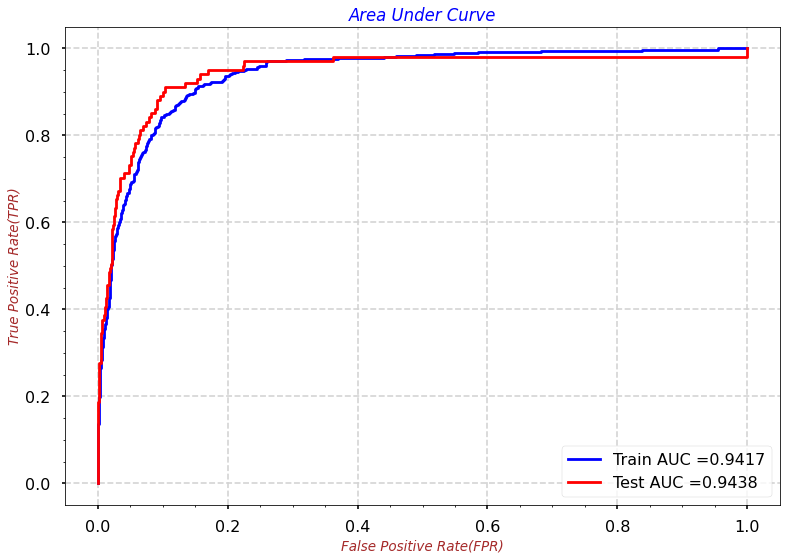

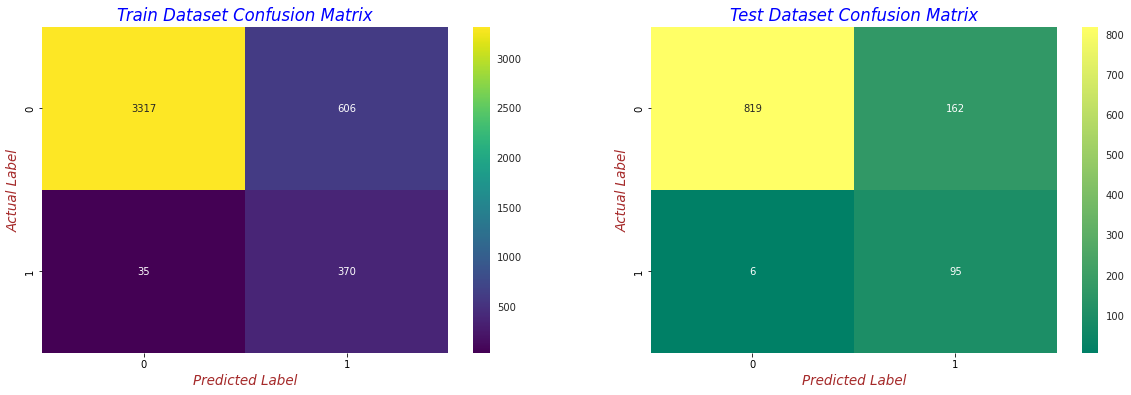



### Best Threshold = 0.3369
### Model AUC is : 0.9438
### Model Train F1 Score is : 0.5358
### Model Test F1 Score is : 0.5307


In [787]:
# Validate Logistic Regression model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(log_reg_1, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [788]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': log_reg_1.coef_[0]})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.539295
1,Admitted_Duration,0.439222
2,PRV_Tot_DGrpCodes,-0.030426
3,PRV_Tot_Unq_DOB_Years,-0.247869
4,PRV_Bene_Age_Sum,0.027942


In [789]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

In [790]:
top_15_neg_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Features'].iloc[0:15]
top_15_neg_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Importance_Model_1'].iloc[0:15]

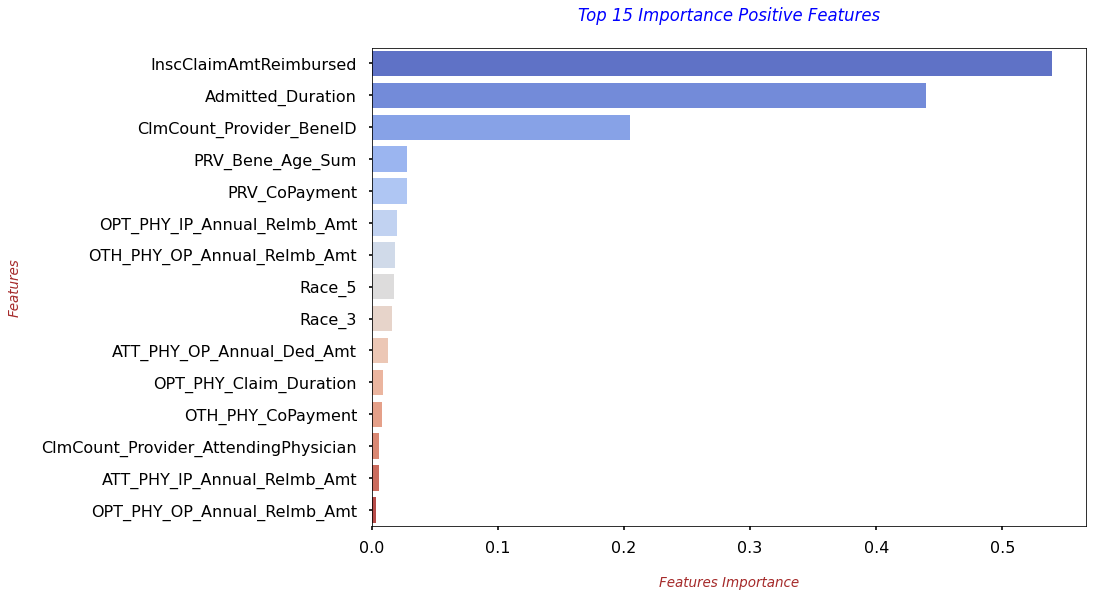

In [791]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

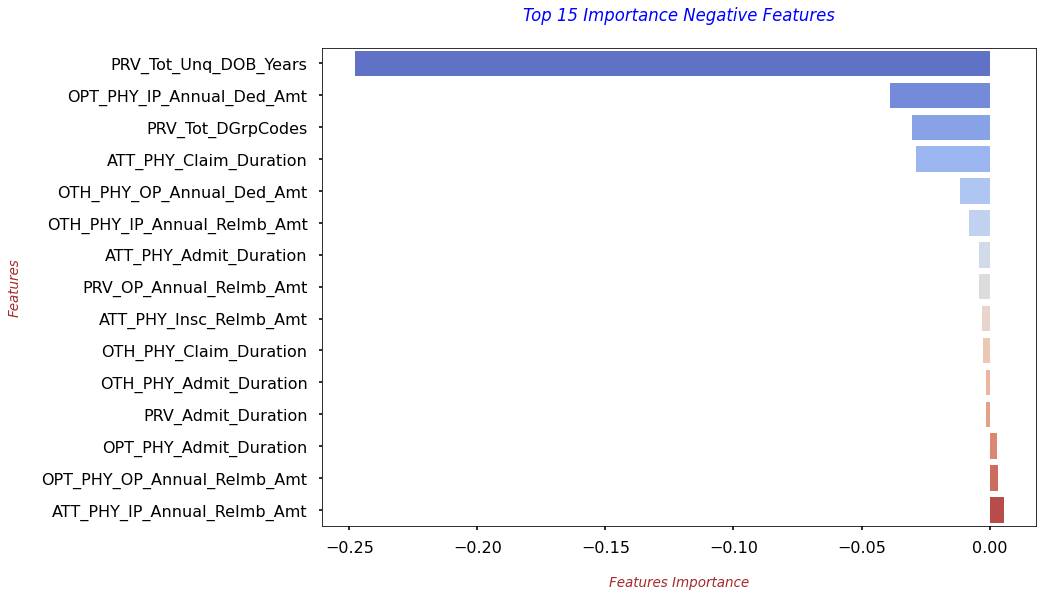

In [792]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_neg_feats, x=top_15_neg_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Negative Features\n", fontdict=title_font_dict)

#### **`2. Decision Tree`**

In [793]:
from sklearn.tree import DecisionTreeClassifier

In [794]:
# Training the model with all features and hyper-parameterized values
dec_tree_2 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='auto',
                                   min_samples_leaf=100,
                                   min_samples_split=50,
                                   class_weight='balanced',
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_2.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       max_features='auto', min_samples_leaf=100,
                       min_samples_split=50, random_state=49)

### Train AUC = 0.945017198352231
### Test AUC = 0.9461602123515104


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


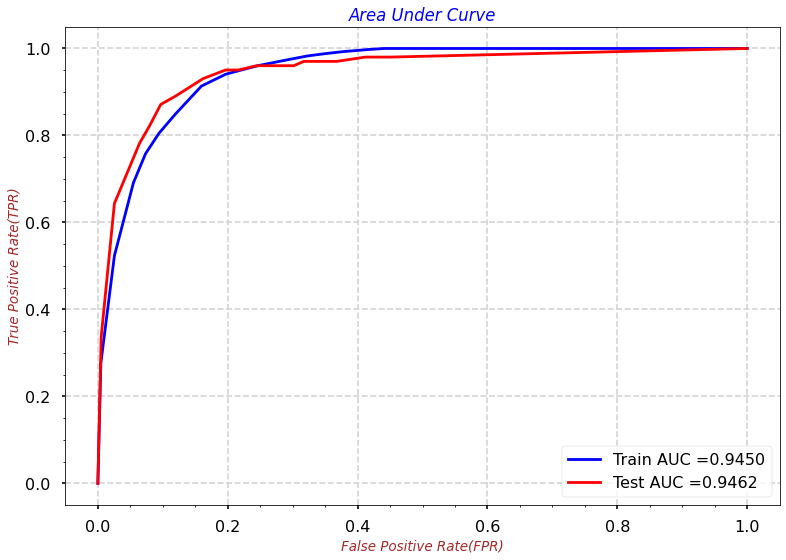

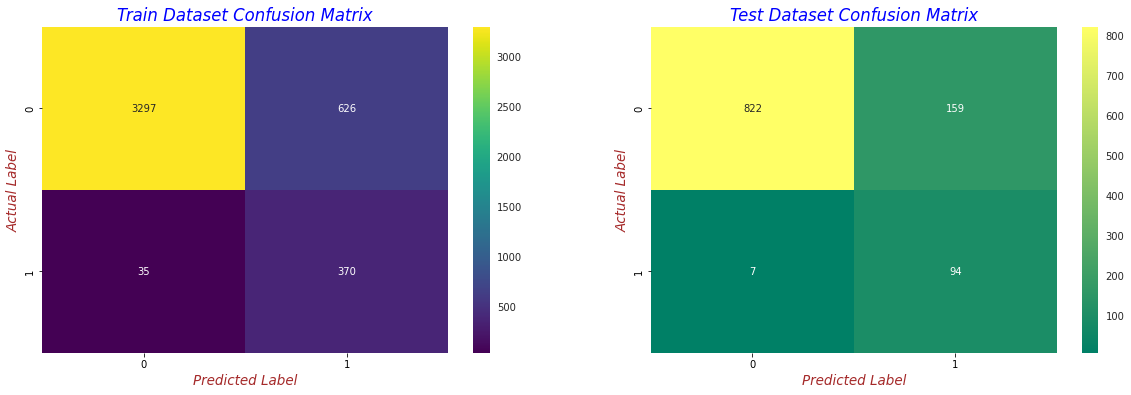



### Best Threshold = 0.6160
### Model AUC is : 0.9462
### Model Train F1 Score is : 0.5282
### Model Test F1 Score is : 0.5311


In [795]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(dec_tree_2, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [796]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': dec_tree_2.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,1.387090e-01
1,DeductibleAmtPaid,1.909211e-03
2,ChronicCond_Cancer,1.658138e-16
3,OPAnnualDeductibleAmt,7.829921e-03
4,Clm_Admit_Diag_Proc_Similarity,1.924751e-15


In [797]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

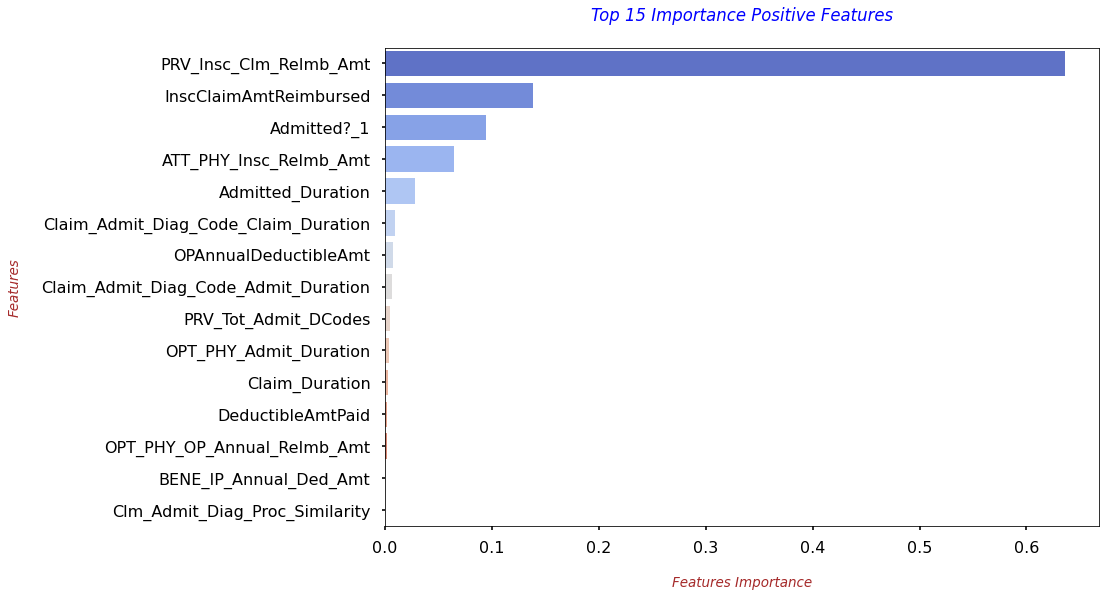

In [798]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

#### **`3. Random Forest Classifier`**

In [799]:
from sklearn.ensemble import RandomForestClassifier

In [800]:
# Training the model with all features and hyper-parameterized values
rfc_3 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=50,
                                   min_samples_split=50,
                                   class_weight='balanced',
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_3.fit(X_train_std, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=49)

### Train AUC = 0.9473894065703057
### Test AUC = 0.9516002058921489


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


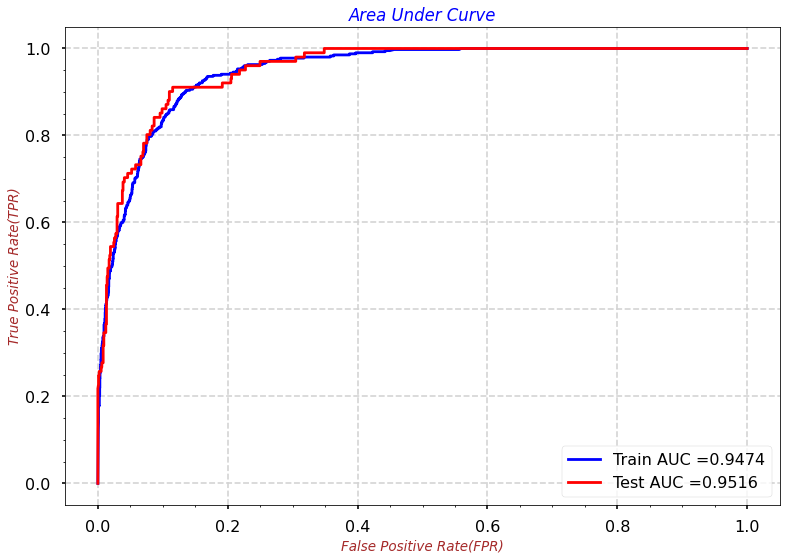

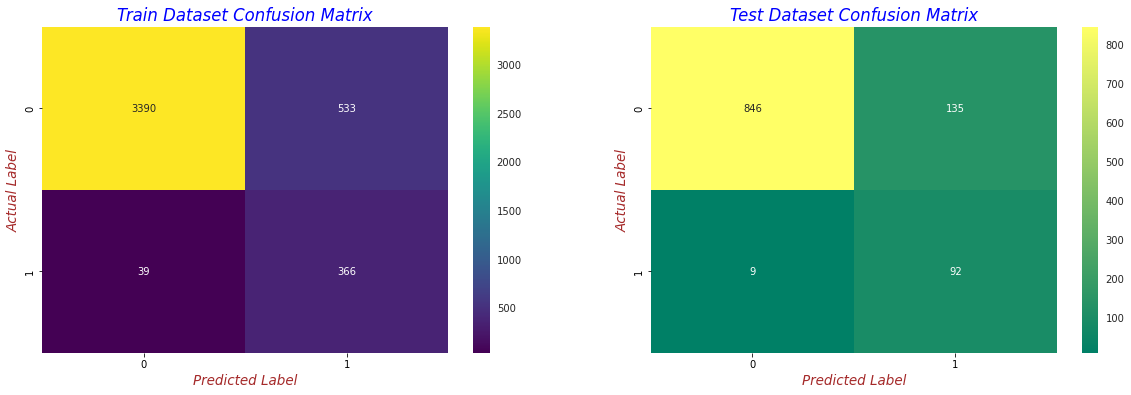



### Best Threshold = 0.5161
### Model AUC is : 0.9516
### Model Train F1 Score is : 0.5613
### Model Test F1 Score is : 0.5610


In [801]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_3, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [802]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_3.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.096383
1,DeductibleAmtPaid,0.036447
2,RenalDiseaseIndicator,0.000225
3,ChronicCond_Alzheimer,0.005393
4,ChronicCond_KidneyDisease,0.002140


In [803]:
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]

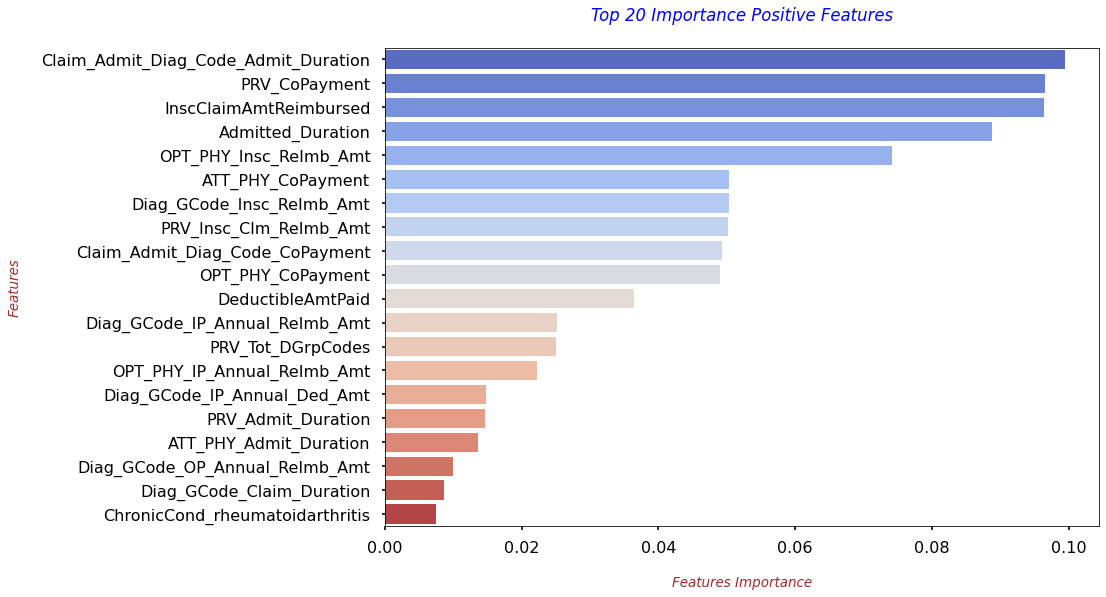

In [804]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_20_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 20 Importance Positive Features\n", fontdict=title_font_dict)

### **`Using Minority Synthetic Oversampling`**

#### **`Train Test Split` :: Creating TRAIN and VALIDATION sets.**

   * **`Reasoning`** :: These sets will be used for measurng the performance of ML Models.

In [805]:
from sklearn.model_selection import train_test_split as tts

In [806]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, stratify=y, random_state=39)

In [807]:
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4057, 102), (1353, 102), (4057,), (1353,))

In [808]:
# Checking count of tgt labels in y_train
y_train.value_counts()

0    3678
1     379
Name: PotentialFraud, dtype: int64

In [809]:
# Checking count of tgt labels in y_test
y_test.value_counts()

0    1226
1     127
Name: PotentialFraud, dtype: int64

#### **`Standardizing the TRAIN & TEST sets` :: Bringing every feature into the same scale.**

In [810]:
from sklearn.preprocessing import RobustScaler

In [811]:
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)

In [812]:
from collections import Counter

In [813]:
# BEFORE Oversampling :: Checking the percentage share of fraud and non-fraud records in the TRAIN set
counter = Counter(y_train)
counter

Counter({0: 3678, 1: 379})

In [814]:
fraud_percentage = (counter[1]*100 / (counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100 / (counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.34% and Non-Fraud Percentage = 90.66%


In [815]:
# Performing minority oversampling
from imblearn.over_sampling import ADASYN

In [816]:
oversample = ADASYN(sampling_strategy=0.35, n_neighbors=12)
X_train_ovsamp, y_train_ovsamp = oversample.fit_resample(X_train_std, y_train)

X_train_ovsamp.shape, y_train_ovsamp.shape

((4941, 102), (4941,))

In [817]:
counter = Counter(y_train_ovsamp)
counter

Counter({0: 3678, 1: 1263})

In [818]:
fraud_percentage = (counter[1]*100 / (counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100 / (counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 25.56% and Non-Fraud Percentage = 74.44%


#### **`4. Logistic Regression`**

In [819]:
# Training the model with all features and hyper-parameterized values
log_reg_4 = LogisticRegression(C=0.03, penalty='l1',
                               fit_intercept=True, 
                               solver='liblinear', 
                               tol=0.0001, 
                               max_iter=500, 
                               verbose=0, 
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_4.fit(X_train_ovsamp, y_train_ovsamp)

LogisticRegression(C=0.03, intercept_scaling=1.0, max_iter=500, penalty='l1',
                   random_state=49, solver='liblinear')

### Train AUC = 0.9265677196417723
### Test AUC = 0.9314202771961825


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


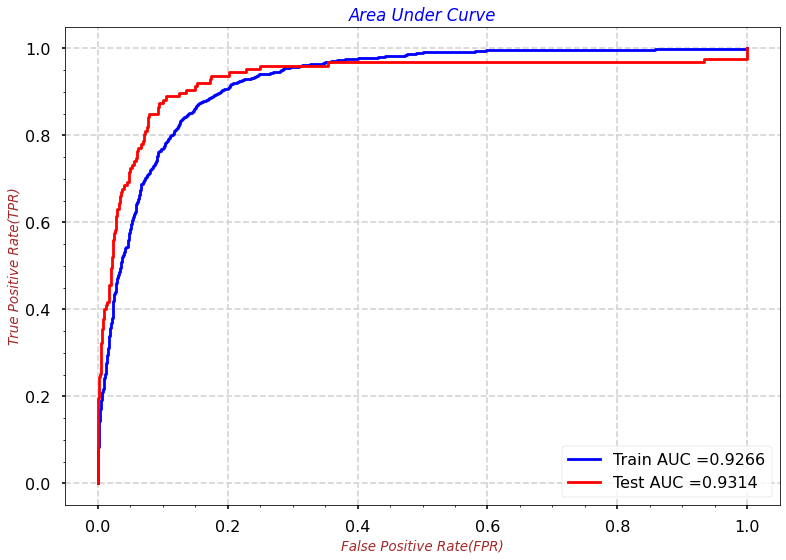

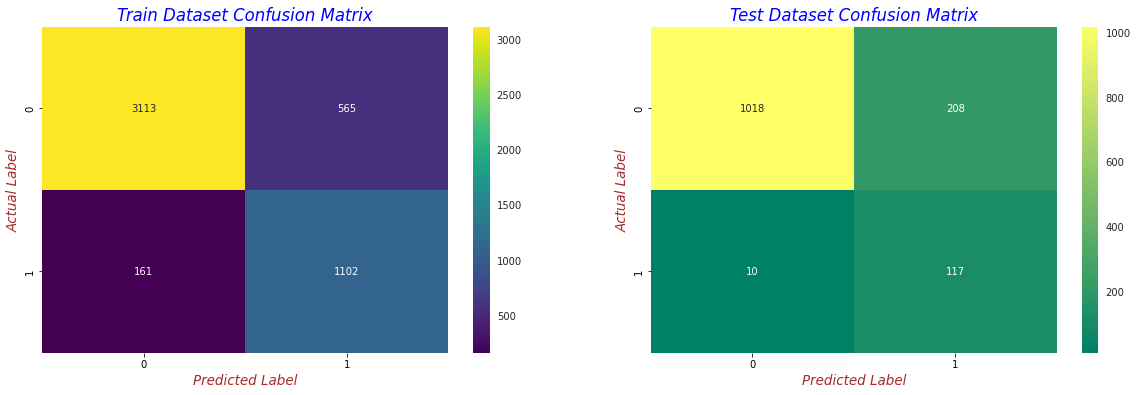



### Best Threshold = 0.1990
### Model AUC is : 0.9314
### Model Train F1 Score is : 0.7522
### Model Test F1 Score is : 0.5177


In [820]:
# Validate Logistic Regression model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(log_reg_4, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [821]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': log_reg_4.coef_[0]})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.605982
1,ChronicCond_stroke,0.090109
2,Admitted_Duration,0.317957
3,PRV_Tot_Admit_DCodes,-0.005935
4,PRV_Tot_DGrpCodes,-0.014639


In [822]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

In [823]:
top_15_neg_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Features'].iloc[0:15]
top_15_neg_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Importance_Model_1'].iloc[0:15]

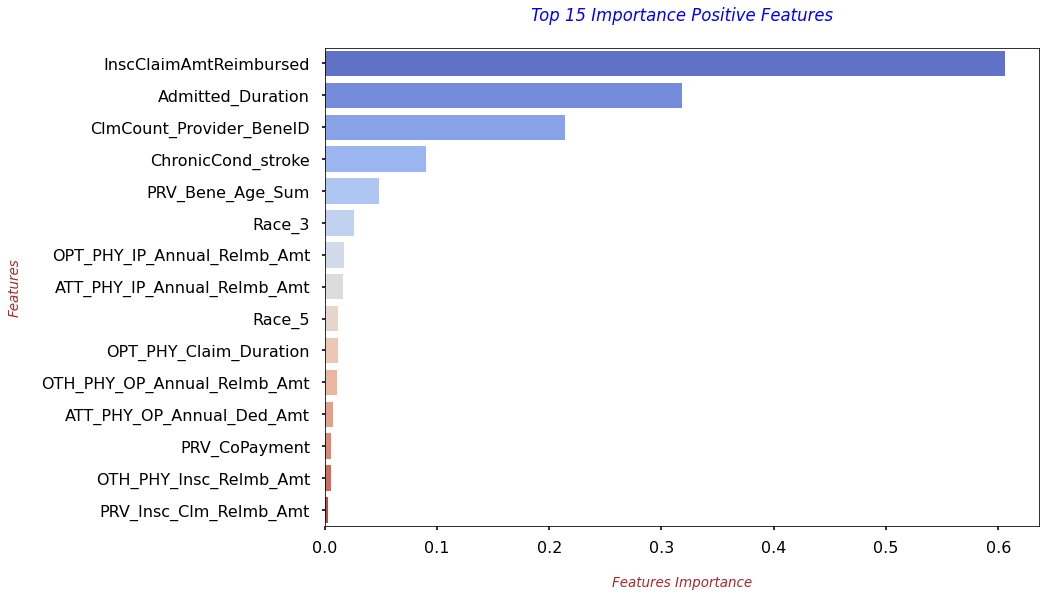

In [824]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

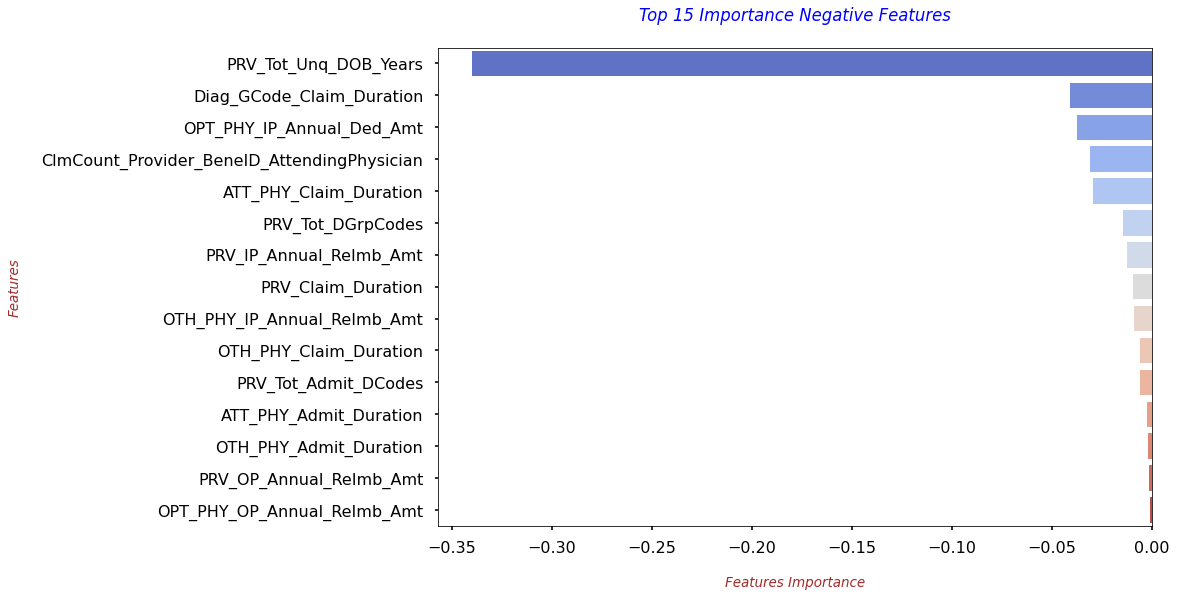

In [825]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_neg_feats, x=top_15_neg_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Negative Features\n", fontdict=title_font_dict)

#### **`5. Decision Tree`**

In [826]:
from sklearn.tree import DecisionTreeClassifier

In [827]:
# Training the model with all features and hyper-parameterized values
dec_tree_5 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='log2',
                                   min_samples_leaf=150,
                                   min_samples_split=150,
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_5.fit(X_train_ovsamp, y_train_ovsamp)

DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_leaf=150,
                       min_samples_split=150, random_state=49)

### Train AUC = 0.910743385700084
### Test AUC = 0.9362275372185329


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


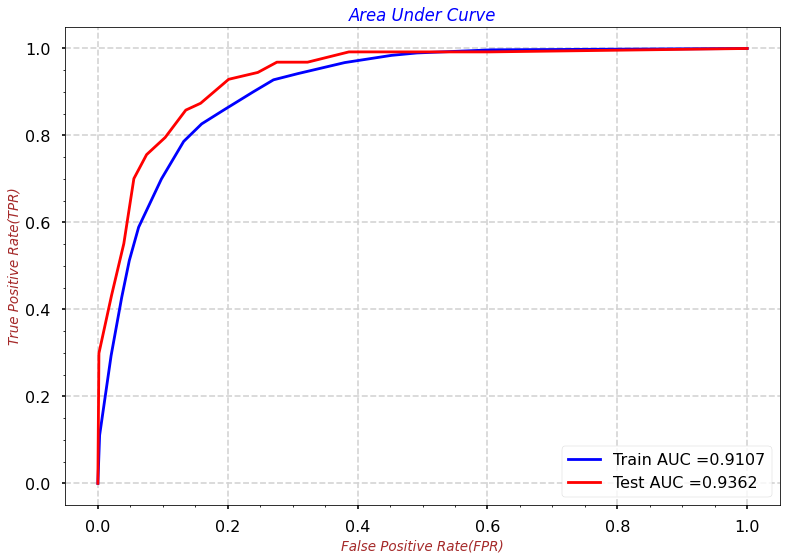

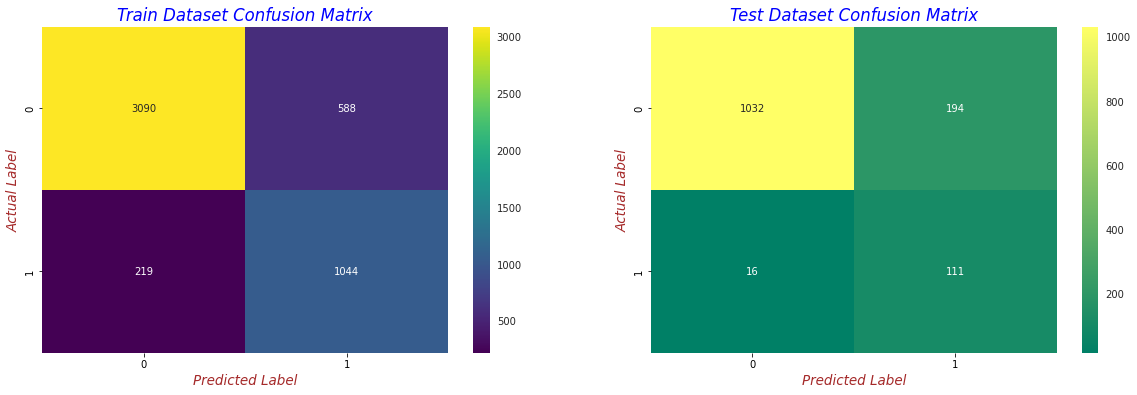



### Best Threshold = 0.3333
### Model AUC is : 0.9362
### Model Train F1 Score is : 0.7212
### Model Test F1 Score is : 0.5139


In [828]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(dec_tree_5, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [829]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': dec_tree_5.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,DeductibleAmtPaid,0.002356
1,ChronicCond_Depression,0.011755
2,IPAnnualReimbursementAmt,0.519807
3,Admitted_Duration,0.001040
4,PRV_Bene_Age_Sum,0.007931


In [830]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]

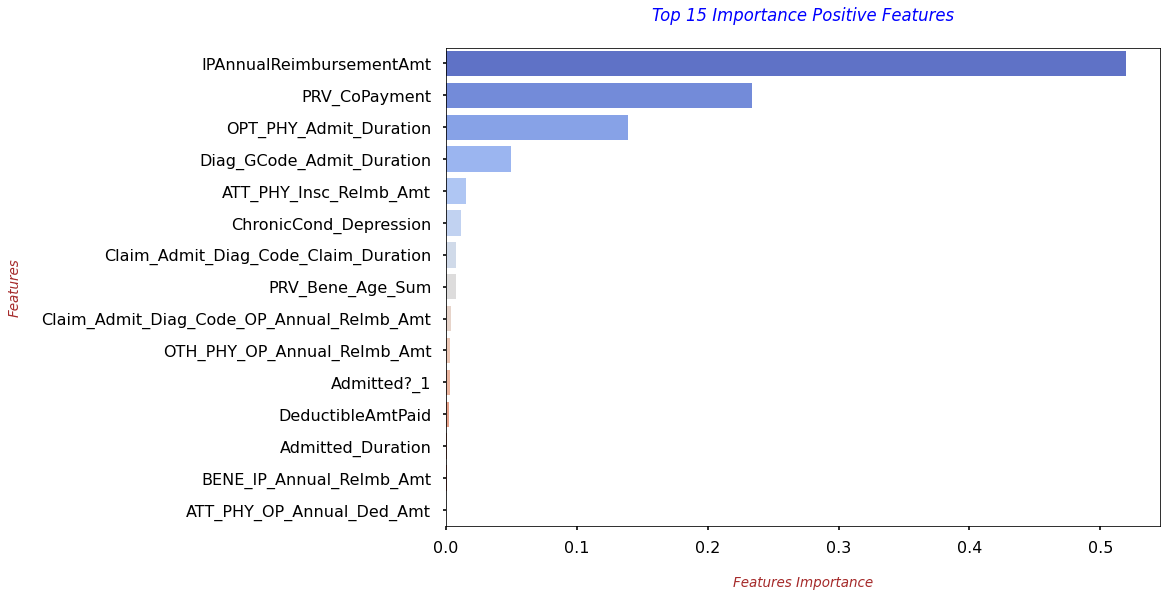

In [831]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

#### **`6. Random Forest Classifier`**

In [832]:
from sklearn.ensemble import RandomForestClassifier

In [833]:
# Training the model with all features and hyper-parameterized values
rfc_6 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=100,
                                   min_samples_split=50,
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_6.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=50,
                       n_estimators=30, random_state=49)

### Train AUC = 0.9182419100194303
### Test AUC = 0.9460443668032523


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


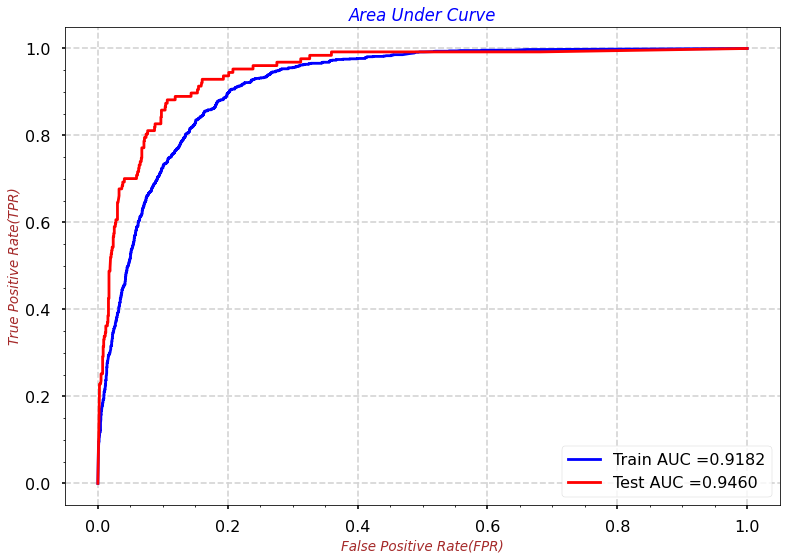

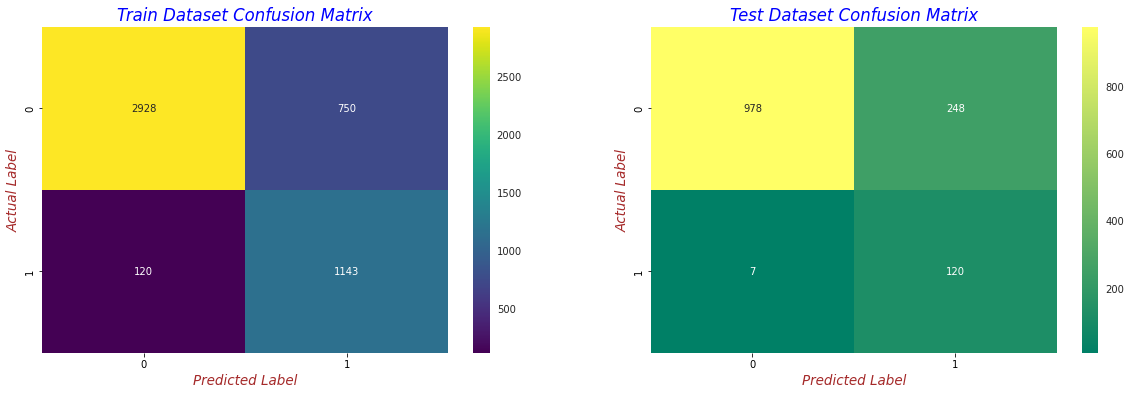



### Best Threshold = 0.0848
### Model AUC is : 0.9460
### Model Train F1 Score is : 0.7243
### Model Test F1 Score is : 0.4848


In [834]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_6, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [835]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_6.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.103122
1,DeductibleAmtPaid,0.017575
2,ChronicCond_Cancer,0.000972
3,ChronicCond_Depression,0.000118
4,ChronicCond_Diabetes,0.000124


In [836]:
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]

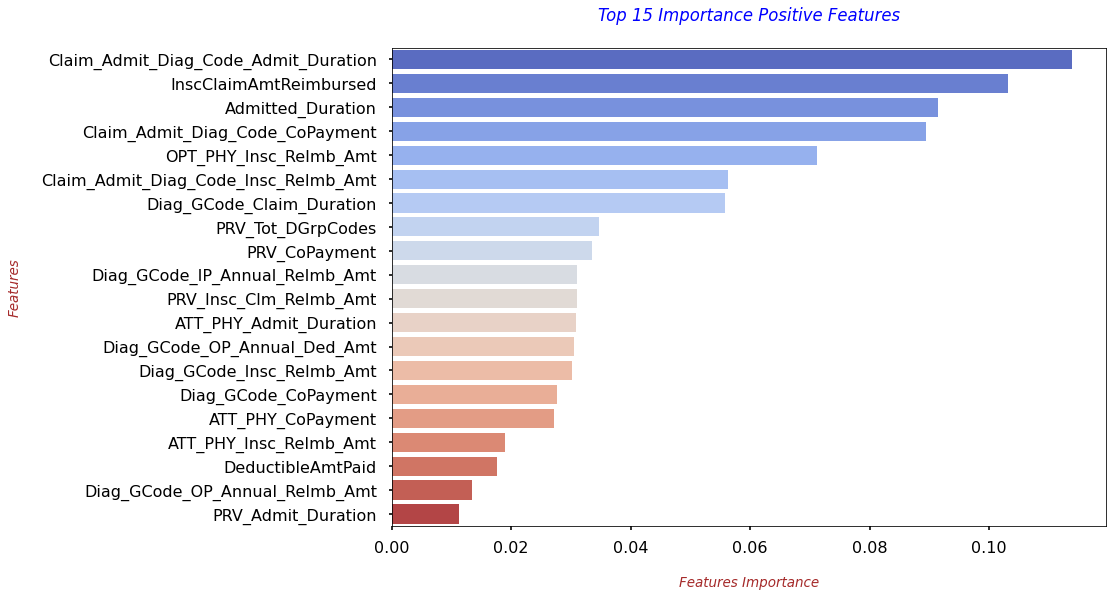

In [837]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_20_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 15 Importance Positive Features\n", fontdict=title_font_dict)

# **`Models - SET 2 - RESULTS`**

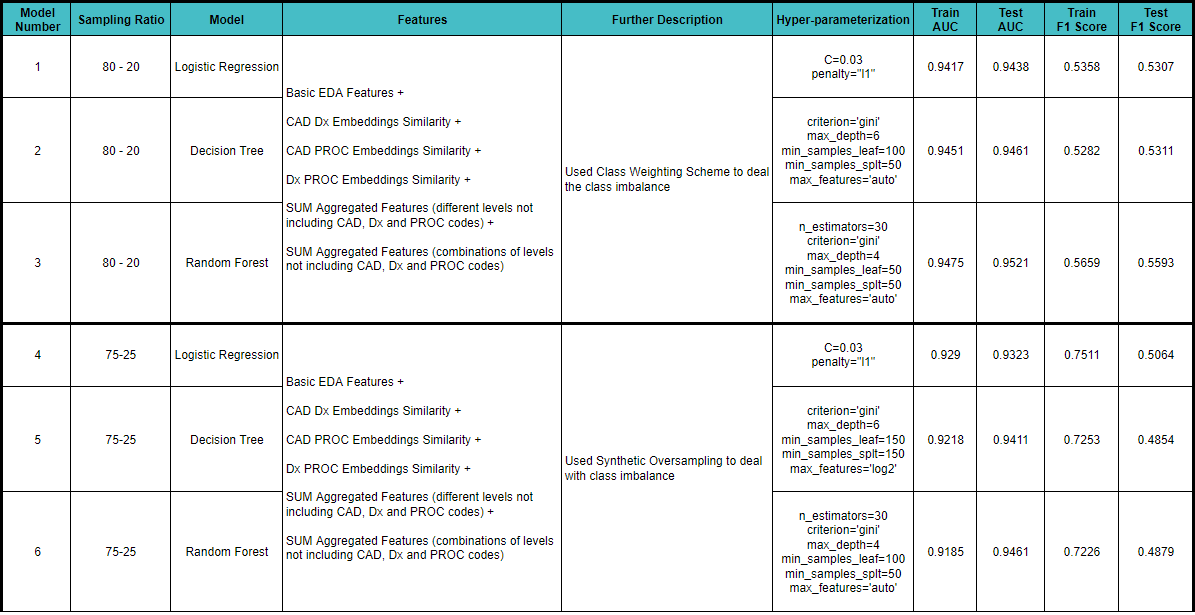

In [838]:
from IPython.display import Image
Image("../input/medicare-prv-fraud-files/Models_Set_2_Results.png")

## **`Models - SET 2 - OBSERVATIONS`**

- **Adding the Similarity Score features of embeddings b/w below mentioned doesn't really helped in improving the models performance:**
    - CAD and Dx Codes
    - Dx and PROC Codes
    - CAD and PROC Codes
    
- **Doing the synthetic oversampling of the minority class doesn't provide gain in the model's performance whehreas we can see a noticeable drop in the performace.** 

# **`Referred Links`**

- https://www.icd10data.com/ICD10CM/Codes

- https://www.icd10data.com/ICD10CM/DRG

- https://www.plasticsurgery.org/Documents/Health-Policy/Coding-Payment/ICD-10/icd-10-medical-diagnosis-codes.pdf

- https://ftp.cdc.gov/pub/health_statistics/nchs/publications/ICD10CM/2019/icd10cm_tabular_2019.pdf


- Very imp link :: Also downloaded files :: https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes

- https://www.cms.gov/Medicare/Coding/OutpatientCodeEdit/Downloads/ICD-10-IOCE-Code-Lists.pdf

- https://medicaid.utah.gov/Documents/pdfs/ClaimDenialCodes.pdf

- https://www.cms.gov/Medicare/Coding/OutpatientCodeEdit/Downloads/ICD-10-IOCE-Code-Lists.pdf

- DRG :: https://www.findacode.com/code-set.php?set=DRG
